<a href="https://colab.research.google.com/github/MariiaKalinina/BM/blob/main/BM_10layer_PaleoReconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Libraries

In [ ]:
import pandas as pd
import numpy as np
from math import *
from scipy.special import lambertw
import matplotlib.pyplot as plt

In [ ]:
!pip install GitPython

In [ ]:
from git import Repo
!git clone https://github.com/MariiaKalinina/BM.git

Cloning into 'BM'...
remote: Enumerating objects: 1080, done.
remote: Counting objects: 100% (449/449), done.
remote: Compressing objects: 100% (223/223), done.
remote: Total 1080 (delta 332), reused 226 (delta 226), pack-reused 631 (from 1)
Receiving objects: 100% (1080/1080), 119.17 MiB | 12.94 MiB/s, done.
Resolving deltas: 100% (593/593), done.
Updating files: 100% (171/171), done.


### Step 0. Data preparation

In [ ]:
# import pandas as pd

# Allen & Allne - Data (10 layers)
# df_constast = pd.read_csv('/content/BM/Initial data/Constants.csv', delimiter=';', header=0)
# df_well = pd.read_csv('/content/BM/Initial data/Well_parametrs.csv', delimiter=';', header=0)

# Test Data-1
df_constast = pd.read_csv('/content/BM/Initial data/Constants.csv', delimiter=';', header=0)
df_well = pd.read_csv('/content/BM/Initial data/Well_parametrs_test1.csv', delimiter=';', header=0)

# df_well = pd.read_csv('/content/Well_parametrs_v1.csv', delimiter=';', header=0) ### пример для 3х слойной модели
# df_well = pd.read_csv('/content/BM/Well_parametrs_A13.csv', delimiter=';', header=0) ### Geoterm test - Appendix 13

df_well[['Depth top, m', 'Depth bottom, m']] = df_well[['Depth top, m', 'Depth bottom, m']].apply(lambda x: x / 1000)

In [ ]:
df_well

Well Event_name  Event_type Lithology_type  Age (Ma)  Depth top, m  \
0   Test_well    Erosion     Erosion            NaN         0          0.00   
1   Test_well   Layer 10     Erosion         Shales         0          0.00   
2   Test_well    Layer 9  Deposition     Sandstones        45          0.20   
3   Test_well    Layer 8  Deposition         Shales        55          0.45   
4   Test_well    Layer 7  Deposition          Chalk        80          1.20   
5   Test_well    Layer 6  Deposition     Sandstones       100          2.50   
6   Test_well    Layer 5  Deposition     Limestones       125          3.40   
7   Test_well    Layer 4  Deposition       Dolomite       145          3.60   
8   Test_well    Layer 3  Deposition     Sandstones       160          4.00   
9   Test_well    Layer 2  Deposition      Anhydrite       210          4.25   
10  Test_well    Layer 1  Deposition      Quartzite       245          5.00   
11  Test_well  Fundament  Deposition            NaN       260          5.40   

    Depth bottom, m  Thickness, m  D Thickness (erosion), m  \
0              0.00             0                       NaN   
1              0.20           200                       NaN   
2              0.45           250                       NaN   
3              1.20           750                       NaN   
4              2.50          1300                       NaN   
5              3.40           900                       NaN   
6              3.60           200                       NaN   
7              4.00           400                       NaN   
8              4.25           250                       NaN   
9              5.00           750                       NaN   
10             5.40           400                       NaN   
11             5.40             0                       NaN   

    Paleobathymetry, Ma  Sea level, m Sublayers  N sublayers          PSE  \
0                   300             0       NaN          NaN          NaN   
1                   300             0        On          0.0          NaN   
2                   325            40        On          0.0          NaN   
3                   350            50        On          0.0          NaN   
4                   300           100        On          0.0          NaN   
5                   200            80        On          0.0          NaN   
6                    20            70        On          0.0  Source Rock   
7                    20           -40        On          0.0          NaN   
8                    10           -20        On          0.0          NaN   
9                    20             0        On          0.0          NaN   
10                    0             0        On          0.0          NaN   
11                  -20            10       NaN          NaN          NaN   

                       Kinetic  TOC initial, %  HI initial, %  
0                          NaN             NaN            NaN  
1                          NaN             NaN            NaN  
2                          NaN             NaN            NaN  
3                          NaN             NaN            NaN  
4                          NaN             NaN            NaN  
5                          NaN             NaN            NaN  
6   Tegelaar(1994)_TI-S(Spain)            10.0          100.0  
7                          NaN             NaN            NaN  
8                          NaN             NaN            NaN  
9                          NaN             NaN            NaN  
10                         NaN             NaN            NaN  
11                         NaN             NaN            NaN

In [ ]:
df_constast

Lithology_type  Porosity  Exp_decay, km-1  Grain density  TC matrix  \
0         Shales      0.63             0.51           2720        2.0   
1     Sandstones      0.49             0.27           2650        5.5   
2          Chalk      0.70             0.71           2710        3.3   
3     Limestones      0.40             0.60           2710        3.3   
4       Dolomite      0.20             0.60           2870        5.3   
5      Anhydrite      0.05             0.20           2960        6.3   
6      Quartzite      0.20             0.30           2650        7.7   
7      Fundament      0.00             0.00           2800        3.0   

   Radiogenic Heat Production  Ki_framework  
0                1.700000e-06           2.0  
1                1.200000e-06           5.5  
2                4.000000e-07           3.3  
3                5.000000e-07           3.3  
4                4.000000e-07           5.3  
5                1.000000e-07           6.3  
6                5.000000e-07           7.7  
7                2.800000e-06           3.0

### DataBase

In [ ]:
import pandas as pd

file_path = '/content/BM/Initial data/Literature database from PM for all rock lithotypes.xlsx'

database = pd.ExcelFile(file_path)
print("Available sheets:", database.sheet_names)

for sheet_name in database.sheet_names:
    clean_name = sheet_name.replace(" ", "_").replace("-", "_")
    var_name = f"Database_{clean_name}"

    # Assign the DataFrame to a dynamically named variable
    globals()[var_name] = pd.read_excel(
        file_path,
        sheet_name=sheet_name,
        header=0
    )
    print(f"Created variable: {var_name}")

Available sheets: ['Lithotypes', 'Kinetics all', 'Secondary cracking', 'Geochronology', 'SWIT_Map', 'SWIT_coordinates ', 'Global eustatic curve']
Created variable: Database_Lithotypes
Created variable: Database_Kinetics_all
Created variable: Database_Secondary_cracking
Created variable: Database_Geochronology
Created variable: Database_SWIT_Map
Created variable: Database_SWIT_coordinates_
Created variable: Database_Global_eustatic_curve


#### Lithology

In [ ]:
from pandas.api.types import is_scalar

Database_Lithotypes.columns = Database_Lithotypes.iloc[0]
Database_Lithotypes = Database_Lithotypes.drop([0, 1]).reset_index(drop=True)

current_columns = Database_Lithotypes.columns
if is_scalar(current_columns[0]) and pd.isna(current_columns[0]):
    new_columns = list(current_columns)
    new_columns[0] = "Lithology type"
    Database_Lithotypes.columns = new_columns

Database_Lithotypes.head(7)
# Database_Lithotypes.head(7).iloc[:, :6]

Lithology type Density Initial porosity  \
0                      Sandstone (typical)    2720               41   
1                    Sandstone (clay rich)    2760               40   
2                    Sandstone (clay poor)    2700               42   
3           Sandstone (quartzite, typical)    2640               42   
4  Sandstone (quartzite, very quartz rich)    2640               42   
5           Sandstone (subarkose, typical)    2680               41   
6       Sandstone (subarkose, quartz rich)    2650               42   

  Minimum porosity Compaction model Key Compressibility MAX  \
0                1   Athy's law (depth)               27.47   
1                1   Athy's law (depth)               26.54   
2                1   Athy's law (depth)               28.05   
3                1   Athy's law (depth)                29.1   
4                1   Athy's law (depth)               25.26   
5                1   Athy's law (depth)               24.48   
6                1   Athy's law (depth)               26.34   

  Compressibility MIN Athy factor k (stress) Schneider Factor ka  \
0                1.15                   26.6               41.56   
1                1.11                  26.61                  40   
2                1.18                  26.27               40.47   
3                1.22                  27.26               42.81   
4                1.18                  24.61               16.15   
5                1.14                  24.68               16.31   
6                1.19                  25.33               39.84   

  Schneider factor kb  ...   Ea     A Clay Content Porosity Opal A- opal CT  \
0               17.81  ...  23.2  0.0            0                        0   
1               18.12  ...  23.2  0.0            0                        0   
2               17.34  ...  23.2  0.0            0                        0   
3               17.81  ...  23.2  0.0            0                        0   
4               39.77  ...  23.2  0.0            0                        0   
5               38.74  ...  23.2  0.0            0                        0   
6               16.41  ...  23.2  0.0            0                        0   

  Permeability Opal A- Opal CT Capillary Pressure Opal A-opal CT  \
0                            0                                 0   
1                            0                                 0   
2                            0                                 0   
3                            0                                 0   
4                            0                                 0   
5                            0                                 0   
6                            0                                 0   

  Porosity Opal CT-Quartz Permeability Opal CT - Quartz  \
0                       0                             0   
1                       0                             0   
2                       0                             0   
3                       0                             0   
4                       0                             0   
5                       0                             0   
6                       0                             0   

  Capillary pressure Opal CT - Quartz Special options  
0                                   0             NaN  
1                                   0             NaN  
2                                   0             NaN  
3                                   0             NaN  
4                                   0             NaN  
5                                   0             NaN  
6                                   0             NaN  

[7 rows x 157 columns]

In [ ]:
Database_Lithotypes.head(7).iloc[:, :6]

Lithology type Density Initial porosity  \
0                      Sandstone (typical)    2720               41   
1                    Sandstone (clay rich)    2760               40   
2                    Sandstone (clay poor)    2700               42   
3           Sandstone (quartzite, typical)    2640               42   
4  Sandstone (quartzite, very quartz rich)    2640               42   
5           Sandstone (subarkose, typical)    2680               41   
6       Sandstone (subarkose, quartz rich)    2650               42   

  Minimum porosity Compaction model Key Compressibility MAX  
0                1   Athy's law (depth)               27.47  
1                1   Athy's law (depth)               26.54  
2                1   Athy's law (depth)               28.05  
3                1   Athy's law (depth)                29.1  
4                1   Athy's law (depth)               25.26  
5                1   Athy's law (depth)               24.48  
6                1   Athy's law (depth)               26.34

In [ ]:
print("Current columns:")
for idx, col in enumerate(Database_Lithotypes.columns, 1):
    print(f"{idx}. {col}")

Current columns:
1. Lithology type
2. Density
3. Initial porosity
4. Minimum porosity
5. Compaction model Key
6. Compressibility MAX
7. Compressibility MIN
8. Athy factor k (stress)
9. Schneider Factor ka
10. Schneider factor kb
11. Schneider factor phi
12. Athy factor k (depth)
13. Multipoint curve
14. Curve flag
15. Depth curve
16. Effective stress curve
17. Compaction formula
18. Thermal conductivity model key
19. Thermal conductivity at 20 oC
20. Thermal conductivity at 100 oC
21. Thermal conductivity minimum temperature
22. Thermal conductivity max temperature
23. Thermal conductivity conductivity multi-point model
24. Anisotropy factor thermal conductivity
25. Depositional anisotropy
26. Depositional anisotropy
27. Thermal expansion coefficient 
28. Radiogenic model key
29. Uranium
30. Thorium
31. Potassium
32. Porosity
33. Gamma Ray
34. Time correction
35. HeatFlow Production value
36. Half Depth Value
37. Heat capacity model key
38. Heat capacity at 20 oC
39. Heat capacity at 1

In [ ]:
sandstone_row = Database_Lithotypes[Database_Lithotypes['Lithology type'] == 'Sandstone (quartzite, very quartz rich)']
sandstone_row

Lithology type Density Initial porosity  \
4  Sandstone (quartzite, very quartz rich)    2640               42   

  Minimum porosity Compaction model Key Compressibility MAX  \
4                1   Athy's law (depth)               25.26   

  Compressibility MIN Athy factor k (stress) Schneider Factor ka  \
4                1.18                  24.61               16.15   

  Schneider factor kb  ...   Ea     A Clay Content Porosity Opal A- opal CT  \
4               39.77  ...  23.2  0.0            0                        0   

  Permeability Opal A- Opal CT Capillary Pressure Opal A-opal CT  \
4                            0                                 0   

  Porosity Opal CT-Quartz Permeability Opal CT - Quartz  \
4                       0                             0   

  Capillary pressure Opal CT - Quartz Special options  
4                                   0             NaN  

[1 rows x 157 columns]

In [ ]:
sandstone_row["Compressibility MIN"]

4    1.18
Name: Compressibility MIN, dtype: object

Check name of lithology to name in Database_Lithotypes

In [ ]:
# Database_Lithotypes['Lithology type'].values
if 'Anhydrite' in Database_Lithotypes['Lithology type'].values:
    print("✅ found (case-sensitive match)")
else:
    print("❌ NOT found (case-sensitive match)")

✅ found (case-sensitive match)


In [ ]:
df_well["Lithology_type"] = df_well["Lithology_type"].replace({
    "Sandstones": "Sandstone (typical)",
    "Shales": "Shale (typical)",
    "Limestones": "Limestone (organic rich - typical)",
    "Dolomite": "Dolomite (typical)",
    "Chalk": "Chalk (typical)",
    "Anhydrite": "Anhydrite",
    "Quartzite": "Quartzite",
    # "Fundament": "Basement"

})

In [ ]:
df_well

Well Event_name  Event_type                      Lithology_type  \
0   Test_well    Erosion     Erosion                                 NaN   
1   Test_well   Layer 10     Erosion                     Shale (typical)   
2   Test_well    Layer 9  Deposition                 Sandstone (typical)   
3   Test_well    Layer 8  Deposition                     Shale (typical)   
4   Test_well    Layer 7  Deposition                     Chalk (typical)   
5   Test_well    Layer 6  Deposition                 Sandstone (typical)   
6   Test_well    Layer 5  Deposition  Limestone (organic rich - typical)   
7   Test_well    Layer 4  Deposition                  Dolomite (typical)   
8   Test_well    Layer 3  Deposition                 Sandstone (typical)   
9   Test_well    Layer 2  Deposition                           Anhydrite   
10  Test_well    Layer 1  Deposition                           Quartzite   
11  Test_well  Fundament  Deposition                                 NaN   

    Age (Ma)  Depth top, m  Depth bottom, m  Thickness, m  \
0          0          0.00             0.00             0   
1          0          0.00             0.20           200   
2         45          0.20             0.45           250   
3         55          0.45             1.20           750   
4         80          1.20             2.50          1300   
5        100          2.50             3.40           900   
6        125          3.40             3.60           200   
7        145          3.60             4.00           400   
8        160          4.00             4.25           250   
9        210          4.25             5.00           750   
10       245          5.00             5.40           400   
11       260          5.40             5.40             0   

    D Thickness (erosion), m  Paleobathymetry, Ma  Sea level, m Sublayers  \
0                        NaN                  300             0       NaN   
1                        NaN                  300             0        On   
2                        NaN                  325            40        On   
3                        NaN                  350            50        On   
4                        NaN                  300           100        On   
5                        NaN                  200            80        On   
6                        NaN                   20            70        On   
7                        NaN                   20           -40        On   
8                        NaN                   10           -20        On   
9                        NaN                   20             0        On   
10                       NaN                    0             0        On   
11                       NaN                  -20            10       NaN   

    N sublayers          PSE                     Kinetic  TOC initial, %  \
0           NaN          NaN                         NaN             NaN   
1           0.0          NaN                         NaN             NaN   
2           0.0          NaN                         NaN             NaN   
3           0.0          NaN                         NaN             NaN   
4           0.0          NaN                         NaN             NaN   
5           0.0          NaN                         NaN             NaN   
6           0.0  Source Rock  Tegelaar(1994)_TI-S(Spain)            10.0   
7           0.0          NaN                         NaN             NaN   
8           0.0          NaN                         NaN             NaN   
9           0.0          NaN                         NaN             NaN   
10          0.0          NaN                         NaN             NaN   
11          NaN          NaN                         NaN             NaN   

    HI initial, %  
0             NaN  
1             NaN  
2             NaN  
3             NaN  
4             NaN  
5             NaN  
6           100.0  
7             NaN  
8             NaN  
9             NaN  
10            N

In [ ]:
df_well.to_csv('initial_well_data.csv', index=False)

In [ ]:
df_constast["Lithology_type"] = df_constast["Lithology_type"].replace({
    "Sandstones": "Sandstone (typical)",
    "Shales": "Shale (typical)",
    "Limestones": "Limestone (organic rich - typical)",
    "Dolomite": "Dolomite (typical)",
    "Chalk": "Chalk (typical)",
    "Anhydrite": "Anhydrite",
    "Quartzite": "Quartzite",
    # "Fundament": "Basement"
})

In [ ]:
df_constast

Lithology_type  Porosity  Exp_decay, km-1  \
0                     Shale (typical)      0.63             0.51   
1                 Sandstone (typical)      0.49             0.27   
2                     Chalk (typical)      0.70             0.71   
3  Limestone (organic rich - typical)      0.40             0.60   
4                  Dolomite (typical)      0.20             0.60   
5                           Anhydrite      0.05             0.20   
6                           Quartzite      0.20             0.30   
7                           Fundament      0.00             0.00   

   Grain density  TC matrix  Radiogenic Heat Production  Ki_framework  
0           2720        2.0                1.700000e-06           2.0  
1           2650        5.5                1.200000e-06           5.5  
2           2710        3.3                4.000000e-07           3.3  
3           2710        3.3                5.000000e-07           3.3  
4           2870        5.3                4.000000e-07           5.3  
5           2960        6.3                1.000000e-07           6.3  
6           2650        7.7                5.000000e-07           7.7  
7           2800        3.0                2.800000e-06           3.0

#### SWIT Map

In [ ]:
Database_SWIT_Map.head(5)

Unnamed: 0      Time  Unnamed: 2  Unnamed: 3  Unnamed: 4  Unnamed: 5  \
0   Latitude  360.0000    359.5000    359.0000    358.5000    358.0000   
1        -90    9.2507      9.2344      9.2180      9.2015      9.1849   
2      -89.5    9.2547      9.2381      9.2214      9.2047      9.1878   
3        -89    9.2596      9.2426      9.2256      9.2087      9.1915   
4      -88.5    9.2654      9.2480      9.2308      9.2135      9.1960   

   Unnamed: 6  Unnamed: 7  Unnamed: 8  Unnamed: 9  ...  Unnamed: 712  \
0    357.5000    357.0000    356.5000    356.0000  ...           4.5   
1      9.1679      9.1504      9.1323      9.1133  ...           5.0   
2      9.1705      9.1528      9.1344      9.1153  ...           5.0   
3      9.1740      9.1561      9.1375      9.1182  ...           5.0   
4      9.1784      9.1602      9.1415      9.1220  ...           5.0   

   Unnamed: 713  Unnamed: 714  Unnamed: 715  Unnamed: 716  Unnamed: 717  \
0           4.0           3.5           3.0           2.5           2.0   
1           5.0           5.0           5.0           5.0           5.0   
2           5.0           5.0           5.0           5.0           5.0   
3           5.0           5.0           5.0           5.0           5.0   
4           5.0           5.0           5.0           5.0           5.0   

   Unnamed: 718  Unnamed: 719  Unnamed: 720  Unnamed: 721  
0           1.5           1.0           0.5           0.0  
1           5.0           5.0           5.0           5.0  
2           5.0           5.0           5.0           5.0  
3           5.0           5.0           5.0           5.0  
4           5.0           5.0           5.0           5.0  

[5 rows x 722 columns]

In [ ]:
# Extract latitude
latitude = Database_SWIT_Map.iloc[1:, 0].astype(float).values
# Extract longitude
longitude = Database_SWIT_Map.iloc[0, 1:].astype(float).values
# Extract data values
data_values = Database_SWIT_Map.iloc[1:, 1:].astype(float).values

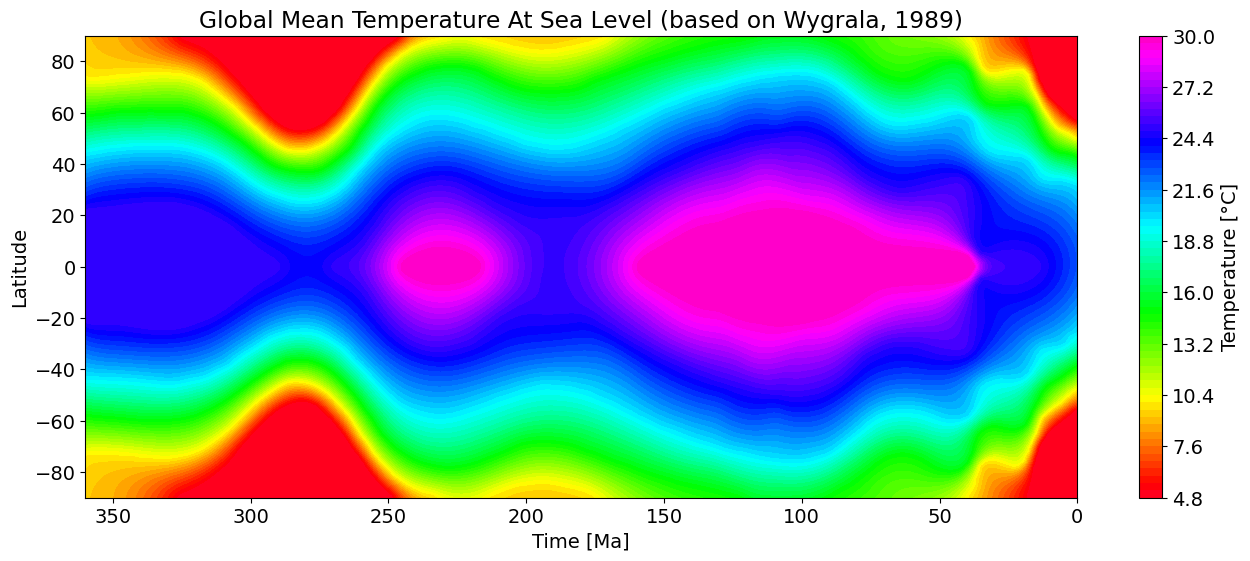

In [ ]:
Lon, Lat = np.meshgrid(longitude, latitude)
plt.figure(figsize=(16, 6))
contour = plt.contourf(Lon, Lat, data_values, cmap='gist_rainbow', levels=80)

plt.colorbar(contour, label="Temperature [°C]")

plt.xlabel("Time [Ma]")
plt.ylabel("Latitude")
plt.title("Global Mean Temperature At Sea Level (based on Wygrala, 1989)")

plt.gca().invert_xaxis()
plt.show()

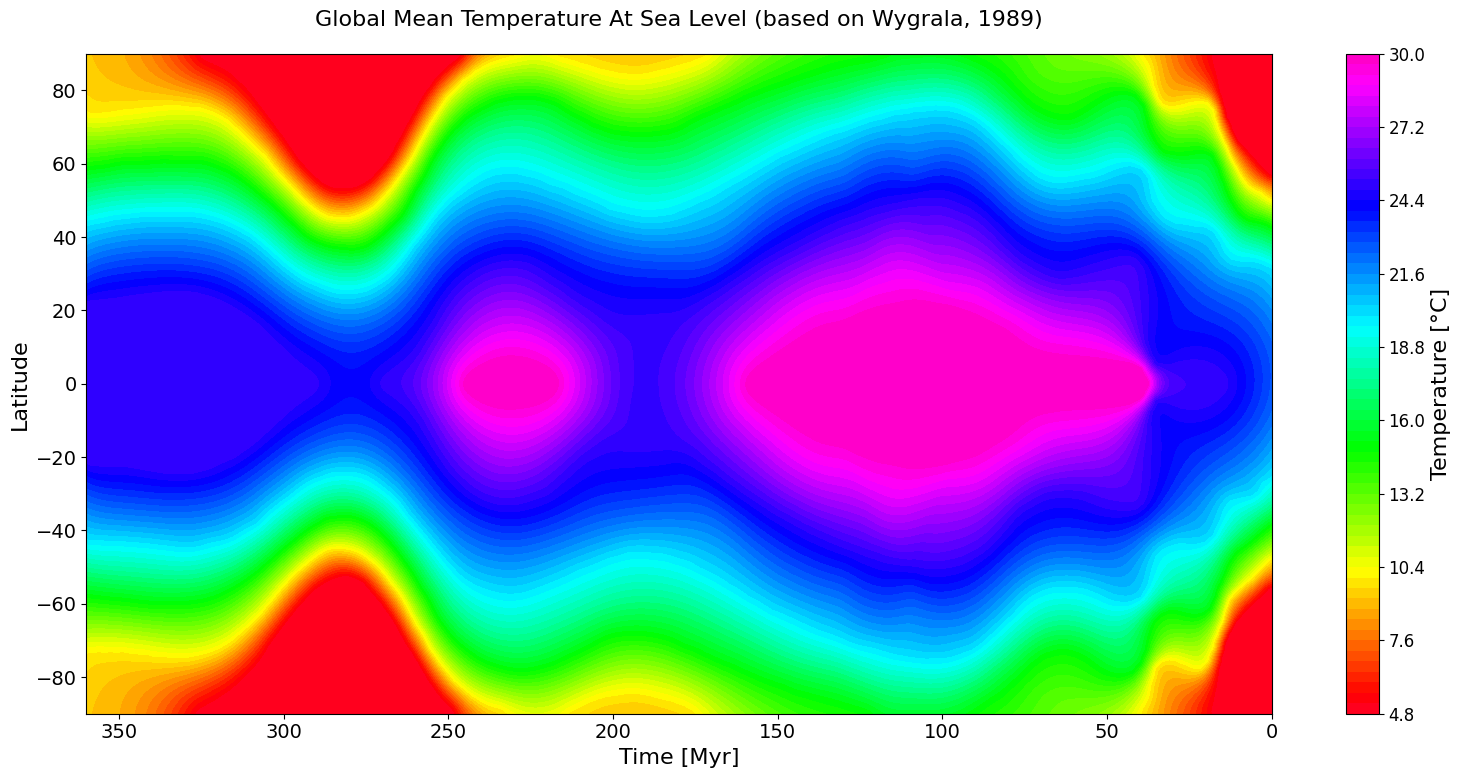

In [ ]:
Lon, Lat = np.meshgrid(longitude, latitude)

plt.figure(figsize=(16, 8))
contour = plt.contourf(Lon, Lat, data_values, cmap='gist_rainbow', levels=80)

cbar = plt.colorbar(contour, label="Temperature [°C]")
cbar.ax.tick_params(labelsize=12)  # Размер подписей на шкале
cbar.set_label("Temperature [°C]", fontsize=16)  # Размер заголовка шкалы

plt.xlabel("Time [Myr]", fontsize=16)
plt.ylabel("Latitude", fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.title("Global Mean Temperature At Sea Level (based on Wygrala, 1989)", fontsize=16, pad=20)

plt.gca().invert_xaxis()
# plt.grid(True, linestyle='--', alpha=0.5)

# Установка границ осей (xlim и ylim)
plt.xlim(left=360, right=0)  # Инверсия времени (100 млн лет назад → 0)
plt.ylim(bottom=-90, top=90)  # Широты от -90° (Южный полюс) до +90° (Северный полюс)

plt.tight_layout()  # Автоматическая подгонка отступов
plt.savefig('SWIT.tiff', format='tiff', dpi=300, bbox_inches='tight')
plt.show()

#### Global eustatic curve

In [ ]:
Database_Global_eustatic_curve.head(5)

Haq, 2005 (compiled)          Unnamed: 1  Unnamed: 2 Haq, 1987 (long)  \
0                 Time  Relative sea level         NaN             Time   
1                    0                   0         NaN                0   
2                  0.1            -0.92542         NaN              0.1   
3                  0.2            -0.81927         NaN              1.1   
4                  0.3            -0.71312         NaN              2.1   

           Unnamed: 4  Unnamed: 5 Haq, 1987 (short)          Unnamed: 7  \
0  Relative sea level         NaN              Time  Relative sea level   
1                  50         NaN                 0                   0   
2            56.70335         NaN               0.2            72.33343   
3            64.62095         NaN               0.3            78.56332   
4            71.95887         NaN               0.4             82.0459   

   Unnamed: 8 Watts, 1979  ... Unnamed: 40  Rescaled datasets used  \
0         NaN        Time  ...         NaN                    Time   
1         NaN           0  ...         NaN                       0   
2         NaN         0.1  ...         NaN                     0.1   
3         NaN         0.2  ...         NaN                     0.2   
4         NaN         0.3  ...         NaN                     0.3   

            Unnamed: 42       Unnamed: 43  Unnamed: 44  Unnamed: 45  \
0  Haq, 2005 (compiled)  Haq, 1987 (long)  Watts, 1979  Watts, 1984   
1                     0                50            0      -0.5001   
2              -0.92542          56.70335      -0.5288     -0.38433   
3              -0.81927          57.49511      -0.5285     -0.26856   
4              -0.71312          58.28687     -0.52819     -0.15279   

    Unnamed: 46  Unnamed: 47          Unnamed: 48             Unnamed: 49  
0  Pitman, 1978   Vail, 1978  Miller, 2005 (long)  Miller, 2008 (average)  
1      -0.10582            0                    0                      50  
2      -0.10552            0             -6.79067                54.92094  
3      -0.10522            0            -9.606015                54.92124  
4      -0.10491          0.0            -12.42136                54.92154  

[5 rows x 50 columns]

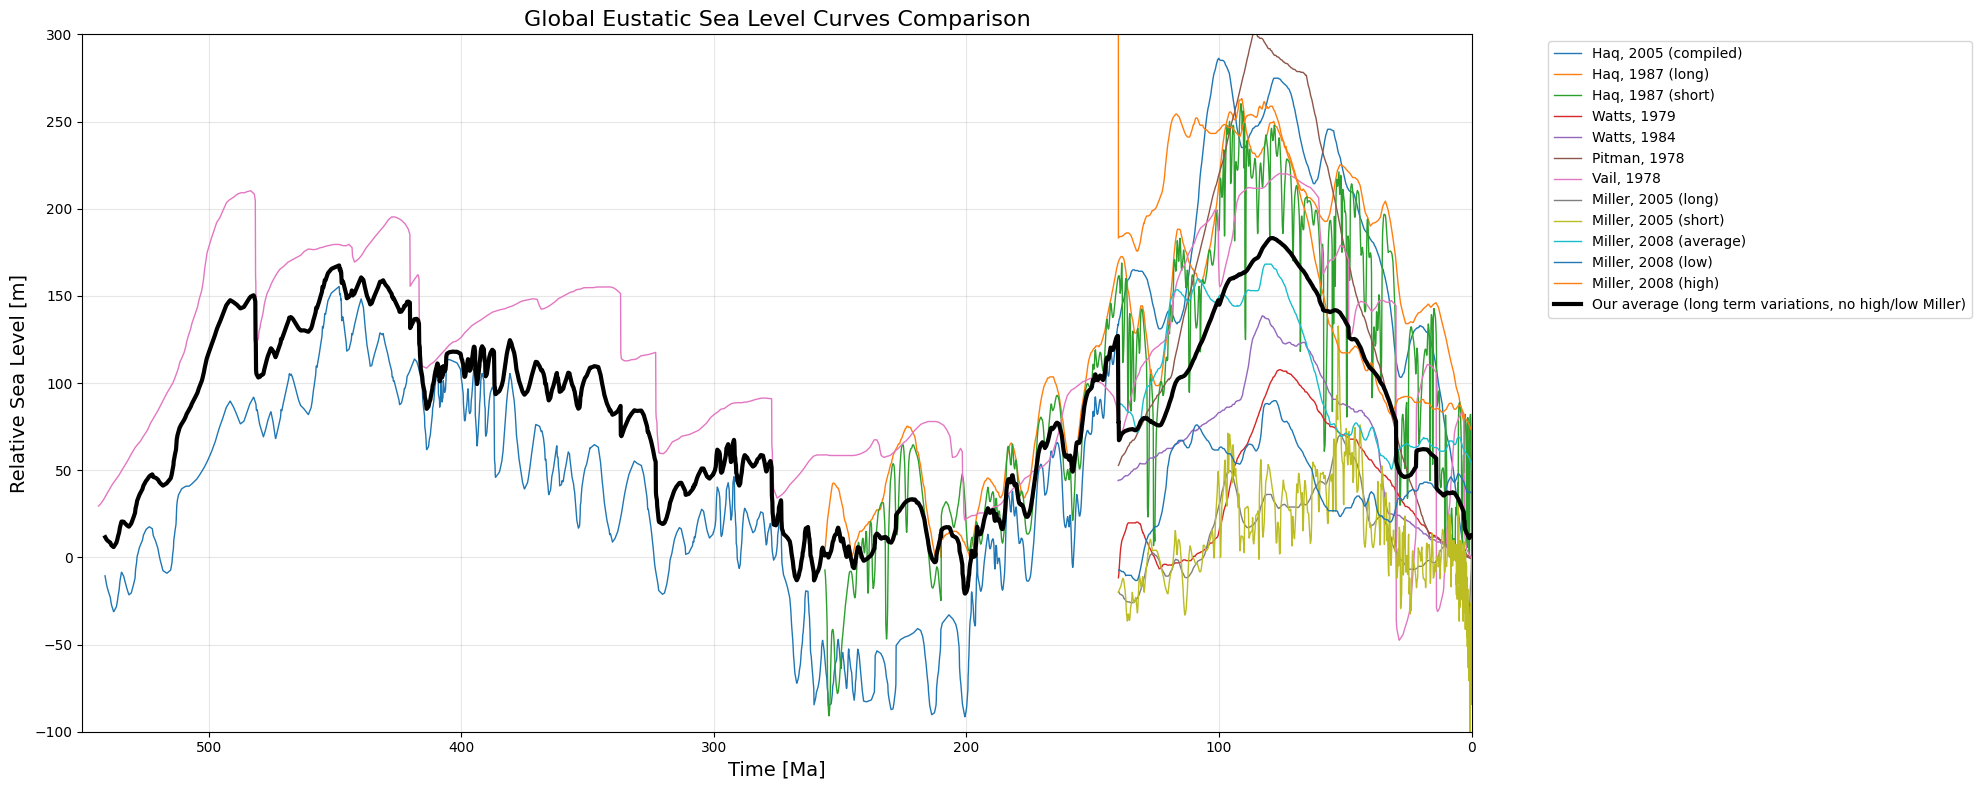

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = Database_Global_eustatic_curve

model_headers = [col for col in df.columns
                if not str(col).startswith('Unnamed')
                and "Rescaled datasets used" not in str(col)]
model_data = {}

for model in model_headers:
    start_col = df.columns.get_loc(model)

    # Extract data ensuring list format
    time = df.iloc[1:, start_col].dropna().astype(float).values
    sea_level = df.iloc[1:, start_col + 1].dropna().astype(float).values

    if len(time) == 0 or len(sea_level) == 0:
        continue

    model_df = pd.DataFrame({
        'Time': time.tolist(),
        'Relative sea level': sea_level.tolist()
    })

    if not model_df.empty:
        model_data[model] = model_df


plt.figure(figsize=(20, 8))
for model_name, data in model_data.items():
    plot_args = {
        'linewidth': 3 if "Our average" in model_name else 1,
        'color': 'black' if "Our average" in model_name else None,
        'label': model_name
    }
    plt.plot(data['Time'], data['Relative sea level'], **plot_args)


plt.xlabel('Time [Ma]', fontsize=14)
plt.ylabel('Relative Sea Level [m]', fontsize=14)
plt.title('Global Eustatic Sea Level Curves Comparison', fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim(0, 550)
plt.ylim(-100, 300)
plt.gca().invert_xaxis()
plt.tight_layout()
plt.show()

# Layers Subdivision

In [ ]:
# Кол-во слоев по которым будет проходит расчет.
# Не учитывает первый слой - Эрозию и последний - Фундамент
layers_quantity = len(df_well[1:df_well.shape[0]-1]) #amount of layers for calculation
layers_quantity

10

In [ ]:
# work_layers = df_well[1:df_well.shape[0]-1] ### Слои, по которым идет расчет
work_layers = df_well[1:df_well.shape[0]] ### Слои, по которым идет расчет
work_layers_initial = work_layers.copy()
work_layers_initial

Well Event_name  Event_type                      Lithology_type  \
1   Test_well   Layer 10     Erosion                     Shale (typical)   
2   Test_well    Layer 9  Deposition                 Sandstone (typical)   
3   Test_well    Layer 8  Deposition                     Shale (typical)   
4   Test_well    Layer 7  Deposition                     Chalk (typical)   
5   Test_well    Layer 6  Deposition                 Sandstone (typical)   
6   Test_well    Layer 5  Deposition  Limestone (organic rich - typical)   
7   Test_well    Layer 4  Deposition                  Dolomite (typical)   
8   Test_well    Layer 3  Deposition                 Sandstone (typical)   
9   Test_well    Layer 2  Deposition                           Anhydrite   
10  Test_well    Layer 1  Deposition                           Quartzite   
11  Test_well  Fundament  Deposition                                 NaN   

    Age (Ma)  Depth top, m  Depth bottom, m  Thickness, m  \
1          0          0.00             0.20           200   
2         45          0.20             0.45           250   
3         55          0.45             1.20           750   
4         80          1.20             2.50          1300   
5        100          2.50             3.40           900   
6        125          3.40             3.60           200   
7        145          3.60             4.00           400   
8        160          4.00             4.25           250   
9        210          4.25             5.00           750   
10       245          5.00             5.40           400   
11       260          5.40             5.40             0   

    D Thickness (erosion), m  Paleobathymetry, Ma  Sea level, m Sublayers  \
1                        NaN                  300             0        On   
2                        NaN                  325            40        On   
3                        NaN                  350            50        On   
4                        NaN                  300           100        On   
5                        NaN                  200            80        On   
6                        NaN                   20            70        On   
7                        NaN                   20           -40        On   
8                        NaN                   10           -20        On   
9                        NaN                   20             0        On   
10                       NaN                    0             0        On   
11                       NaN                  -20            10       NaN   

    N sublayers          PSE                     Kinetic  TOC initial, %  \
1           0.0          NaN                         NaN             NaN   
2           0.0          NaN                         NaN             NaN   
3           0.0          NaN                         NaN             NaN   
4           0.0          NaN                         NaN             NaN   
5           0.0          NaN                         NaN             NaN   
6           0.0  Source Rock  Tegelaar(1994)_TI-S(Spain)            10.0   
7           0.0          NaN                         NaN             NaN   
8           0.0          NaN                         NaN             NaN   
9           0.0          NaN                         NaN             NaN   
10          0.0          NaN                         NaN             NaN   
11          NaN          NaN                         NaN             NaN   

    HI initial, %  
1             NaN  
2             NaN  
3             NaN  
4             NaN  
5             NaN  
6           100.0  
7             NaN  
8             NaN  
9             NaN  
10            NaN  
11            NaN

In [ ]:
work_layers['Sublayers'] = 'On'
work_layers['N sublayers'] = int(1)
# work_layers.loc[work_layers['Event_name'] == 'Layer 7', 'Sublayers'] = 'On'
# work_layers.loc[work_layers['Event_name'] == 'Layer 7', 'N sublayers'] = int(1)

<ipython-input-27-0466dcd079e0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  work_layers['Sublayers'] = 'On'
<ipython-input-27-0466dcd079e0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  work_layers['N sublayers'] = int(1)


In [ ]:
work_layers[0:]

Well Event_name  Event_type                      Lithology_type  \
1   Test_well   Layer 10     Erosion                     Shale (typical)   
2   Test_well    Layer 9  Deposition                 Sandstone (typical)   
3   Test_well    Layer 8  Deposition                     Shale (typical)   
4   Test_well    Layer 7  Deposition                     Chalk (typical)   
5   Test_well    Layer 6  Deposition                 Sandstone (typical)   
6   Test_well    Layer 5  Deposition  Limestone (organic rich - typical)   
7   Test_well    Layer 4  Deposition                  Dolomite (typical)   
8   Test_well    Layer 3  Deposition                 Sandstone (typical)   
9   Test_well    Layer 2  Deposition                           Anhydrite   
10  Test_well    Layer 1  Deposition                           Quartzite   
11  Test_well  Fundament  Deposition                                 NaN   

    Age (Ma)  Depth top, m  Depth bottom, m  Thickness, m  \
1          0          0.00             0.20           200   
2         45          0.20             0.45           250   
3         55          0.45             1.20           750   
4         80          1.20             2.50          1300   
5        100          2.50             3.40           900   
6        125          3.40             3.60           200   
7        145          3.60             4.00           400   
8        160          4.00             4.25           250   
9        210          4.25             5.00           750   
10       245          5.00             5.40           400   
11       260          5.40             5.40             0   

    D Thickness (erosion), m  Paleobathymetry, Ma  Sea level, m Sublayers  \
1                        NaN                  300             0        On   
2                        NaN                  325            40        On   
3                        NaN                  350            50        On   
4                        NaN                  300           100        On   
5                        NaN                  200            80        On   
6                        NaN                   20            70        On   
7                        NaN                   20           -40        On   
8                        NaN                   10           -20        On   
9                        NaN                   20             0        On   
10                       NaN                    0             0        On   
11                       NaN                  -20            10        On   

    N sublayers          PSE                     Kinetic  TOC initial, %  \
1             1          NaN                         NaN             NaN   
2             1          NaN                         NaN             NaN   
3             1          NaN                         NaN             NaN   
4             1          NaN                         NaN             NaN   
5             1          NaN                         NaN             NaN   
6             1  Source Rock  Tegelaar(1994)_TI-S(Spain)            10.0   
7             1          NaN                         NaN             NaN   
8             1          NaN                         NaN             NaN   
9             1          NaN                         NaN             NaN   
10            1          NaN                         NaN             NaN   
11            1          NaN                         NaN             NaN   

    HI initial, %  
1             NaN  
2             NaN  
3             NaN  
4             NaN  
5             NaN  
6           100.0  
7             NaN  
8             NaN  
9             NaN  
10            NaN  
11            NaN

In [ ]:
# filtered_df = df_well[df_well['Event_name'] != 'Erosion']

In [ ]:
df_well.iloc[-1]

Well                         Test_well
Event_name                   Fundament
Event_type                  Deposition
Lithology_type                     NaN
Age (Ma)                           260
Depth top, m                       5.4
Depth bottom, m                    5.4
Thickness, m                         0
D Thickness (erosion), m           NaN
Paleobathymetry, Ma                -20
Sea level, m                        10
Sublayers                          NaN
N sublayers                        NaN
PSE                                NaN
Kinetic                            NaN
TOC initial, %                     NaN
HI initial, %                      NaN
Name: 11, dtype: object

In [ ]:
def layers_subdivision(work_layers, on=True):

  df_repeated = pd.DataFrame()

  if on == False:
    return work_layers

  else:

    result_df = pd.DataFrame()
    work_layers_copy = work_layers[0:].copy()

    for index, row in work_layers_copy.iterrows():
        if not pd.isnull(row['N sublayers']):
            # Calculate the interval value
            print(row['Depth bottom, m'], row['Depth top, m'], int(row['N sublayers']))
            interval = (row['Depth bottom, m'] - row['Depth top, m']) / int(row['N sublayers'])
            interval_thickness = row['Thickness, m'] / (int(row['N sublayers']))

            interval_age = 0
            next_index = index + 1
            if next_index < len(work_layers_copy):
              next_row = work_layers_copy.loc[next_index]
              interval_age = (next_row['Age (Ma)'] - row['Age (Ma)']) / (int(row['N sublayers']))
            else:
              last_row= df_well.iloc[-1]
              next_row = last_row
              interval_age = (next_row['Age (Ma)'] - row['Age (Ma)']) / (int(row['N sublayers']))

            # Repeat the row 'div' times and append to the new DataFrame
            repeated_rows = [row.copy() for _ in range(int(row['N sublayers']))]
            for i, r in enumerate(repeated_rows):
                r['Event_name'] = row['Event_name'] + f'_{i+1}'
                r['Depth top, m'] = row['Depth top, m'] + i * interval
                r['Depth bottom, m'] = row['Depth top, m'] + (i + 1) * interval
                r['Thickness, m'] = interval_thickness
                r['Age (Ma)'] = row['Age (Ma)'] + i*interval_age
            df_repeated = pd.concat([df_repeated, pd.DataFrame(repeated_rows)], ignore_index=True)
        else:
            df_repeated = pd.concat([df_repeated, pd.DataFrame([row])], ignore_index=True)

    return df_repeated

In [ ]:
work_layers = layers_subdivision(work_layers, on=True)
# work_layers = layers_subdivision(work_layers, on=True)
###
  # on = True make subdivision
###

0.2 0.0 1
0.45 0.2 1
1.2 0.45 1
2.5 1.2 1
3.4 2.5 1
3.6 3.4 1
4.0 3.6 1
4.25 4.0 1
5.0 4.25 1
5.4 5.0 1
5.4 5.4 1


In [ ]:
work_layers_copy_initial = work_layers.copy()

In [ ]:
work_layers_copy_initial

Well   Event_name  Event_type                      Lithology_type  \
0   Test_well   Layer 10_1     Erosion                     Shale (typical)   
1   Test_well    Layer 9_1  Deposition                 Sandstone (typical)   
2   Test_well    Layer 8_1  Deposition                     Shale (typical)   
3   Test_well    Layer 7_1  Deposition                     Chalk (typical)   
4   Test_well    Layer 6_1  Deposition                 Sandstone (typical)   
5   Test_well    Layer 5_1  Deposition  Limestone (organic rich - typical)   
6   Test_well    Layer 4_1  Deposition                  Dolomite (typical)   
7   Test_well    Layer 3_1  Deposition                 Sandstone (typical)   
8   Test_well    Layer 2_1  Deposition                           Anhydrite   
9   Test_well    Layer 1_1  Deposition                           Quartzite   
10  Test_well  Fundament_1  Deposition                                 NaN   

    Age (Ma)  Depth top, m  Depth bottom, m  Thickness, m  \
0        0.0          0.00             0.20         200.0   
1       45.0          0.20             0.45         250.0   
2       55.0          0.45             1.20         750.0   
3       80.0          1.20             2.50        1300.0   
4      100.0          2.50             3.40         900.0   
5      125.0          3.40             3.60         200.0   
6      145.0          3.60             4.00         400.0   
7      160.0          4.00             4.25         250.0   
8      210.0          4.25             5.00         750.0   
9      245.0          5.00             5.40         400.0   
10     260.0          5.40             5.40           0.0   

    D Thickness (erosion), m  Paleobathymetry, Ma  Sea level, m Sublayers  \
0                        NaN                  300             0        On   
1                        NaN                  325            40        On   
2                        NaN                  350            50        On   
3                        NaN                  300           100        On   
4                        NaN                  200            80        On   
5                        NaN                   20            70        On   
6                        NaN                   20           -40        On   
7                        NaN                   10           -20        On   
8                        NaN                   20             0        On   
9                        NaN                    0             0        On   
10                       NaN                  -20            10        On   

    N sublayers          PSE                     Kinetic  TOC initial, %  \
0             1          NaN                         NaN             NaN   
1             1          NaN                         NaN             NaN   
2             1          NaN                         NaN             NaN   
3             1          NaN                         NaN             NaN   
4             1          NaN                         NaN             NaN   
5             1  Source Rock  Tegelaar(1994)_TI-S(Spain)            10.0   
6             1          NaN                         NaN             NaN   
7             1          NaN                         NaN             NaN   
8             1          NaN                         NaN             NaN   
9             1          NaN                         NaN             NaN   
10            1          NaN                         NaN             NaN   

    HI initial, %  
0             NaN  
1             NaN  
2             NaN  
3             NaN  
4             NaN  
5           100.0  
6             NaN  
7             NaN  
8             NaN  
9             NaN  
10            NaN

### Lithology

In [ ]:
df_well["Lithology_type"].tolist()

[nan,
 'Shale (typical)',
 'Sandstone (typical)',
 'Shale (typical)',
 'Chalk (typical)',
 'Sandstone (typical)',
 'Limestone (organic rich - typical)',
 'Dolomite (typical)',
 'Sandstone (typical)',
 'Anhydrite',
 'Quartzite',
 nan]

In [ ]:
lithology_numbers = {30000: {'lith':'Sandstone (typical)', 'lith_num':1, 'hatch': '..', 'color':'#ffff00'},
                 65030: {'lith':'Sandstone (typical)', 'lith_num':2, 'hatch':'-.', 'color':'#ffe119'},
                 65000: {'lith':'Shale (typical)', 'lith_num':3, 'hatch':'-.. ', 'color':'#bebebe'},
                 80000: {'lith':'Marl', 'lith_num':4, 'hatch':'', 'color':'#7cfc00'},
                 74000: {'lith':'Dolomite (typical)', 'lith_num':5, 'hatch':'-\\', 'color':'blue'},
                 70000: {'lith':'Limestone (organic rich - typical)', 'lith_num':6, 'hatch':'+', 'color':'#80ffff'},
                 70032: {'lith':'Chalk (typical)', 'lith_num':7, 'hatch':'..', 'color':'#80ffff'},
                 88000: {'lith':'Halite', 'lith_num':8, 'hatch':'x', 'color':'#7ddfbe'},
                 86000: {'lith':'Anhydrite', 'lith_num':9, 'hatch':'-/', 'color':'#ff80ff'},
                 99000: {'lith':'Tuff', 'lith_num':10, 'hatch':'||', 'color':'#ff8c00'},
                 90000: {'lith':'Quartzite', 'lith_num':11, 'hatch':'oo', 'color':'#ffe119'},
                 93000: {'lith':'nan', 'lith_num':12, 'hatch':'-|', 'color':'#ef138a'}}

In [ ]:
# lithology_numbers = {30000: {'lith':'Sandstones', 'lith_num':1, 'hatch': '..', 'color':'#ffff00'},
#                  65030: {'lith':'Sandstone/Shale', 'lith_num':2, 'hatch':'-.', 'color':'#ffe119'},
#                  65000: {'lith':'Shales', 'lith_num':3, 'hatch':'-.. ', 'color':'#bebebe'},
#                  80000: {'lith':'Marl', 'lith_num':4, 'hatch':'', 'color':'#7cfc00'},
#                  74000: {'lith':'Dolomite', 'lith_num':5, 'hatch':'-\\', 'color':'blue'},
#                  70000: {'lith':'Limestones', 'lith_num':6, 'hatch':'+', 'color':'#80ffff'},
#                  70032: {'lith':'Chalk', 'lith_num':7, 'hatch':'..', 'color':'#80ffff'},
#                  88000: {'lith':'Halite', 'lith_num':8, 'hatch':'x', 'color':'#7ddfbe'},
#                  86000: {'lith':'Anhydrite', 'lith_num':9, 'hatch':'-/', 'color':'#ff80ff'},
#                  99000: {'lith':'Tuff', 'lith_num':10, 'hatch':'||', 'color':'#ff8c00'},
#                  90000: {'lith':'Quartzite', 'lith_num':11, 'hatch':'oo', 'color':'#ffe119'},
#                  93000: {'lith':'nan', 'lith_num':12, 'hatch':'-|', 'color':'#ef138a'}}

In [ ]:
df_lith = pd.DataFrame.from_dict(lithology_numbers, orient='index')
df_lith.reset_index(inplace=True)

df_lith

index                                lith  lith_num hatch    color
0   30000                 Sandstone (typical)         1    ..  #ffff00
1   65030                 Sandstone (typical)         2    -.  #ffe119
2   65000                     Shale (typical)         3  -..   #bebebe
3   80000                                Marl         4        #7cfc00
4   74000                  Dolomite (typical)         5    -\     blue
5   70000  Limestone (organic rich - typical)         6     +  #80ffff
6   70032                     Chalk (typical)         7    ..  #80ffff
7   88000                              Halite         8     x  #7ddfbe
8   86000                           Anhydrite         9    -/  #ff80ff
9   99000                                Tuff        10    ||  #ff8c00
10  90000                           Quartzite        11    oo  #ffe119
11  93000                                 nan        12    -|  #ef138a

In [ ]:
lithology_array = []
hatch_array = []
color_array = []

for row_index, row in enumerate(work_layers.itertuples()):

    lithology = work_layers.at[row.Index, 'Lithology_type']
    layers_name = work_layers.at[row.Index, 'Event_name']
    # print(lithology)

    lit_num = df_lith.loc[df_lith['lith'] == str(lithology), 'index'].iloc[0]
    lithology_array.append(lit_num)


    hatch_val = df_lith.loc[df_lith['lith'] == str(lithology), 'hatch'].iloc[0]
    hatch_array.append(hatch_val)

    color_val = df_lith.loc[df_lith['lith'] == str(lithology), 'color'].iloc[0]
    color_array.append(color_val)

work_layers_initial["Lithology"] = lithology_array
work_layers_initial["Index"] = hatch_array
work_layers_initial["Color"] = color_array
work_layers_initial # для построения графиков с литологией

Well Event_name  Event_type                      Lithology_type  \
1   Test_well   Layer 10     Erosion                     Shale (typical)   
2   Test_well    Layer 9  Deposition                 Sandstone (typical)   
3   Test_well    Layer 8  Deposition                     Shale (typical)   
4   Test_well    Layer 7  Deposition                     Chalk (typical)   
5   Test_well    Layer 6  Deposition                 Sandstone (typical)   
6   Test_well    Layer 5  Deposition  Limestone (organic rich - typical)   
7   Test_well    Layer 4  Deposition                  Dolomite (typical)   
8   Test_well    Layer 3  Deposition                 Sandstone (typical)   
9   Test_well    Layer 2  Deposition                           Anhydrite   
10  Test_well    Layer 1  Deposition                           Quartzite   
11  Test_well  Fundament  Deposition                                 NaN   

    Age (Ma)  Depth top, m  Depth bottom, m  Thickness, m  \
1          0          0.00             0.20           200   
2         45          0.20             0.45           250   
3         55          0.45             1.20           750   
4         80          1.20             2.50          1300   
5        100          2.50             3.40           900   
6        125          3.40             3.60           200   
7        145          3.60             4.00           400   
8        160          4.00             4.25           250   
9        210          4.25             5.00           750   
10       245          5.00             5.40           400   
11       260          5.40             5.40             0   

    D Thickness (erosion), m  Paleobathymetry, Ma  Sea level, m Sublayers  \
1                        NaN                  300             0        On   
2                        NaN                  325            40        On   
3                        NaN                  350            50        On   
4                        NaN                  300           100        On   
5                        NaN                  200            80        On   
6                        NaN                   20            70        On   
7                        NaN                   20           -40        On   
8                        NaN                   10           -20        On   
9                        NaN                   20             0        On   
10                       NaN                    0             0        On   
11                       NaN                  -20            10       NaN   

    N sublayers          PSE                     Kinetic  TOC initial, %  \
1           0.0          NaN                         NaN             NaN   
2           0.0          NaN                         NaN             NaN   
3           0.0          NaN                         NaN             NaN   
4           0.0          NaN                         NaN             NaN   
5           0.0          NaN                         NaN             NaN   
6           0.0  Source Rock  Tegelaar(1994)_TI-S(Spain)            10.0   
7           0.0          NaN                         NaN             NaN   
8           0.0          NaN                         NaN             NaN   
9           0.0          NaN                         NaN             NaN   
10          0.0          NaN                         NaN             NaN   
11          NaN          NaN                         NaN             NaN   

    HI initial, %  Lithology Index    Color  
1             NaN      65000  -..   #bebebe  
2             NaN      30000    ..  #ffff00  
3             NaN      65000  -..   #bebebe  
4             NaN      70032    ..  #80ffff  
5             NaN      30000    ..  #ffff00  
6           100.0      70000     +  #80ffff  
7             NaN      74000    -\     blue  
8             NaN      30000    ..  #ffff00  
9             NaN      86000    -/  #ff80ff  
10            NaN      90000    oo  #ffe119  
11            NaN  

In [ ]:
work_layers

Well   Event_name  Event_type                      Lithology_type  \
0   Test_well   Layer 10_1     Erosion                     Shale (typical)   
1   Test_well    Layer 9_1  Deposition                 Sandstone (typical)   
2   Test_well    Layer 8_1  Deposition                     Shale (typical)   
3   Test_well    Layer 7_1  Deposition                     Chalk (typical)   
4   Test_well    Layer 6_1  Deposition                 Sandstone (typical)   
5   Test_well    Layer 5_1  Deposition  Limestone (organic rich - typical)   
6   Test_well    Layer 4_1  Deposition                  Dolomite (typical)   
7   Test_well    Layer 3_1  Deposition                 Sandstone (typical)   
8   Test_well    Layer 2_1  Deposition                           Anhydrite   
9   Test_well    Layer 1_1  Deposition                           Quartzite   
10  Test_well  Fundament_1  Deposition                                 NaN   

    Age (Ma)  Depth top, m  Depth bottom, m  Thickness, m  \
0        0.0          0.00             0.20         200.0   
1       45.0          0.20             0.45         250.0   
2       55.0          0.45             1.20         750.0   
3       80.0          1.20             2.50        1300.0   
4      100.0          2.50             3.40         900.0   
5      125.0          3.40             3.60         200.0   
6      145.0          3.60             4.00         400.0   
7      160.0          4.00             4.25         250.0   
8      210.0          4.25             5.00         750.0   
9      245.0          5.00             5.40         400.0   
10     260.0          5.40             5.40           0.0   

    D Thickness (erosion), m  Paleobathymetry, Ma  Sea level, m Sublayers  \
0                        NaN                  300             0        On   
1                        NaN                  325            40        On   
2                        NaN                  350            50        On   
3                        NaN                  300           100        On   
4                        NaN                  200            80        On   
5                        NaN                   20            70        On   
6                        NaN                   20           -40        On   
7                        NaN                   10           -20        On   
8                        NaN                   20             0        On   
9                        NaN                    0             0        On   
10                       NaN                  -20            10        On   

    N sublayers          PSE                     Kinetic  TOC initial, %  \
0             1          NaN                         NaN             NaN   
1             1          NaN                         NaN             NaN   
2             1          NaN                         NaN             NaN   
3             1          NaN                         NaN             NaN   
4             1          NaN                         NaN             NaN   
5             1  Source Rock  Tegelaar(1994)_TI-S(Spain)            10.0   
6             1          NaN                         NaN             NaN   
7             1          NaN                         NaN             NaN   
8             1          NaN                         NaN             NaN   
9             1          NaN                         NaN             NaN   
10            1          NaN                         NaN             NaN   

    HI initial, %  
0             NaN  
1             NaN  
2             NaN  
3             NaN  
4             NaN  
5           100.0  
6             NaN  
7             NaN  
8             NaN  
9             NaN  
10            NaN

In [ ]:
lithology_array = []
hatch_array = []
color_array = []

for row_index, row in enumerate(work_layers_initial.itertuples()):

    lithology = work_layers_initial.at[row.Index, 'Lithology_type']
    layers_name = work_layers_initial.at[row.Index, 'Event_name']
    # print(lithology)

    lit_num = df_lith.loc[df_lith['lith'] == str(lithology), 'index'].iloc[0]
    lithology_array.append(lit_num)


    hatch_val = df_lith.loc[df_lith['lith'] == str(lithology), 'hatch'].iloc[0]
    hatch_array.append(hatch_val)

    color_val = df_lith.loc[df_lith['lith'] == str(lithology), 'color'].iloc[0]
    color_array.append(color_val)

work_layers["Lithology"] = lithology_array
work_layers["Index"] = hatch_array
work_layers["Color"] = color_array
work_layers_with_color = work_layers.copy()
work_layers

Well   Event_name  Event_type                      Lithology_type  \
0   Test_well   Layer 10_1     Erosion                     Shale (typical)   
1   Test_well    Layer 9_1  Deposition                 Sandstone (typical)   
2   Test_well    Layer 8_1  Deposition                     Shale (typical)   
3   Test_well    Layer 7_1  Deposition                     Chalk (typical)   
4   Test_well    Layer 6_1  Deposition                 Sandstone (typical)   
5   Test_well    Layer 5_1  Deposition  Limestone (organic rich - typical)   
6   Test_well    Layer 4_1  Deposition                  Dolomite (typical)   
7   Test_well    Layer 3_1  Deposition                 Sandstone (typical)   
8   Test_well    Layer 2_1  Deposition                           Anhydrite   
9   Test_well    Layer 1_1  Deposition                           Quartzite   
10  Test_well  Fundament_1  Deposition                                 NaN   

    Age (Ma)  Depth top, m  Depth bottom, m  Thickness, m  \
0        0.0          0.00             0.20         200.0   
1       45.0          0.20             0.45         250.0   
2       55.0          0.45             1.20         750.0   
3       80.0          1.20             2.50        1300.0   
4      100.0          2.50             3.40         900.0   
5      125.0          3.40             3.60         200.0   
6      145.0          3.60             4.00         400.0   
7      160.0          4.00             4.25         250.0   
8      210.0          4.25             5.00         750.0   
9      245.0          5.00             5.40         400.0   
10     260.0          5.40             5.40           0.0   

    D Thickness (erosion), m  Paleobathymetry, Ma  Sea level, m Sublayers  \
0                        NaN                  300             0        On   
1                        NaN                  325            40        On   
2                        NaN                  350            50        On   
3                        NaN                  300           100        On   
4                        NaN                  200            80        On   
5                        NaN                   20            70        On   
6                        NaN                   20           -40        On   
7                        NaN                   10           -20        On   
8                        NaN                   20             0        On   
9                        NaN                    0             0        On   
10                       NaN                  -20            10        On   

    N sublayers          PSE                     Kinetic  TOC initial, %  \
0             1          NaN                         NaN             NaN   
1             1          NaN                         NaN             NaN   
2             1          NaN                         NaN             NaN   
3             1          NaN                         NaN             NaN   
4             1          NaN                         NaN             NaN   
5             1  Source Rock  Tegelaar(1994)_TI-S(Spain)            10.0   
6             1          NaN                         NaN             NaN   
7             1          NaN                         NaN             NaN   
8             1          NaN                         NaN             NaN   
9             1          NaN                         NaN             NaN   
10            1          NaN                         NaN             NaN   

    HI initial, %  Lithology Index    Color  
0             NaN      65000  -..   #bebebe  
1             NaN      30000    ..  #ffff00  
2             NaN      65000  -..   #bebebe  
3             NaN      70032    ..  #80ffff  
4             NaN      30000    ..  #ffff00  
5           100.0      70000     +  #80ffff  
6             NaN      74000    -\     blue  
7             NaN      30000    ..  #ffff00  
8             NaN      86000    -/  #ff80ff  
9             NaN      90000    oo  #ffe1

<ipython-input-42-bc10ea4551a3>:14: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error in 3.11.
  ax.fill_betweenx(y, 0, 1, facecolor='none',


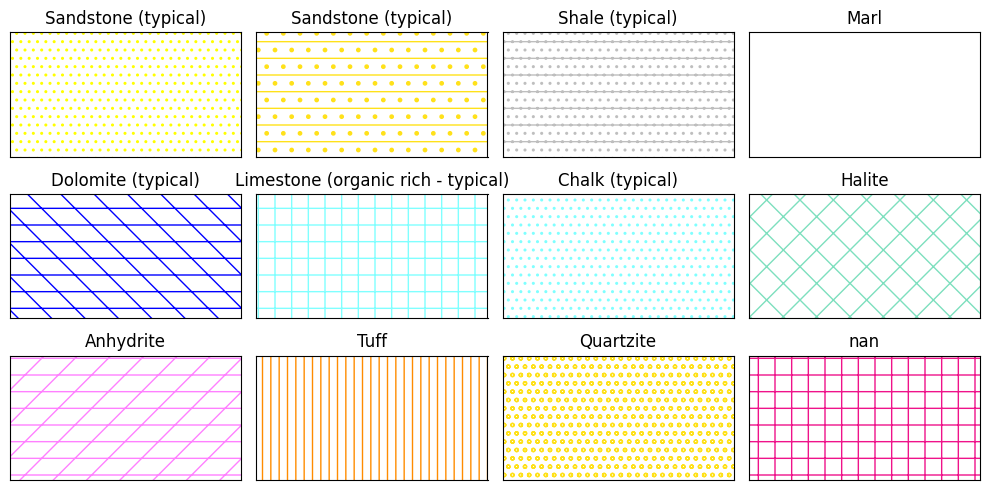

In [ ]:
y = [0, 1]
x = [1, 1]

fig, axes = plt.subplots(ncols=4,nrows=3, sharex=True, sharey=True,
                         figsize=(10,5), subplot_kw={'xticks': [], 'yticks': []})

for ax, key in zip(axes.flat, lithology_numbers.keys()):
  ax.plot(x, y)
  if lithology_numbers[key]['lith'] == 'Shales':
    ax.fill_betweenx(y, 0, 1, facecolor='none', edgecolor='gray', hatch='_-_')

  else:
      # ax.fill_betweenx(y, 0, 1, facecolor=lithology_numbers[key]['color'], hatch=lithology_numbers[key]['hatch'])
    ax.fill_betweenx(y, 0, 1, facecolor='none',
                    edgecolor=lithology_numbers[key]['color'],         # Hatch color
                    hatch=lithology_numbers[key]['hatch'],  # e.g., '--', '..', 'xx'
                    linewidth=0.5              # Controls hatch thickness
  )

  ax.set_xlim(0, 0.1)
  ax.set_ylim(0, 1)
  ax.set_title(str(lithology_numbers[key]['lith']))

plt.tight_layout()

plt.show()

## Decompacted Thickness, Porosity \& Permeability, Density



Step 1. Decompaction (decompacted thickness).

Step 2. Correction for paleobathymetry and eustasy (Decompacted depth with corrction).

Step 3. Removal effect of sediment load (porosity, permeability density).




In [ ]:
import numpy as np
from scipy.special import lambertw

def decomp_func(y1, y2, y1_d, phi, c):  # возвращает фун-ию одной переменной, для которой затем подбирается параметр y2_d

    y2_d = (np.exp(-np.log(e) * y1_d * c) * phi * np.log(e) - \
            np.exp(-np.log(e) * y1 * c) * phi * np.log(e) + \
            np.exp(-np.log(e) * y2 * c) * phi * np.log(e) - \
            np.log(e) * y1 * c + np.log(e) * y1_d * c + np.log(e) * y2 * c + \
            lambertw(-np.log(e) * phi * np.exp(-np.exp(-np.log(e) * y1_d * c) * phi * np.log(e) +\
                                               np.exp(-np.log(e) * y1 * c) * phi * np.log(e) - \
                                               np.exp(-np.log(e) * y2 * c) * phi * np.log(e) + \
                                               np.log(e) * y1 * c - \
                                               np.log(e) * y1_d * c - np.log(e) * y2 * c))) / c / np.log(e)
    return y2_d.real

In [ ]:
#считает скорректированную декомпактированную глубину
def corrected(depth, RoMantle, RoWater, sea_level, sea_level_today):
  return depth - sea_level_today * (RoWater / (RoMantle - RoWater)) + (sea_level - sea_level_today)

In [ ]:
### the average porosity of a stratigraphic unit at any depth [A.58.6]
def porosity_func(surface_porosity, exp_decay, y1, y2, thicknesses):
  return surface_porosity/exp_decay*((np.exp(-exp_decay*y1) - np.exp(-exp_decay*y2))/thicknesses)

In [ ]:
def bulk_density(porosity, RoGrain, RoWater):
  return porosity*RoWater + (1-porosity)*RoGrain

In [ ]:
def bulk_density_column(porosity, RoGrain, RoWater):
  return porosity*RoWater + (1-porosity)*RoGrain

In [ ]:
def tectonic_subsidence (RoMantle, RoWater, RoColumn, depth):
  return depth*((RoMantle-RoColumn)/(RoMantle-RoWater))

In [ ]:
def Kozeny_Carman(r, phi, tau):
    return r**2 * phi / (8 * tau**2)

def Kozeny_Carman_lithology(phi, S, k):
    phi_corrected = phi - 3.1 * 10e-10
    if phi_corrected < 0.1:
        return 2 * 10**16 * k * (phi_corrected**5 / (S**2 * (1 - phi_corrected)**2))
    else:
        return 2 * 10**14 * k * (phi_corrected**3 / (S**2 * (1 - phi_corrected)**2))

In [ ]:
def sedimentaiton_rate(depth, years):
  return depth / (age if age != 0 else 1e20)

In [ ]:
def hydrostatic_pressures(depths, sea_level, sediment_surface, water_depth, rho_water=1040):

    """
    Calculate cumulative hydrostatic pressures for each layer.

    Parameters:
    - depths: List or array of bottom depth of each layer (m)
    - water_depth: Depth of water (m)
    - sediment_surface: Depth of sediment surface (m)
    - rho_water: Constant value of sea water density (kg/m^3)

    Returns:
    - List of cumulative pressures (MPa) for each layer and depth array
    """

    g = 9.81  # acceleration due to gravity in m/s^2
    pressures = [quad(lambda z: rho_water * g, sea_level, depth)[0] / 1e6 for depth in depths]  # Convert Pa to MPa

    return pressures

In [ ]:
def lithostatic_pressures(layer_bottom_depth, rock_densities, porosities, sea_level,
                          water_depth, sediment_surface):
    """
    Calculate cumulative lithostatic pressures for each layer.

    Parameters:
    - layer_thicknesses: List or array of thicknesses of each layer (m)
    - rock_densities: List or array of densities of each rock layer (kg/m^3)
    - porosities: List or array of porosity values for each layer (fraction)
    - water_depth: Constant value of a water depth (m)

    Returns:
    - List of cumulative pressures (MPa) for each layer
    """
    g = 9.81  # acceleration due to gravity in m/s^2
    rho_sea = 1100
    pressures = []
    total_depth = 0
    total_pressure = 0

    if sediment_surface < 0:

      filtered_depths = np.insert(layer_bottom_depth, 0, sediment_surface)
      rock_densities = np.insert(rock_densities, 0, 0)
      porosities = np.insert(porosities, 0, 0)    # Add sediment porosity at the start


      for depth, density, porosity in zip(filtered_depths, rock_densities, porosities):
        total_pressure = 0
        effective_density = density * (1 - porosity) + rho_sea*porosity

        water_pressure = rho_sea * g * water_depth
        pressure_increment = quad(lambda z: effective_density * g, sediment_surface, depth)[0]
        total_pressure += water_pressure
        total_pressure += pressure_increment

        pressures.append((total_pressure) / 1e6)  # Convert Pa to MPa

      return pressures

    else:

      filtered_depths = [depth for depth in layer_bottom_depth if depth > sediment_surface]
      filtered_depths.insert(0, sediment_surface)

      for depth, density, porosity in zip(filtered_depths, rock_densities, porosities):

          total_pressure = 0
          effective_density = density * (1 - porosity) + rho_sea*porosity

          water_pressure = rho_sea * g * water_depth
          pressure_increment = quad(lambda z: effective_density * g, sediment_surface, depth)[0]
          total_pressure += water_pressure
          total_pressure += pressure_increment

          pressures.append((total_pressure) / 1e6)  # Convert Pa to MPa

      return pressures

In [ ]:
# initial_depth_values = []

# decompaction_df = pd.DataFrame() ### <-- Decompacted thicknesses (km). Table A58.3
# decompaction_corrected_df = pd.DataFrame() ### <-- Decompacted thicknesses (km). Table A58.4
# porosity_df = pd.DataFrame() ### <-- Porosities as a function of time for 10 lithological units undergoing progressive compaction during burial.
#                             ### Table A58.4
# density_df = pd.DataFrame()
# density_column_df = pd.DataFrame()


# age_list = list(work_layers['Age (Ma)'])
# print(age_list)
# # age_list.append(list(df_well['Age (Ma)'])[-1])
# # print(age_list)


# for i, age in enumerate(age_list, start=0):

#     work_layers_copy = work_layers.copy()

#     thinkness_list = []
#     thinkness_corrected_list = []
#     porosity_average_list = []
#     porosity_test = []
#     density_list = []
#     density_column = []
#     density_column_total = []


#     print('Age', i, age)

#     RoWater, RoMantle = 1000, 3300

# ### расчет corrected_decompaction for Fundament (not in work_layer)
#     if int(age) == age_list[-1]:
#       depth = 0
#       y2_d_corrected = abs(np.round(corrected(depth, RoMantle, RoWater, sea_level, sea_level_today), 3))
#       thinkness_corrected_list.append(y2_d_corrected)

# ### расчет для слоев с заданной литологией (work_layers)
#     for row_index, row in enumerate(work_layers_copy[i::].itertuples(), start=i):

#       print(row_index, row)

#       lithology = work_layers_copy.at[row.Index, 'Lithology_type']
#       layers_name = work_layers_copy.at[row.Index, 'Event_name']

#       sea_level = work_layers_copy.loc[work_layers_copy['Lithology_type'] == str(lithology), 'Paleobathymetry, Ma'].iloc[0]/1000
#       sea_level_today = work_layers_copy.loc[work_layers_copy['Lithology_type'] == str(lithology), 'Sea level, m'].iloc[0]/1000


#       phi0 = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'Porosity'].iloc[0]
#       c = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'Exp_decay, km-1'].iloc[0]
#       RoGrain = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'Grain density'].iloc[0]

#       # print(row_index, lithology, layers_name, phi0, sea_level)

#       # y1 = df_well.loc[df_well['Event_name'] == str(layers_name), 'Depth top, m'].iloc[0]
#       # y2 = df_well.loc[df_well['Event_name'] == str(layers_name), 'Depth bottom, m'].iloc[0]

#       y1 = work_layers_copy.loc[work_layers_copy['Event_name'] == str(layers_name), 'Depth top, m'].iloc[0]
#       y2 = work_layers_copy.loc[work_layers_copy['Event_name'] == str(layers_name), 'Depth bottom, m'].iloc[0]

#       if int(age) == 0:
#         initial_depth_values.append(y1)

#       if row_index == i: #<--- если первый слов, то y1 decompaced = 0
#         y1_d = 0
#         if age == 0:
#           pass
#         else:
#           y1_d_corrected = corrected(y1_d, RoMantle, RoWater, sea_level, sea_level_today)
#           thinkness_corrected_list.append(y1_d_corrected)

#       else:
#         y1_d = y2_d
#         y1_d_corrected = y2_d_corrected


# ### decompaction depth
#       y2_d = decomp_func(y1, y2, y1_d, phi0, c)
#       thicknesses = y2_d - y1_d #A58.3
#       thinkness_list.append(np.round(thicknesses, 3))
#       # print(row_index, lithology, layers_name, phi0, c, RoGrain, thicknesses)
# ### corrected decompaction depth
#       y2_d_corrected = corrected(y2_d, RoMantle, RoWater, sea_level, sea_level_today)
#       thinkness_corrected_list.append(y2_d_corrected)
# ### porosity
#       porosity = np.round(porosity_func(phi0, c, y1_d, y2_d, thicknesses), 3)
#       porosity_average_list.append(np.round(porosity, 3))

# ### Density
#       density = bulk_density(porosity, RoGrain, RoWater)
#       density_list.append(int(np.round(density, 2)))

#       # print(row_index, lithology, layers_name, phi0, c, density)

# ### Density of entire sediment column [A58.5]
#       a = (porosity*RoWater + (1-porosity)*RoGrain)*thicknesses
#       density_column.append(a)

#     if int(age) == age_list[-1]:
#       pass
#       density_col = 0
#       density_column_total.append(density_col)
#     else:
#       density_col = sum(density_column)/sum(thinkness_list)
#       density_column_total.append(np.round(density_col, 3))
#       # print(sum(thinkness_list), density_col, end='\n\n')


#  ### Save results in table
#     new_col_name = f'{age}'

#     ### Save result for decompaction in table
#     resized_list_new = np.zeros(work_layers_copy.shape[0])
#     resized_list_new[len(resized_list_new) - len(thinkness_list):] = thinkness_list


#     # resized_list = np.zeros(work_layers_copy.shape[0])
#     # resized_list[:len(thinkness_list)] = thinkness_list

#     new_col_values = resized_list_new
#     decompaction_df[new_col_name] = new_col_values

#     # ### Save result for corrected decompaction in table
#     resized_list_new = np.zeros(work_layers_copy.shape[0])
#     resized_list_new[len(resized_list_new) - len(thinkness_corrected_list):] = thinkness_corrected_list

#     new_col_values_new = resized_list_new
#     decompaction_corrected_df[new_col_name] = new_col_values_new

#     ### Save result for average porosity in table
#     resized_list = np.zeros(work_layers_copy.shape[0])
#     resized_list[len(resized_list) - len(porosity_average_list):] = porosity_average_list
#     new_col_values = resized_list
#     porosity_df[new_col_name] = new_col_values

# ### Save result for the bulk density in table
#     resized_list = np.zeros(work_layers_copy.shape[0])
#     resized_list[len(resized_list) - len(density_list):] = density_list
#     new_col_values = resized_list
#     density_df[new_col_name] = new_col_values

# ### Save result for the bulk density of column
#     density_column_df[new_col_name] = density_column_total

Chech parametrs for lithology in **Database_Lithotypes**

In [ ]:
sandstone_row = Database_Lithotypes[Database_Lithotypes['Lithology type'] == 'Anhydrite']
sandstone_row.columns

# Find all columns containing 'exp' (case-insensitive)
exp_columns = [
    col for col in sandstone_row.columns
    if pd.notna(col) and 'specific surface' in str(col).lower()
]

if exp_columns:
    print("✅ Columns containing :")
    for col in exp_columns:
        print(f"- {col}")
else:
    print("❌ No columns contain")

✅ Columns containing :
- Specific surface


Reference

In [ ]:
import numpy as np
import pandas as pd


# Initialize result DataFrames
decompaction_df = pd.DataFrame()
decompaction_corrected_df = pd.DataFrame()
porosity_df = pd.DataFrame()
density_df = pd.DataFrame()
density_column_df = pd.DataFrame()
permeability_df = pd.DataFrame()
sedimentation_rate_df = pd.DataFrame()
vp_df = pd.DataFrame()
vs_df = pd.DataFrame()

# Add these constants at the top with your other constants
DEFAULT_R = 1e6    # Grain radius
DEFAULT_TAU = 1.5  # Tortuosity factor
DEFAULT_S = 1e6    # Specific surface area (m²/m³)
DEFAULT_K = 1      # Permeability factor

LITHOLOGY_S_VALUES = {
    "Shale (typical)": 1e10,          # High S for shales (organic-rich, fine-grained)
    "Sandstone (typical)": 1e5,      # Moderate S for sandstones
    "Chalk (typical)": 1e20,         # Extremely high S (nanoporous)
    "Limestone (organic rich - typical)": 1e6,  # High S due to organic content
    "Dolomite (typical)": 1e10,      # Very high S (crystalline porosity)
    "Anhydrite": 1e20,               # Extremely low permeability
    "Quartzite": 1e20                # Dense, low-permeability
}

# Prepare age list
age_list = list(work_layers['Age (Ma)'].unique())
# age_list.append(df_well['Age (Ma)'].iloc[-1])
# print(age_list)

# Constants
RoWater, RoMantle = 1000, 3300

for i, age in enumerate(age_list):
    print(f'\nProcessing age {i}: {age} Ma')

    # Make a copy of work layers for this iteration
    work_layers_copy = work_layers[:10]

    # Initialize lists for this age
    thickness_list = []
    thickness_corrected_list = []
    porosity_list = []
    density_list = []
    density_column_values = []
    permeability_list = []
    sedimentaiton_rate_list = []
    vp_list, vs_list = [], []

    # Process each layer
    for row_index, row in work_layers_copy.iloc[i:].iterrows():
        try:
            lithology = row['Lithology_type']
            layers_name = row['Event_name']

            # Safely get lithology parameters with defaults
            lith_mask = (work_layers_copy['Lithology_type'] == str(lithology))
            PWD = work_layers_copy.loc[lith_mask, 'Paleobathymetry, Ma'].iloc[0]/1000 if lith_mask.any() else 0
            eustatic = work_layers_copy.loc[lith_mask, 'Sea level, m'].iloc[0]/1000 if lith_mask.any() else 0
#---------------
            # # const_mask = (df_constast['Lithology_type'] == str(lithology))
            # const_mask = (Database_Lithotypes['Lithology_type'] == str(lithology))
            # if const_mask.any():
            # #     # phi0 = df_constast.loc[const_mask, 'Porosity'].values[0]
            # #     # c = df_constast.loc[const_mask, 'Exp_decay, km-1'].values[0]
            # #     # RoGrain = df_constast.loc[const_mask, 'Grain density'].values[0]

            #     phi0 = Database_Lithotypes.loc[const_mask, "Initial porosity"]
            #     c = Database_Lithotypes.loc[const_mask, "Athy factor k (depth)"].values[0]
            #     RoGrain = Database_Lithotypes.loc[const_mask, "Density"].values[0]

            #     print(lithology, phi0, c, RoGrain)

#---------------
# Find matching lithology in Database_Lithotypes
            lithology_match = Database_Lithotypes[Database_Lithotypes['Lithology type'] == str(lithology)]
            phi0 = lithology_match['Initial porosity'].iloc[0]/100
            c = lithology_match['Athy factor k (depth)'].iloc[0]
            c = 1e-10 if c == 0 else c  # Handle zero porosity case
            RoGrain = lithology_match['Density'].iloc[0]

            try:
                # Grain radius
                r = lithology_match['Grain radius (m)'].iloc[0] if 'Grain radius (m)' in lithology_match.columns else DEFAULT_R

                # Tortuosity
                tau = lithology_match['Tortuosity'].iloc[0] if 'Tortuosity' in lithology_match.columns and not pd.isna(lithology_match['Tortuosity'].iloc[0]) else DEFAULT_TAU


                # Corrected specific surface assignment
                # NOT ASSIGN IN LITHOLOGY DATABASE !!!!
                if lithology in LITHOLOGY_S_VALUES:
                    S = LITHOLOGY_S_VALUES[lithology]
                elif 'Specific surface' in lithology_match.columns:
                    S_value = lithology_match['Specific surface'].iloc[0]
                    S = DEFAULT_S if pd.isna(S_value) else (1e20 if S_value == 0 else S_value)
                else:
                    S = DEFAULT_S

                # Permeability factor
                k_factor = lithology_match['Permeability factor'].iloc[0] if 'Permeability factor' in lithology_match.columns else DEFAULT_K

                # Bulk modulus
                K = lithology_match['Constant Value 2'].iloc[0]  # in MPa Bulk modulus
                G = lithology_match['Shear Modulus'].iloc[0]  # in MPa


            except Exception as e:
                print(f"Warning: Using default permeability parameters for {lithology}")
                r, tau, S, k_factor = DEFAULT_R, DEFAULT_TAU, DEFAULT_S, DEFAULT_K
#--------------
            y1 = row['Depth top, m']
            y2 = row['Depth bottom, m']

            # Decompaction calculations
            if row_index == i:  # First layer
                y1_d = 0
                if age != 0:
                    y1_d_corrected = corrected(y1_d, RoMantle, RoWater, PWD, eustatic)
                    # thickness_corrected_list.append(y1_d_corrected) # ---> добавление крови слоя
            else:  # Subsequent layers
                y1_d = y2_d
                y1_d_corrected = y2_d_corrected

            # Core calculations
            if age == 0:
                age_mask = (work_layers_copy['Age (Ma)'] == int(age))
                PWD = work_layers_copy.loc[age_mask, 'Paleobathymetry, Ma'].iloc[0]/1000 if age_mask.any() else 0
                y2_d = y2 + PWD
                thickness = y2_d - y1_d
                thickness_list.append(np.round(thickness, 3))

                y2_d_corrected = y2_d
                thickness_corrected_list.append(np.round(y2_d_corrected, 3))

            # elif age == age_list[-1]:
            elif age == 260:
              depth = 0
              depth = 0.3
              # y2_d_corrected = abs(np.round(corrected(depth, RoMantle, RoWater, 0, 0), 3))
              y2_d_corrected = abs(np.round(corrected(depth, RoMantle, RoWater, PWD, eustatic), 3))
              thickness_corrected_list.append(y2_d_corrected)

            else:
                y2_d = decomp_func(y1, y2, y1_d, phi0, c)
                thickness = y2_d - y1_d
                thickness_list.append(np.round(thickness, 3))

                y2_d_corrected = corrected(y2_d, RoMantle, RoWater, PWD, eustatic)
                thickness_corrected_list.append(np.round(y2_d_corrected, 3))

            # float_values = [x.item() for x in thickness_corrected_list]
            # print(float_values )

            porosity = np.round(porosity_func(phi0, c, y1_d, y2_d, thickness), 3)
            porosity_list.append(porosity)

            density = int(np.round(bulk_density(porosity, RoGrain, RoWater), 2))
            density_list.append(density)

            density_column = (porosity*RoWater + (1-porosity)*RoGrain)*thickness
            density_column_values.append(density_column)

            # Calculate permeability

            # # Determine k_factor based on conditions
            # # Apply porosity-based adjustments
            # if porosity < 0.1:  # Very low porosity
            #     k_factor = 0.05
            # elif 0.1 <= phi0 < 0.2:  # Medium porosity
            #     porosity = 0.5
            # else:  # High porosity (phi0 >= 0.5)
            #     porosity = 10

            kc2 = Kozeny_Carman_lithology(porosity, S, k_factor)
            permeability = kc2
            permeability_list.append(permeability)

            ### Sedimentation rate
            SD_value = sedimentaiton_rate(y2_d, age)
            sedimentaiton_rate_list.append(SD_value)

            ### Calculation of P-wave velocity (Vp) and S-wave velocity (Vs)

            if density > 0:
                v_p = np.sqrt((K*1e6 + (4/3)*G*1e6) / density)
                v_s = np.sqrt(G*1e6 / density)
            else:
                v_p, v_s = 0, 0

            # Convert to km/s and round
            v_p = np.round(v_p / 1000, 3)  # m/s to km/s
            v_s = np.round(v_s / 1000, 3)  # m/s to km/s

            vp_list.append(v_p)
            vs_list.append(v_s)

            # print(lithology, K, G, density, v_p, v_s)


        except Exception as ex:
            print(f"Error processing row {row_index} (Lithology: {lithology}): {str(ex)}")
            continue

    # Calculate average density for the column
    if age != age_list[-1] and thickness_list:
        density_col = sum(density_column_values)/sum(thickness_list)
        density_column_total = np.round(density_col, 3)
    else:
        density_col = 0
        density_column_total = 0

    # Store results in the desired format
    new_col_name = f'{age}'

    # Decompaction results
    resized_list = np.zeros(work_layers_copy.shape[0])
    resized_list[len(resized_list) - len(thickness_list):] = thickness_list
    decompaction_df[new_col_name] = resized_list

    # Corrected decompaction
    resized_list = np.zeros(work_layers_copy.shape[0])
    resized_list[len(resized_list) - len(thickness_corrected_list):] = thickness_corrected_list
    decompaction_corrected_df[new_col_name] = resized_list

    # Porosity
    resized_list = np.zeros(work_layers_copy.shape[0])
    resized_list[len(resized_list) - len(porosity_list):] = porosity_list
    porosity_df[new_col_name] = resized_list

    # Density
    resized_list = np.zeros(work_layers_copy.shape[0])
    resized_list[len(resized_list) - len(density_list):] = density_list
    density_df[new_col_name] = resized_list

    # Column density
    density_column_df[new_col_name] = [density_column_total]

    # Store permeability results
    resized_list = np.zeros(work_layers_copy.shape[0])
    resized_list[len(resized_list) - len(permeability_list):] = permeability_list
    permeability_df[new_col_name] = resized_list

    # Store sedomentatin rate results
    resized_list = np.zeros(work_layers_copy.shape[0])
    resized_list[len(resized_list) - len(sedimentaiton_rate_list):] = sedimentaiton_rate_list
    sedimentation_rate_df[new_col_name] = resized_list

    # Store Vp results
    resized_list = np.zeros(work_layers_copy.shape[0])
    resized_list[len(resized_list) - len(density_list):] = vp_list
    vp_df[new_col_name] = resized_list

    # Store Vs results
    resized_list = np.zeros(work_layers_copy.shape[0])
    resized_list[len(resized_list) - len(density_list):] = vs_list
    vs_df[new_col_name] = resized_list


Processing age 0: 0.0 Ma

Processing age 1: 45.0 Ma

Processing age 2: 55.0 Ma

Processing age 3: 80.0 Ma

Processing age 4: 100.0 Ma

Processing age 5: 125.0 Ma

Processing age 6: 145.0 Ma

Processing age 7: 160.0 Ma

Processing age 8: 210.0 Ma

Processing age 9: 245.0 Ma

Processing age 10: 260.0 Ma


In [ ]:
decompaction_corrected_df

0.0   45.0   55.0   80.0  100.0  125.0  145.0  160.0  210.0  245.0  260.0
0  0.50  0.000  0.000  0.000  0.000  0.000  0.000  0.000   0.00    0.0    0.0
1  0.75  0.527  0.000  0.000  0.000  0.000  0.000  0.000   0.00    0.0    0.0
2  1.50  1.375  1.237  0.000  0.000  0.000  0.000  0.000   0.00    0.0    0.0
3  2.80  2.555  2.447  1.889  0.000  0.000  0.000  0.000   0.00    0.0    0.0
4  3.70  3.572  3.470  2.948  1.415  0.000  0.000  0.000   0.00    0.0    0.0
5  3.90  3.425  3.324  2.809  1.316  0.264  0.000  0.000   0.00    0.0    0.0
6  4.30  3.984  3.884  3.378  1.926  0.931  0.615  0.000   0.00    0.0    0.0
7  4.55  4.425  4.326  3.826  2.401  1.438  1.136  0.629   0.00    0.0    0.0
8  5.30  4.927  4.829  4.328  2.903  1.940  1.638  1.132   0.77    0.0    0.0
9  5.70  5.307  5.209  4.708  3.283  2.320  2.018  1.512   1.15    0.4    0.0

## Function to save to csv

In [ ]:
# File save
def save_to_csv(pd_name, work_layers, output_filename):
    work_layers.reset_index(drop=True, inplace=True)
    pd_name['Event_name'] = work_layers['Event_name']
    pd_name['Lithology_type'] = work_layers['Lithology_type']
    pd_name = pd_name[pd_name.columns[::-1]]

    return pd_name.to_csv(str(output_filename), index=True)

In [ ]:
save_to_csv(porosity_df, work_layers, "Porosity-2.csv")

In [ ]:
save_to_csv(np.round(vp_df, 2), work_layers, "Vp.csv")
save_to_csv(np.round(vs_df, 2), work_layers, "Vs.csv")

## Permeability Results & Visualization

In [ ]:
save_to_csv(permeability_df, work_layers, "Permeability.csv")

In [ ]:
permeability_df

0.0          45.0          55.0          80.0         100.0  \
0  2.063660e-06  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1  1.762236e+03  3.330991e+03  0.000000e+00  0.000000e+00  0.000000e+00   
2  8.469135e-08  3.959839e-07  8.777728e-07  0.000000e+00  0.000000e+00   
3  3.072404e-29  1.043066e-28  1.544250e-28  2.150778e-27  0.000000e+00   
4  9.342560e+01  1.426332e+02  1.605882e+02  2.869258e+02  1.914276e+03   
5  4.181097e-02  1.195872e-01  1.598812e-01  4.462810e-01  6.698264e+00   
6  4.181097e-10  9.368751e-10  1.126237e-09  2.890359e-09  1.942316e-08   
7  2.802296e+01  4.224145e+01  4.585728e+01  7.778940e+01  3.557393e+02   
8  2.040605e-34  2.040605e-34  2.040605e-34  2.040605e-34  2.040605e-34   
9  2.040605e-34  2.040605e-34  2.040605e-34  2.040605e-34  2.040605e-34   

          125.0         145.0         160.0         210.0         245.0  \
0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
3  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
4  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
5  7.170116e+01  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
6  8.243089e-08  1.348898e-07  0.000000e+00  0.000000e+00  0.000000e+00   
7  1.102041e+03  1.601114e+03  3.119050e+03  0.000000e+00  0.000000e+00   
8  2.040605e-34  2.040605e-34  2.040605e-34  2.040605e-34  0.000000e+00   
9  2.040605e-34  2.040605e-34  2.040605e-34  2.040605e-34  2.040605e-34   

   260.0  Event_name                      Lithology_type  
0    0.0  Layer 10_1                     Shale (typical)  
1    0.0   Layer 9_1                 Sandstone (typical)  
2    0.0   Layer 8_1                     Shale (typical)  
3    0.0   Layer 7_1                     Chalk (typical)  
4    0.0   Layer 6_1                 Sandstone (typical)  
5    0.0   Layer 5_1  Limestone (organic rich - typical)  
6    0.0   Layer 4_1                  Dolomite (typical)  
7    0.0   Layer 3_1                 Sandstone (typical)  
8    0.0   Layer 2_1                           Anhydrite  
9    0.0   Layer 1_1                           Quartzite

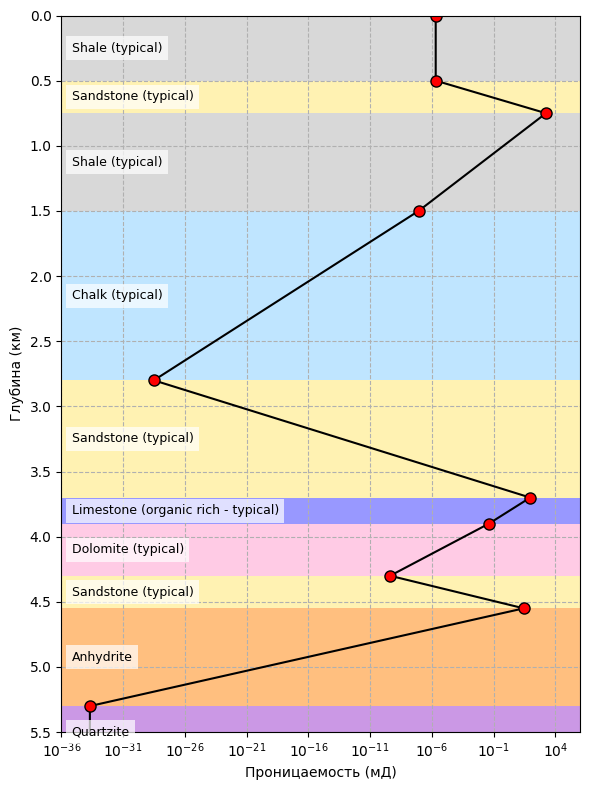

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
import numpy as np

def plot_permeability_depth_profile(
    permeability_df,
    decompaction_corrected_df,
    ylim=None,
    yticks=None,
    xlim=None,
    xticks=None
):
    # Get data for age 0
    age_0_col = '0.0'
    permeability_age_0 = permeability_df[age_0_col].values
    depths = decompaction_corrected_df[age_0_col].values  # Depth values in km

    # Ensure the first depth starts at 0
    if depths[0] != 0:
        depths = np.insert(depths, 0, 0)
        permeability_age_0 = np.insert(permeability_age_0, 0, permeability_age_0[0])

    # Geological layers data
    geological_layer_names = [
        'Shale (typical)',
        'Sandstone (typical)',
        'Shale (typical)',
        'Chalk (typical)',
        'Sandstone (typical)',
        'Limestone (organic rich - typical)',
        'Dolomite (typical)',
        'Sandstone (typical)',
        'Anhydrite',
        'Quartzite'
    ]

    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=(6, 8))

    # Define colors
    lithology_colors = {
        'Shale (typical)': (0.7, 0.7, 0.7, 0.5),
        'Sandstone (typical)': (1.0, 0.9, 0.4, 0.5),
        'Chalk (typical)': (0.5, 0.8, 1.0, 0.5),
        'Limestone (organic rich - typical)': (0.2, 0.2, 1.0, 0.5),
        'Dolomite (typical)': (1.0, 0.6, 0.8, 0.5),
        'Anhydrite': (1.0, 0.5, 0.0, 0.5),
        'Quartzite': (0.6, 0.2, 0.8, 0.5)
    }

    # Add geological background starting from 0 depth
    for i in range(len(depths)-1):
        layer_name = geological_layer_names[i % len(geological_layer_names)]
        depth = depths[i]
        next_depth = depths[i+1]

        ax.axhspan(depth, next_depth,
                  facecolor=lithology_colors[layer_name],
                  edgecolor='none')

        # Add layer name in the middle of each band
        midpoint = (depth + next_depth) / 2
        ax.text(0.02, midpoint, layer_name,
                va='center', ha='left', fontsize=9, color='black',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'),
                transform=ax.get_yaxis_transform())

    # Plot permeability data
    ax.plot(permeability_age_0, depths, 'ko-',
            markersize=8, linewidth=1.5,
            markerfacecolor='red', markeredgecolor='black')

    # Formatting
    ax.set_xscale('log')
    ax.set_xlabel('Проницаемость (мД)')
    ax.set_ylabel('Глубина (км)')
    ax.grid(True, which="both", ls="--")
    ax.invert_yaxis()

    # Set axis limits and ticks
    if ylim is not None:
        ax.set_ylim(ylim)
    else:
        ax.set_ylim((max(depths), 0))  # Auto scale with 0 at top

    if yticks is not None:
        ax.set_yticks(yticks)

    if xlim is not None:
        ax.set_xlim(xlim)

    if xticks is not None:
        ax.set_xticks(xticks)
        ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())

    plt.tight_layout()
    plt.savefig('Permeability0_vs_Depth.tiff', format='tiff', dpi=300, bbox_inches='tight')
    plt.show()

# Usage example:
plot_permeability_depth_profile(
    permeability_df,
    decompaction_corrected_df,
    ylim=(5, 0),  # From 5 km to surface (0 km)
    yticks=np.arange(0, 6.0, 0.5),  # Ticks every 0.5 km
    xlim=(1e-36, 1e6),  # Permeability range
    # xticks=np.logspace(-36, 6, num=9)  # 9 logarithmic ticks from 1e-36 to 1e6
)

## Hydro & Lithostatic Pressures

In [ ]:
import numpy as np
import pandas as pd
from scipy.integrate import quad

# Initialize pressure DataFrames
hydrostatic_pressure_df = pd.DataFrame()
lithostatic_pressure_df = pd.DataFrame()

# Constants
g = 9.81  # gravitational acceleration in m/s^2
rho_sea = 1100  # density of sea water in kg/m^3
rho_w = 1040  # density of pore water in kg/m^3
RoWater = 1000  # density of fresh water in kg/m^3
RoMantle = 3300  # density of mantle material in kg/m^3

sediment_surfaces = []


def hydrostatic_pressures(depths, sea_level, sediment_surface, water_depth, rho_water=rho_w):
    """Calculate hydrostatic pressures accounting for sea level and sediment surface"""
    pressures = []
    for depth in depths:
        if sediment_surface >= sea_level:
            # Water column exists
            water_pressure = rho_sea * g * water_depth
            # Sediment pore water pressure
            if depth > sediment_surface:
                sediment_pressure = quad(lambda z: rho_water * g, sediment_surface, depth)[0]
            else:
                sediment_pressure = 0
        else:
            # No water column (sediment surface above sea level)
            water_pressure = 0
            sediment_pressure = quad(lambda z: rho_water * g, sea_level, depth)[0]

        total_pressure = (water_pressure + sediment_pressure) / 1e6  # Convert to MPa
        pressures.append(total_pressure)
    return pressures

def lithostatic_pressures(depths, rock_densities, porosities, sea_level, water_depth, sediment_surface):
    """Calculate lithostatic pressures accounting for sea level and sediment surface"""
    pressures = []
    total_pressure = 0

    # Water column pressure if exists
    if sediment_surface >= sea_level:
        total_pressure += rho_sea * g * water_depth

    for i, (depth, density, porosity) in enumerate(zip(depths, rock_densities, porosities)):
        if i == 0:
            # First layer starts at sediment surface or sea level
            start_depth = max(sediment_surface, sea_level)
        else:
            start_depth = depths[i-1]

        effective_density = density * (1 - porosity) + rho_w * porosity
        pressure_increment = quad(lambda z: effective_density * g, start_depth, depth)[0]
        total_pressure += pressure_increment

        pressures.append(total_pressure / 1e6)  # Convert to MPa

    return pressures

# Prepare age list
age_list = list(work_layers['Age (Ma)'].unique())

for i, age in enumerate(age_list):
    print(f'\nProcessing age {i}: {age} Ma')

    # Make a copy of work layers for this iteration
    work_layers_copy = work_layers[:10].copy()

    # Initialize lists for this age
    hydrostatic_p_list = []
    lithostatic_p_list = []
    depth_list = []
    density_list = []
    porosity_list = []
    y2_d_list = []
    y2_d_corrected_list = []

    # Process each layer
    for row_index, row in work_layers_copy.iloc[i:].iterrows():
        try:
            lithology = row['Lithology_type']
            layers_name = row['Event_name']

            # Get lithology parameters
            lith_mask = (work_layers_copy['Lithology_type'] == str(lithology))
            PWD = work_layers_copy.loc[lith_mask, 'Paleobathymetry, Ma'].iloc[0]/1000 if lith_mask.any() else 0
            eustatic = work_layers_copy.loc[lith_mask, 'Sea level, m'].iloc[0]/1000 if lith_mask.any() else 0

            # Get lithology properties
            lithology_match = Database_Lithotypes[Database_Lithotypes['Lithology type'] == str(lithology)]
            phi0 = lithology_match['Initial porosity'].iloc[0]/100
            c = lithology_match['Athy factor k (depth)'].iloc[0]
            c = 1e-10 if c == 0 else c
            RoGrain = lithology_match['Density'].iloc[0]

            y1 = row['Depth top, m']
            y2 = row['Depth bottom, m']

            # Decompaction calculations
            if row_index == i:  # First layer
                y1_d = 0
                if age != 0:
                    y1_d_corrected = corrected(y1_d, RoMantle, RoWater, PWD, eustatic)
            else:
                y1_d = y2_d_list[-1]
                y1_d_corrected = y2_d_corrected_list[-1] if y2_d_corrected_list else 0

            # Core calculations
            if age == 0:
                age_mask = (work_layers_copy['Age (Ma)'] == int(age))
                PWD = work_layers_copy.loc[age_mask, 'Paleobathymetry, Ma'].iloc[0]/1000 if age_mask.any() else 0
                y2_d = y2 + PWD
                y2_d_corrected = y2_d
            elif age == 260:
                depth = 0.3
                y2_d_corrected = abs(np.round(corrected(depth, RoMantle, RoWater, PWD, eustatic), 3))
                y2_d = y2_d_corrected
            else:
                y2_d = decomp_func(y1, y2, y1_d, phi0, c)
                y2_d_corrected = corrected(y2_d, RoMantle, RoWater, PWD, eustatic)

            # Store decompacted depths
            y2_d_list.append(y2_d)
            y2_d_corrected_list.append(y2_d_corrected)

            # Calculate porosity and density
            thickness = y2_d - y1_d
            porosity = porosity_func(phi0, c, y1_d, y2_d, thickness)
            density = bulk_density(porosity, RoGrain, RoWater)

            # Store properties for pressure calculations
            depth_list.append(y2_d * 1000)
            density_list.append(density)
            porosity_list.append(porosity)

        except Exception as ex:
            print(f"Error processing row {row_index} (Lithology: {lithology}): {str(ex)}")
            continue

    # Calculate pressures for this age
    if depth_list and density_list:
        # Determine sea level and sediment surface conditions
        SEA_LEVEL = 0
        SEDIMENT_SURFACE = work_layers_copy.iloc[i]['Paleobathymetry, Ma'] if i < len(work_layers_copy) else 0
        sediment_surfaces.append(SEDIMENT_SURFACE)

        if SEDIMENT_SURFACE >= 0:
            WATER_DEPTH = SEDIMENT_SURFACE
        else:
            WATER_DEPTH = SEA_LEVEL

        # Calculate both pressure types
        pressures_hydrostatic = hydrostatic_pressures(
            depth_list,
            sea_level=SEA_LEVEL,
            sediment_surface=SEDIMENT_SURFACE,
            water_depth=WATER_DEPTH
        )

        lith_pressures = lithostatic_pressures(
            depth_list,
            density_list,
            porosity_list,
            sea_level=SEA_LEVEL,
            water_depth=WATER_DEPTH,
            sediment_surface=SEDIMENT_SURFACE
        )

        hydrostatic_p_list = pressures_hydrostatic
        lithostatic_p_list = lith_pressures

        print(f"Age {age} Ma - Hydrostatic pressures (MPa):", pressures_hydrostatic)
        print(f"Age {age} Ma - Lithostatic pressures (MPa):", lith_pressures)

    # Store results in the DataFrames
    new_col_name = f'{age}'

    # Hydrostatic pressure
    resized_list = np.zeros(work_layers_copy.shape[0])
    resized_list[len(resized_list) - len(hydrostatic_p_list):] = hydrostatic_p_list
    hydrostatic_pressure_df[new_col_name] = resized_list

    # Lithostatic pressure
    resized_list = np.zeros(work_layers_copy.shape[0])
    resized_list[len(resized_list) - len(lithostatic_p_list):] = lithostatic_p_list
    lithostatic_pressure_df[new_col_name] = resized_list

# Final DataFrames available:
# hydrostatic_pressure_df - contains hydrostatic pressure values for each age
# lithostatic_pressure_df - contains lithostatic pressure values for each age


Processing age 0: 0.0 Ma
Age 0.0 Ma - Hydrostatic pressures (MPa): [np.float64(5.27778), np.float64(7.828379999999999), np.float64(15.480179999999999), np.float64(28.743299999999998), np.float64(37.92545999999999), np.float64(39.96593999999999), np.float64(44.046899999999994), np.float64(46.59749999999999), np.float64(54.24929999999999), np.float64(58.33025999999999)]
Age 0.0 Ma - Lithostatic pressures (MPa): [np.float64(5.852630780665549), np.float64(10.187653661318429), np.float64(24.11834382691704), np.float64(54.01270849524544), np.float64(73.86165382649389), np.float64(78.6755833497624), np.float64(88.675191659106), np.float64(94.5242059693622), np.float64(116.09048787336033), np.float64(126.36181292288313)]

Processing age 1: 45.0 Ma
Age 45.0 Ma - Hydrostatic pressures (MPa): [np.float64(3.507075), np.float64(11.157553763349476), np.float64(24.661908714666364), np.float64(33.900798391815215), np.float64(35.95068114046358), np.float64(40.04491470377063), np.float64(42.60519074554

In [ ]:
lithostatic_pressure_df

0.0        45.0        55.0       80.0      100.0      125.0  \
0    5.852631    0.000000    0.000000   0.000000   0.000000   0.000000   
1   10.187654    2.449188    0.000000   0.000000   0.000000   0.000000   
2   24.118344   15.310907   12.225305   0.000000   0.000000   0.000000   
3   54.012708   43.935264   40.810989  27.315240   0.000000   0.000000   
4   73.861654   63.406518   60.273928  46.747948  18.441570   0.000000   
5   78.675583   68.145384   65.009184  51.463871  23.137929   4.973608   
6   88.675192   78.026179   74.883443  61.302635  32.870215  14.698861   
7   94.524206   83.797149   80.651400  67.055412  38.594605  20.455143   
8  116.090488  105.363430  102.217682  88.621694  60.160886  42.021424   
9  126.361813  115.634755  112.489007  98.893019  70.432211  52.292749   

       145.0      160.0      210.0      245.0  260.0  
0   0.000000   0.000000   0.000000   0.000000    0.0  
1   0.000000   0.000000   0.000000   0.000000    0.0  
2   0.000000   0.000000   0.000000   0.000000    0.0  
3   0.000000   0.000000   0.000000   0.000000    0.0  
4   0.000000   0.000000   0.000000   0.000000    0.0  
5   0.000000   0.000000   0.000000   0.000000    0.0  
6   9.621205   0.000000   0.000000   0.000000    0.0  
7  15.409935   5.836513   0.000000   0.000000    0.0  
8  36.976216  27.402795  21.207000   0.000000    0.0  
9  47.247541  37.674120  31.478325  10.271325    0.0

In [ ]:
lithostatic_pressure_df

0.0        45.0        55.0       80.0      100.0      125.0  \
0    5.852631    0.000000    0.000000   0.000000   0.000000   0.000000   
1   10.187654    2.449188    0.000000   0.000000   0.000000   0.000000   
2   24.118344   15.310907   12.225305   0.000000   0.000000   0.000000   
3   54.012708   43.935264   40.810989  27.315240   0.000000   0.000000   
4   73.861654   63.406518   60.273928  46.747948  18.441570   0.000000   
5   78.675583   68.145384   65.009184  51.463871  23.137929   4.973608   
6   88.675192   78.026179   74.883443  61.302635  32.870215  14.698861   
7   94.524206   83.797149   80.651400  67.055412  38.594605  20.455143   
8  116.090488  105.363430  102.217682  88.621694  60.160886  42.021424   
9  126.361813  115.634755  112.489007  98.893019  70.432211  52.292749   

       145.0      160.0      210.0      245.0  260.0  
0   0.000000   0.000000   0.000000   0.000000    0.0  
1   0.000000   0.000000   0.000000   0.000000    0.0  
2   0.000000   0.000000   0.000000   0.000000    0.0  
3   0.000000   0.000000   0.000000   0.000000    0.0  
4   0.000000   0.000000   0.000000   0.000000    0.0  
5   0.000000   0.000000   0.000000   0.000000    0.0  
6   9.621205   0.000000   0.000000   0.000000    0.0  
7  15.409935   5.836513   0.000000   0.000000    0.0  
8  36.976216  27.402795  21.207000   0.000000    0.0  
9  47.247541  37.674120  31.478325  10.271325    0.0

<ipython-input-64-462a471114c3>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('jet')  # Changed from get_cmap to cm.get_cmap


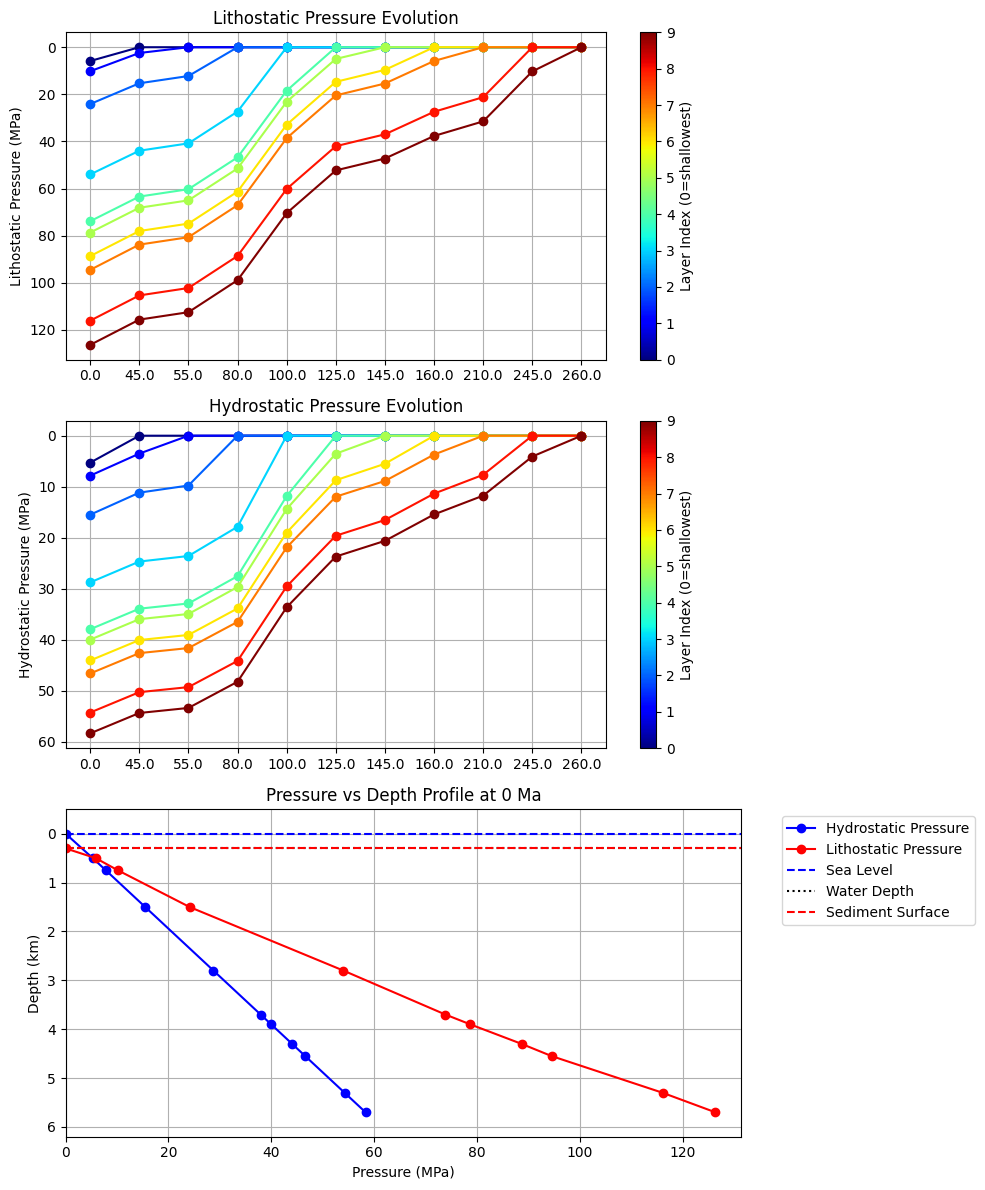

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
import numpy as np

def plot_pressure_profiles(lithostatic_pressure_df, hydrostatic_pressure_df, decompaction_corrected_df, sediment_surfaces):
    ages = lithostatic_pressure_df.columns.values

    # Create figure with 3 subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), sharex=False)

    # --- Plot 1: Lithostatic Pressure vs Age ---
    colormap = cm.get_cmap('jet')  # Changed from get_cmap to cm.get_cmap
    norm_lith = Normalize(vmin=0, vmax=len(lithostatic_pressure_df)-1)

    # Plot layers in natural order (Layer 0 at top) with colormap
    for idx, (index, row) in enumerate(lithostatic_pressure_df.iterrows()):
        color = colormap(norm_lith(idx))
        ax1.plot(ages, row, color=color, lw=1.5, marker='o', markersize=6, label=f'Layer {index}')

    ax1.set_ylabel('Lithostatic Pressure (MPa)')
    ax1.set_title('Lithostatic Pressure Evolution')
    ax1.invert_yaxis()
    ax1.grid(True)
    # ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Add colorbar for lithostatic plot
    sm_lith = cm.ScalarMappable(cmap=colormap, norm=norm_lith)
    sm_lith.set_array([])
    cbar_lith = plt.colorbar(sm_lith, ax=ax1, ticks=range(len(lithostatic_pressure_df)))
    cbar_lith.set_label("Layer Index (0=shallowest)")

    # --- Plot 2: Hydrostatic Pressure vs Age ---
    norm_hydro = Normalize(vmin=0, vmax=len(hydrostatic_pressure_df)-1)

    # Plot layers in natural order (Layer 0 at top) with colormap
    for idx, (index, row) in enumerate(hydrostatic_pressure_df.iterrows()):
        color = colormap(norm_hydro(idx))
        ax2.plot(ages, row, color=color, lw=1.5, marker='o', markersize=6, label=f'Layer {index}')

    ax2.set_ylabel('Hydrostatic Pressure (MPa)')
    ax2.set_title('Hydrostatic Pressure Evolution')
    ax2.invert_yaxis()
    ax2.grid(True)
    # ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Add colorbar for hydrostatic plot
    sm_hydro = cm.ScalarMappable(cmap=colormap, norm=norm_hydro)
    sm_hydro.set_array([])
    cbar_hydro = plt.colorbar(sm_hydro, ax=ax2, ticks=range(len(hydrostatic_pressure_df)))
    cbar_hydro.set_label("Layer Index (0=shallowest)")

    # --- Plot 3: Pressure vs Depth Profile at Age 0 ---
    age_0_col = '0.0'
    age_0_lithostatic = lithostatic_pressure_df[age_0_col].values
    age_0_hydrostatic = hydrostatic_pressure_df[age_0_col].values
    age_0_depths = decompaction_corrected_df[age_0_col].values
    depths_km = age_0_depths
    SEA_LEVEL = 0
    SEDIMENT_SURFACE = sediment_surfaces[0] / 1000
    WATER_DEPTH = SEDIMENT_SURFACE if SEDIMENT_SURFACE >= 0 else SEA_LEVEL

    # Hydrostatic pressure plot
    hydro_depths = np.concatenate([[SEA_LEVEL], depths_km[depths_km >= SEA_LEVEL]])
    hydro_pressures = np.concatenate([[0], age_0_hydrostatic[depths_km >= SEA_LEVEL]])
    ax3.plot(hydro_pressures, hydro_depths, 'b-', marker='o', label='Hydrostatic Pressure')

    # Lithostatic pressure plot
    if SEDIMENT_SURFACE < 0:
        litho_depths = np.concatenate([[SEDIMENT_SURFACE], depths_km[depths_km >= SEDIMENT_SURFACE]])
        litho_pressures = np.concatenate([[0], age_0_lithostatic[depths_km >= SEDIMENT_SURFACE]])
    else:
        litho_depths = np.concatenate([[SEDIMENT_SURFACE], depths_km[depths_km > SEDIMENT_SURFACE]])
        litho_pressures = np.concatenate([[0], age_0_lithostatic[depths_km > SEDIMENT_SURFACE]])
    ax3.plot(litho_pressures, litho_depths, 'r-', marker='o', label='Lithostatic Pressure')

    # Reference lines and formatting
    x_min = min(np.min(hydro_pressures), np.min(litho_pressures))
    x_max = max(np.max(hydro_pressures), np.max(litho_pressures))
    ax3.axhline(y=SEA_LEVEL, color='blue', linestyle='--', label='Sea Level')
    if SEDIMENT_SURFACE > SEA_LEVEL:
        ax3.axhline(y=WATER_DEPTH, color='black', linestyle=':', label='Water Depth')
    ax3.axhline(y=SEDIMENT_SURFACE, color='red', linestyle='--', label='Sediment Surface')
    ax3.set_title('Pressure vs Depth Profile at 0 Ma')
    ax3.set_xlabel('Pressure (MPa)')
    ax3.set_ylabel('Depth (km)')
    ax3.invert_yaxis()
    ax3.set_ylim(max(depths_km.max(), abs(SEDIMENT_SURFACE)) + 0.5,
                min(-0.5, SEDIMENT_SURFACE - 0.5))
    ax3.set_xlim(0, x_max + 5)
    ax3.grid(True)
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

# Usage:
plot_pressure_profiles(lithostatic_pressure_df, hydrostatic_pressure_df, decompaction_corrected_df, sediment_surfaces)

<ipython-input-65-334acdff4831>:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('jet')


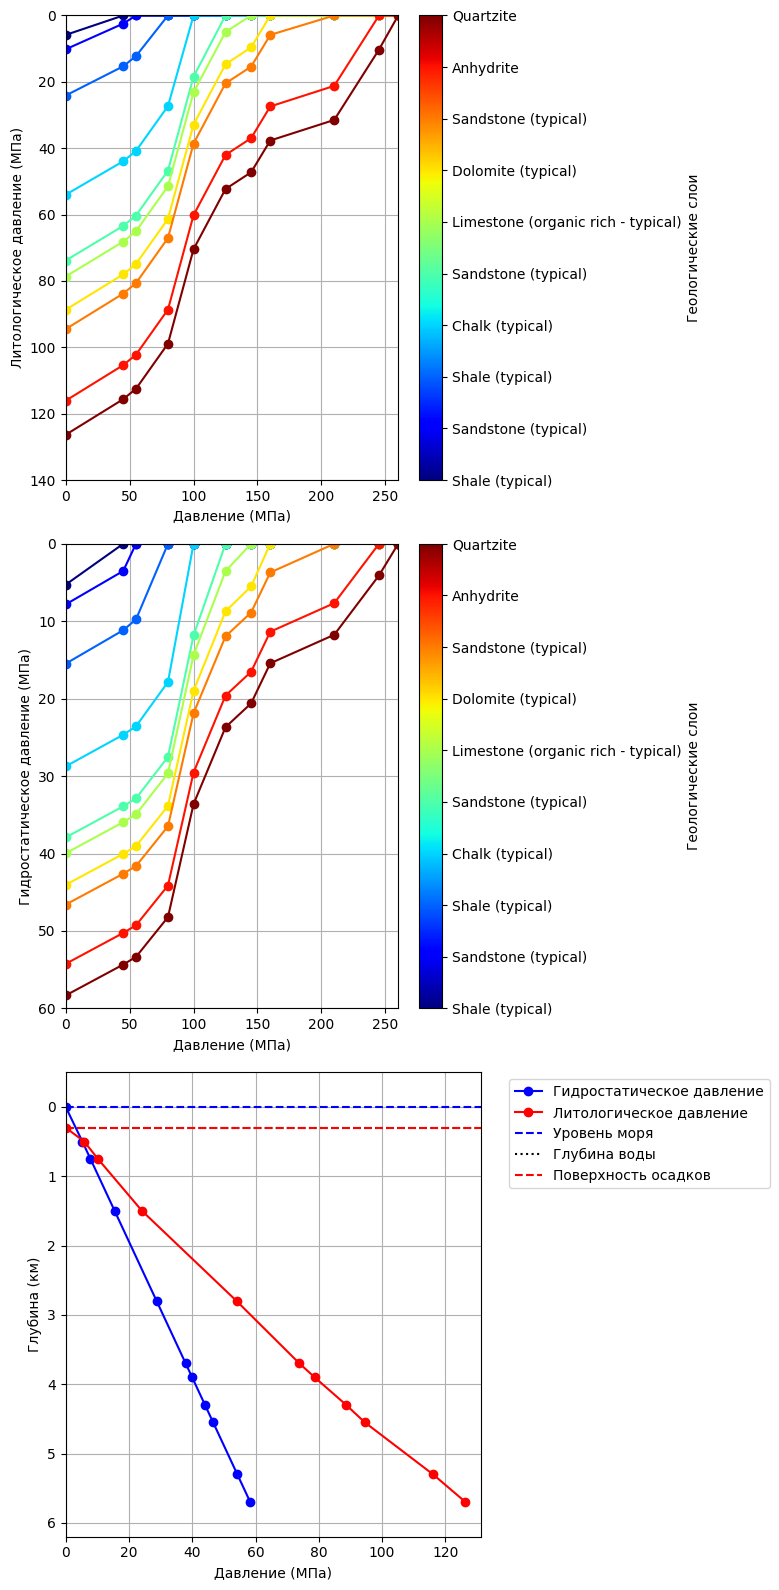

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
import numpy as np

def plot_pressure_profiles(lithostatic_pressure_df, hydrostatic_pressure_df, decompaction_corrected_df, sediment_surfaces):
    # ages = lithostatic_pressure_df.columns.values
    ages = lithostatic_pressure_df.columns.astype(float).values

    # Данные геологических слоёв
    geological_layer_names = [
        'Shale (typical)',
        'Sandstone (typical)',
        'Shale (typical)',
        'Chalk (typical)',
        'Sandstone (typical)',
        'Limestone (organic rich - typical)',
        'Dolomite (typical)',
        'Sandstone (typical)',
        'Anhydrite',
        'Quartzite'
    ]

    # Создаем фигуру с 3 подграфиками
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 16), sharex=False)

    # --- График 1: Литологическое давление в зависимости от возраста ---
    colormap = cm.get_cmap('jet')
    norm_lith = Normalize(vmin=0, vmax=len(lithostatic_pressure_df)-1)

    # Рисуем слои с цветовой картой
    for idx, (index, row) in enumerate(lithostatic_pressure_df.iterrows()):
        color = colormap(norm_lith(idx))
        ax1.plot(ages, row, color=color, lw=1.5, marker='o', markersize=6, label=f'Слой {index}')

    ax1.set_ylabel('Литологическое давление (МПа)')
    ax1.set_xlabel('Давление (МПа)')
    # ax1.set_title('Эволюция литологического давления')
    ax1.invert_yaxis()
    ax1.grid(True)
    ax1.set_xlim(0, 260)
    ax1.set_ylim(140, 0)
    # ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Добавляем цветовую шкалу с названиями слоёв
    sm_lith = cm.ScalarMappable(cmap=colormap, norm=norm_lith)
    sm_lith.set_array([])
    cbar_lith = plt.colorbar(
        sm_lith,
        ax=ax1,
        ticks=np.arange(len(geological_layer_names)),  # Позиции меток
    )
    cbar_lith.set_ticklabels(geological_layer_names)  # Подписи вместо чисел
    cbar_lith.set_label("Геологические слои")

    # --- График 2: Гидростатическое давление в зависимости от возраста ---
    norm_hydro = Normalize(vmin=0, vmax=len(hydrostatic_pressure_df)-1)

    for idx, (index, row) in enumerate(hydrostatic_pressure_df.iterrows()):
        color = colormap(norm_hydro(idx))
        ax2.plot(ages, row, color=color, lw=1.5, marker='o', markersize=6, label=f'Слой {index}')


    ax2.set_ylabel('Гидростатическое давление (МПа)')
    ax2.set_xlabel('Давление (МПа)')
    # ax2.set_title('Эволюция гидростатического давления')
    ax2.invert_yaxis()
    ax2.set_xlim(0, 260)
    ax2.set_ylim(60, 0)
    ax2.grid(True)

    # Добавляем цветовую шкалу с названиями слоёв
    sm_hydro = cm.ScalarMappable(cmap=colormap, norm=norm_hydro)
    sm_hydro.set_array([])
    cbar_hydro = plt.colorbar(
        sm_hydro,
        ax=ax2,
        ticks=np.arange(len(geological_layer_names)),
    )
    cbar_hydro.set_ticklabels(geological_layer_names)
    cbar_hydro.set_label("Геологические слои")

    # --- График 3: Профиль давления по глубине для возраста 0 млн. лет ---
    age_0_col = '0.0'
    age_0_lithostatic = lithostatic_pressure_df[age_0_col].values
    age_0_hydrostatic = hydrostatic_pressure_df[age_0_col].values
    age_0_depths = decompaction_corrected_df[age_0_col].values
    depths_km = age_0_depths
    SEA_LEVEL = 0
    SEDIMENT_SURFACE = sediment_surfaces[0] / 1000
    WATER_DEPTH = SEDIMENT_SURFACE if SEDIMENT_SURFACE >= 0 else SEA_LEVEL

    # График гидростатического давления
    hydro_depths = np.concatenate([[SEA_LEVEL], depths_km[depths_km >= SEA_LEVEL]])
    hydro_pressures = np.concatenate([[0], age_0_hydrostatic[depths_km >= SEA_LEVEL]])
    ax3.plot(hydro_pressures, hydro_depths, 'b-', marker='o', label='Гидростатическое давление')

    # График литологического давления
    if SEDIMENT_SURFACE < 0:
        litho_depths = np.concatenate([[SEDIMENT_SURFACE], depths_km[depths_km >= SEDIMENT_SURFACE]])
        litho_pressures = np.concatenate([[0], age_0_lithostatic[depths_km >= SEDIMENT_SURFACE]])
    else:
        litho_depths = np.concatenate([[SEDIMENT_SURFACE], depths_km[depths_km > SEDIMENT_SURFACE]])
        litho_pressures = np.concatenate([[0], age_0_lithostatic[depths_km > SEDIMENT_SURFACE]])
    ax3.plot(litho_pressures, litho_depths, 'r-', marker='o', label='Литологическое давление')

    # Опорные линии и оформление
    x_min = min(np.min(hydro_pressures), np.min(litho_pressures))
    x_max = max(np.max(hydro_pressures), np.max(litho_pressures))
    ax3.axhline(y=SEA_LEVEL, color='blue', linestyle='--', label='Уровень моря')
    if SEDIMENT_SURFACE > SEA_LEVEL:
        ax3.axhline(y=WATER_DEPTH, color='black', linestyle=':', label='Глубина воды')
    ax3.axhline(y=SEDIMENT_SURFACE, color='red', linestyle='--', label='Поверхность осадков')
    # ax3.set_title('Профиль давления по глубине на 0 млн. лет')
    ax3.set_xlabel('Давление (МПа)')
    ax3.set_ylabel('Глубина (км)')
    ax3.invert_yaxis()
    ax3.set_ylim(max(depths_km.max(), abs(SEDIMENT_SURFACE)) + 0.5,
                min(-0.5, SEDIMENT_SURFACE - 0.5))
    ax3.set_xlim(0, x_max + 5)
    ax3.grid(True)
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.savefig('Hydro&Lith_Pressures.tiff', format='tiff', dpi=300, bbox_inches='tight')
    plt.show()

# Использование:
plot_pressure_profiles(lithostatic_pressure_df, hydrostatic_pressure_df, decompaction_corrected_df, sediment_surfaces)

In [ ]:
decompaction_df.loc['Stratigraphic thickness (km)', :] = decompaction_df.sum(axis=0) # <-- ввод общей мощности

### добавление колонок Lithology_typeб	Event_name
work_layers.reset_index(drop=True, inplace=True)
decompaction_df['Event_name'] = work_layers['Event_name']
decompaction_df['Lithology_type'] = work_layers['Lithology_type']
decompaction_df = decompaction_df[decompaction_df.columns[::-1]]

decompaction_df.to_csv('/content/Decompaction.csv', index=True)

In [ ]:
decompaction_df

Lithology_type  Event_name  \
0                                                Shale (typical)  Layer 10_1   
1                                            Sandstone (typical)   Layer 9_1   
2                                                Shale (typical)   Layer 8_1   
3                                                Chalk (typical)   Layer 7_1   
4                                            Sandstone (typical)   Layer 6_1   
5                             Limestone (organic rich - typical)   Layer 5_1   
6                                             Dolomite (typical)   Layer 4_1   
7                                            Sandstone (typical)   Layer 3_1   
8                                                      Anhydrite   Layer 2_1   
9                                                      Quartzite   Layer 1_1   
Stratigraphic thickness (km)                                 NaN         NaN   

                              260.0  245.0  210.0  160.0  145.0  125.0  100.0  \
0                               0.0    0.0   0.00  0.000  0.000  0.000  0.000   
1                               0.0    0.0   0.00  0.000  0.000  0.000  0.000   
2                               0.0    0.0   0.00  0.000  0.000  0.000  0.000   
3                               0.0    0.0   0.00  0.000  0.000  0.000  0.000   
4                               0.0    0.0   0.00  0.000  0.000  0.000  1.148   
5                               0.0    0.0   0.00  0.000  0.000  0.344  0.249   
6                               0.0    0.0   0.00  0.000  0.538  0.510  0.452   
7                               0.0    0.0   0.00  0.362  0.330  0.316  0.284   
8                               0.0    0.0   0.75  0.750  0.750  0.750  0.750   
9                               0.0    0.4   0.40  0.400  0.400  0.400  0.400   
Stratigraphic thickness (km)    0.0    0.4   1.15  1.512  2.018  2.320  3.283   

                               80.0   55.0   45.0   0.0  
0                             0.000  0.000  0.000  0.50  
1                             0.000  0.000  0.260  0.25  
2                             0.000  0.937  0.815  0.75  
3                             1.732  1.354  1.324  1.30  
4                             0.949  0.912  0.906  0.90  
5                             0.208  0.202  0.201  0.20  
6                             0.411  0.403  0.401  0.40  
7                             0.258  0.252  0.251  0.25  
8                             0.750  0.750  0.750  0.75  
9                             0.400  0.400  0.400  0.40  
Stratigraphic thickness (km)  4.708  5.210  5.308  5.70

### Save to .csv

In [ ]:
### добавление колонок Lithology_type,	Event_name
# work_layers.reset_index(drop=True, inplace=True)
decompaction_corrected_df['Event_name'] = work_layers['Event_name']
decompaction_corrected_df['Lithology_type'] = work_layers['Lithology_type']
decompaction_corrected_df = decompaction_corrected_df[decompaction_corrected_df.columns[::-1]]

decompaction_corrected_df.to_csv('/content/Decompaction_corrected.csv', index=True)

In [ ]:
decompaction_corrected_df

Lithology_type  Event_name  260.0  245.0  210.0  160.0  \
0                     Shale (typical)  Layer 10_1    0.0    0.0   0.00  0.000   
1                 Sandstone (typical)   Layer 9_1    0.0    0.0   0.00  0.000   
2                     Shale (typical)   Layer 8_1    0.0    0.0   0.00  0.000   
3                     Chalk (typical)   Layer 7_1    0.0    0.0   0.00  0.000   
4                 Sandstone (typical)   Layer 6_1    0.0    0.0   0.00  0.000   
5  Limestone (organic rich - typical)   Layer 5_1    0.0    0.0   0.00  0.000   
6                  Dolomite (typical)   Layer 4_1    0.0    0.0   0.00  0.000   
7                 Sandstone (typical)   Layer 3_1    0.0    0.0   0.00  0.629   
8                           Anhydrite   Layer 2_1    0.0    0.0   0.77  1.132   
9                           Quartzite   Layer 1_1    0.0    0.4   1.15  1.512   

   145.0  125.0  100.0   80.0   55.0   45.0   0.0  
0  0.000  0.000  0.000  0.000  0.000  0.000  0.50  
1  0.000  0.000  0.000  0.000  0.000  0.527  0.75  
2  0.000  0.000  0.000  0.000  1.237  1.375  1.50  
3  0.000  0.000  0.000  1.889  2.447  2.555  2.80  
4  0.000  0.000  1.415  2.948  3.470  3.572  3.70  
5  0.000  0.264  1.316  2.809  3.324  3.425  3.90  
6  0.615  0.931  1.926  3.378  3.884  3.984  4.30  
7  1.136  1.438  2.401  3.826  4.326  4.425  4.55  
8  1.638  1.940  2.903  4.328  4.829  4.927  5.30  
9  2.018  2.320  3.283  4.708  5.209  5.307  5.70

In [ ]:
### добавление колонок Lithology_type,	Event_name
# work_layers.reset_index(drop=True, inplace=True)
decompaction_corrected_df['Event_name'] = work_layers['Event_name']
decompaction_corrected_df['Lithology_type'] = work_layers['Lithology_type']
decompaction_corrected_df = decompaction_corrected_df[decompaction_corrected_df.columns[::-1]]

decompaction_corrected_df.to_csv('/content/Decompaction_corrected.csv', index=True)

In [ ]:
### добавление колонок Lithology_type,	Event_name
work_layers.reset_index(drop=True, inplace=True)
porosity_df['Event_name'] = work_layers['Event_name']
porosity_df['Lithology_type'] = work_layers['Lithology_type']
porosity_df = porosity_df[porosity_df.columns[::-1]]

porosity_df.to_csv('/content/Porosity.csv', index=True)

In [ ]:
### добавление колонок Lithology_type,	Event_name
work_layers.reset_index(drop=True, inplace=True)
density_df['Event_name'] = work_layers['Event_name']
density_df['Lithology_type'] = work_layers['Lithology_type']
density_df = density_df[density_df.columns[::-1]]

density_df.to_csv('/content/Density.csv', index=True)

In [ ]:
### добавление колонок Lithology_type,	Event_name
work_layers.reset_index(drop=True, inplace=True)
density_column_df['Event_name'] = work_layers['Event_name']
density_column_df['Lithology_type'] = work_layers['Lithology_type']
density_column_df = density_column_df[density_column_df.columns[::-1]]

density_column_df.to_csv('/content/Density_column.csv', index=True)

In [ ]:
### добавление колонок Lithology_type,	Event_name
work_layers.reset_index(drop=True, inplace=True)
permeability_df['Event_name'] = work_layers['Event_name']
permeability_df['Lithology_type'] = work_layers['Lithology_type']
permeability_df = permeability_df[permeability_df.columns[::-1]]

permeability_df.to_csv('/content/Permeability.csv', index=True)

#### Plot: "Porosity - Depth" (Comparison with Petromod)

In [ ]:
# Petromod

data_ref = pd.read_excel('/content/BM/Charts_Petromod.xlsx', sheet_name='Petromod porosity', skiprows=0, header=0, engine='openpyxl')
data_ref = data_ref.applymap(lambda x: x.split('\t') if isinstance(x, str) else x)

depth_dc, porosity_plot = [],[]

# Create a sample DataFrame with shape 10x2
depth_dc = decompaction_corrected_df['0.0'].tolist()
porosity_plot = data_ref[0].tolist()

data = {
    'porosity': porosity_plot,
    'depth_dc': depth_dc
}
df = pd.DataFrame(data)

# # Repeat each column in order like 1 cell, 1 cell, 2 cell, 2 cell, 3 cell, 3 cell
# new_data = {key: [val for val in df[key] for _ in range(2)] for key in df.columns}



# Rewrite the dictionary comprehension as a list comprehension
new_data_list = [(key, [val for val in df[key] for _ in range(2)]) for key in df.columns]
new_data_list[0][1].append(0)
new_data_list[1][1].insert(0, 0)

# Display the new_data_list
print(new_data_list[0][1])

# Convert the list of tuples to a dictionary
data_dict = {key: value for key, value in new_data_list}

# Create a DataFrame from the dictionary
new_df_ref = pd.DataFrame(data_dict)

[0.5992999999999999, 0.5992999999999999, 0.4499, 0.4499, 0.41229999999999994, 0.41229999999999994, 0.2012, 0.2012, 0.225, 0.225, 0.0489, 0.0489, 0.0215, 0.0215, 0.1645, 0.1645, 0.0209, 0.0209, 0.0444, 0.0444, 0]


<ipython-input-75-5fd948905ef5>:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data_ref = data_ref.applymap(lambda x: x.split('\t') if isinstance(x, str) else x)


In [ ]:
# Calculated data

depth_dc, porosity_plot = [],[]

# Create a sample DataFrame with shape 10x2
# depth_dc = decompaction_corrected_df['0.0'].tolist()
porosity_plot = porosity_df['0.0'].tolist()
depth_dc = work_layers['Depth bottom, m'].tolist()[0:len(porosity_plot)]

data = {
    'porosity': porosity_plot,
    'depth_dc': depth_dc
}
df = pd.DataFrame(data)

# # Repeat each column in order like 1 cell, 1 cell, 2 cell, 2 cell, 3 cell, 3 cell
# new_data = {key: [val for val in df[key] for _ in range(2)] for key in df.columns}



# Rewrite the dictionary comprehension as a list comprehension
new_data_list = [(key, [val for val in df[key] for _ in range(2)]) for key in df.columns]
new_data_list[0][1].append(0)
new_data_list[1][1].insert(0, 0)

# Display the new_data_list
print(new_data_list[0][1])

# Convert the list of tuples to a dictionary
data_dict = {key: value for key, value in new_data_list}

# Create a DataFrame from the dictionary
new_df = pd.DataFrame(data_dict)

[0.573, 0.573, 0.338, 0.338, 0.28, 0.28, 0.107, 0.107, 0.15, 0.15, 0.071, 0.071, 0.071, 0.071, 0.104, 0.104, 0.01, 0.01, 0.01, 0.01, 0]


In [ ]:
def makeplot_porosity(property, top_depth, bottom_depth):
    # fig = plt.figure(constrained_layout=True, figsize=(10, 6))
    # ax = fig.subplots(1, 2,  sharex=False)

    fig, ax = plt.subplots(figsize=(14,7))

    ax1 = plt.subplot2grid((1,3), (0,0), rowspan=1, colspan = 1)
    ax2 = plt.subplot2grid((1,3), (0,1), rowspan=1, colspan = 1, sharey = ax1)
    ax3 = plt.subplot2grid((1,3), (0,2), rowspan=1, colspan = 1, sharey = ax1)

    # As our curve scales will be detached from the top of the track,
    # this code adds the top border back in without dealing with splines
    # ax10 = ax1.twiny()
    # ax10.xaxis.set_visible(False)

    # ax13 = ax4.twiny()
    # ax13.xaxis.set_visible(False)

### Plot 1
    # Geotherma
    # ax1.plot(new_df_ref['porosity'], new_df['depth_dc'], label='Petromod', color='red')
    ax1.plot(new_df['porosity'], new_df['depth_dc'], label='BM', color='black')
    ax1.set_xlabel(f'Porosity', labelpad=20)
    ax1.set_ylabel(f'Depth (km)')
    ax1.legend(loc='upper left')
    ax1.set_xlim(0, 0.7)

### Plot 2
    # Lithology track
    # ax2.plot(T_with_rad_heat["Lithology"], T_with_rad_heat['depth 0'], color = "black", linewidth = 0.5)
    ax2.set_xlabel("Lithology")
    ax2.set_xlim(0, 1)
    ax2.xaxis.label.set_color("black")
    ax2.tick_params(axis='x', colors="black")
    ax2.spines["top"].set_edgecolor("black")
    ax2.set_xticks([0, 1])

    depth_start = 0


    for lit, depth in zip(work_layers.index, decompaction_corrected_df['0.0']):
        key = int(lit)
        color = work_layers.at[lit, 'Color']
        hatch = work_layers.at[lit, 'Index']


        depth_values = [depth_start, depth]
        depth_start = depth

        ax2.fill_betweenx(depth_values, 0, 1, facecolor=color, hatch=hatch)

    ax2.set_xticks([0, 1])

### Plot3
    ax3.set_xlabel("Lithology")
    ax3.set_xlim(0, 1)
    ax3.xaxis.label.set_color("black")
    ax3.tick_params(axis='x', colors="black")
    ax3.spines["top"].set_edgecolor("black")
    ax3.set_xticks([0, 1])

    depth_start = 0

    for lit, depth in zip(work_layers_initial["Lithology_type"],work_layers_initial['Depth bottom, m']):
        key = lit
        depth_values = [depth_start, depth]
        depth_start = depth

        label_position = (0.5, sum(depth_values) / 2)  # Assuming x position is at 0.5
        ax3.text(label_position[0], label_position[1], key, ha='center', va='center')
        ax3.plot([0, 1], [depth, depth], color='black', linewidth=1)  # Assuming black color and linewidth of 1


    for ax in [ax1, ax2, ax3]:
        ax.set_ylim(bottom_depth, top_depth)
        ax.grid(which='major', color='lightgrey', linestyle='-')
        ax.xaxis.set_ticks_position("top")
        ax.xaxis.set_label_position("top")
        ax.spines["top"].set_position(("axes", 1.02))

    for ax in [ax2]:
        plt.setp(ax.get_yticklabels(), visible = False)

    plt.tight_layout()
    fig.subplots_adjust(wspace = 0.15)
    return plt.savefig("porosity-depth.png")

In [ ]:
decompaction_corrected_df

0.0   45.0   55.0   80.0  100.0  125.0  145.0  160.0  210.0  245.0  260.0  \
0  0.50  0.000  0.000  0.000  0.000  0.000  0.000  0.000   0.00    0.0    0.0   
1  0.75  0.527  0.000  0.000  0.000  0.000  0.000  0.000   0.00    0.0    0.0   
2  1.50  1.375  1.237  0.000  0.000  0.000  0.000  0.000   0.00    0.0    0.0   
3  2.80  2.555  2.447  1.889  0.000  0.000  0.000  0.000   0.00    0.0    0.0   
4  3.70  3.572  3.470  2.948  1.415  0.000  0.000  0.000   0.00    0.0    0.0   
5  3.90  3.425  3.324  2.809  1.316  0.264  0.000  0.000   0.00    0.0    0.0   
6  4.30  3.984  3.884  3.378  1.926  0.931  0.615  0.000   0.00    0.0    0.0   
7  4.55  4.425  4.326  3.826  2.401  1.438  1.136  0.629   0.00    0.0    0.0   
8  5.30  4.927  4.829  4.328  2.903  1.940  1.638  1.132   0.77    0.0    0.0   
9  5.70  5.307  5.209  4.708  3.283  2.320  2.018  1.512   1.15    0.4    0.0   

   Event_name                      Lithology_type  
0  Layer 10_1                     Shale (typical)  
1   Layer 9_1                 Sandstone (typical)  
2   Layer 8_1                     Shale (typical)  
3   Layer 7_1                     Chalk (typical)  
4   Layer 6_1                 Sandstone (typical)  
5   Layer 5_1  Limestone (organic rich - typical)  
6   Layer 4_1                  Dolomite (typical)  
7   Layer 3_1                 Sandstone (typical)  
8   Layer 2_1                           Anhydrite  
9   Layer 1_1                           Quartzite

In [ ]:
# porosity_df.columns, decompaction_corrected_df.columns

<ipython-input-77-98802aea4069>:50: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error in 3.11.
  ax2.fill_betweenx(depth_values, 0, 1, facecolor=color, hatch=hatch)


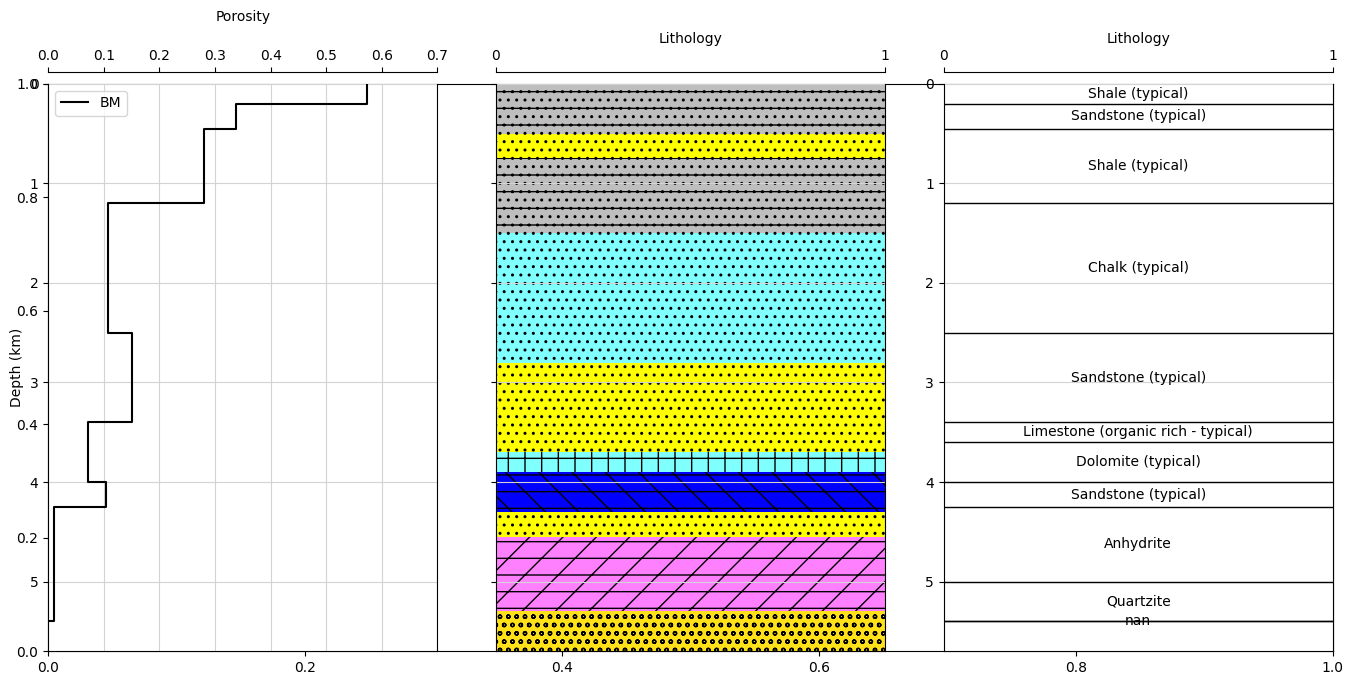

In [ ]:
makeplot_porosity(porosity_df, 0, max(decompaction_corrected_df['0.0']))

In [ ]:
# Petromod

data_ref = pd.read_excel('/content/BM/Charts_Petromod.xlsx', sheet_name='Petromod porosity', skiprows=0, header=0, engine='openpyxl')
data_ref = data_ref.applymap(lambda x: x.split('\t') if isinstance(x, str) else x)

depth_dc, porosity_plot = [],[]

# Create a sample DataFrame with shape 10x2
depth_dc = decompaction_corrected_df['0.0'].tolist()
porosity_plot = data_ref[0].tolist()

data = {
    'porosity': porosity_plot,
    'depth_dc': depth_dc
}
df = pd.DataFrame(data)

# # Repeat each column in order like 1 cell, 1 cell, 2 cell, 2 cell, 3 cell, 3 cell
# new_data = {key: [val for val in df[key] for _ in range(2)] for key in df.columns}



# Rewrite the dictionary comprehension as a list comprehension
new_data_list = [(key, [val for val in df[key] for _ in range(2)]) for key in df.columns]
new_data_list[0][1].append(0)
new_data_list[1][1].insert(0, 0)

# Display the new_data_list
print(new_data_list[0][1])

# Convert the list of tuples to a dictionary
data_dict = {key: value for key, value in new_data_list}

# Create a DataFrame from the dictionary
new_df_ref = pd.DataFrame(data_dict)

[0.5992999999999999, 0.5992999999999999, 0.4499, 0.4499, 0.41229999999999994, 0.41229999999999994, 0.2012, 0.2012, 0.225, 0.225, 0.0489, 0.0489, 0.0215, 0.0215, 0.1645, 0.1645, 0.0209, 0.0209, 0.0444, 0.0444, 0]


<ipython-input-81-5fd948905ef5>:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data_ref = data_ref.applymap(lambda x: x.split('\t') if isinstance(x, str) else x)


In [ ]:
def makeplot_porosity_2pic(property, top_depth, bottom_depth):
    # fig = plt.figure(constrained_layout=True, figsize=(10, 6))
    # ax = fig.subplots(1, 2,  sharex=False)

    fig, ax = plt.subplots(figsize=(8, 8))

    ax1 = plt.subplot2grid((1,2), (0,0), rowspan=1, colspan = 1)
    ax2 = plt.subplot2grid((1,2), (0,1), rowspan=1, colspan = 1, sharey = ax1)

    # As our curve scales will be detached from the top of the track,
    # this code adds the top border back in without dealing with splines
    # ax10 = ax1.twiny()
    # ax10.xaxis.set_visible(False)

    # ax13 = ax4.twiny()
    # ax13.xaxis.set_visible(False)

### Plot 1
    # Geotherms
    # ax1.scatter(new_df_ref['porosity'], new_df['depth_dc'], label='Petromod', color='red', lw=3)

    ax1.plot(new_df_ref['porosity'], new_df['depth_dc'], label='Petromod', color='red')
    ax1.plot(new_df['porosity'], new_df['depth_dc'], label='BM', color='black', lw=3)

    ax1.set_xlabel(f'Porosity [n/n]', labelpad=20)
    ax1.set_ylabel(f'Depth [km]')
    ax1.legend(loc='upper left')
    ax1.set_xlim(0, 0.7)

    # Lithology
    ax1.xaxis.label.set_color("black")
    ax1.tick_params(axis='x', colors="black")
    ax1.spines["top"].set_edgecolor("black")

    depth_start = 0

    for lit, depth in zip(work_layers_initial.index,work_layers_initial['Depth bottom, m']):

        key = int(lit)
        color = work_layers_initial.at[lit, 'Color']
        hatch = work_layers_initial.at[lit, 'Index']


        depth_values = [depth_start, depth]
        depth_start = depth

        ax1.fill_betweenx(depth_values, 0, 1, facecolor=color, hatch=hatch, alpha=0.2)


### Plot 2
    ax2.set_xlabel("Lithology")
    ax2.set_xlim(0, 1)
    ax2.xaxis.label.set_color("black")
    ax2.tick_params(axis='x', colors="black")
    ax2.spines["top"].set_edgecolor("black")
    ax2.set_xticks([0, 1])

    depth_start = 0

    # for lit, depth in zip(property["Lithology_type"], decompaction_corrected_df['0.0']):
    for lit, depth in zip(work_layers_initial["Lithology_type"],work_layers_initial['Depth bottom, m']):
        key = lit
        depth_values = [depth_start, depth]
        depth_start = depth

        label_position = (0.5, sum(depth_values) / 2)  # Assuming x position is at 0.5
        ax2.text(label_position[0], label_position[1], key, ha='center', va='center')
        ax2.plot([0, 1], [depth, depth], color='black', linewidth=1)  # Assuming black color and linewidth of 1


    for ax in [ax1, ax2]:
        ax.set_ylim(bottom_depth, top_depth)
        ax.grid(which='major', color='lightgrey', linestyle='-')
        ax.xaxis.set_ticks_position("top")
        ax.xaxis.set_label_position("top")
        ax.spines["top"].set_position(("axes", 1.02))

    for ax in [ax2]:
        plt.setp(ax.get_yticklabels(), visible = False)

    plt.tight_layout()
    fig.subplots_adjust(wspace = 0.15)
    return plt.savefig("porosity-depth.png")

<ipython-input-82-57ce353e1c19>:47: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error in 3.11.
  ax1.fill_betweenx(depth_values, 0, 1, facecolor=color, hatch=hatch, alpha=0.2)


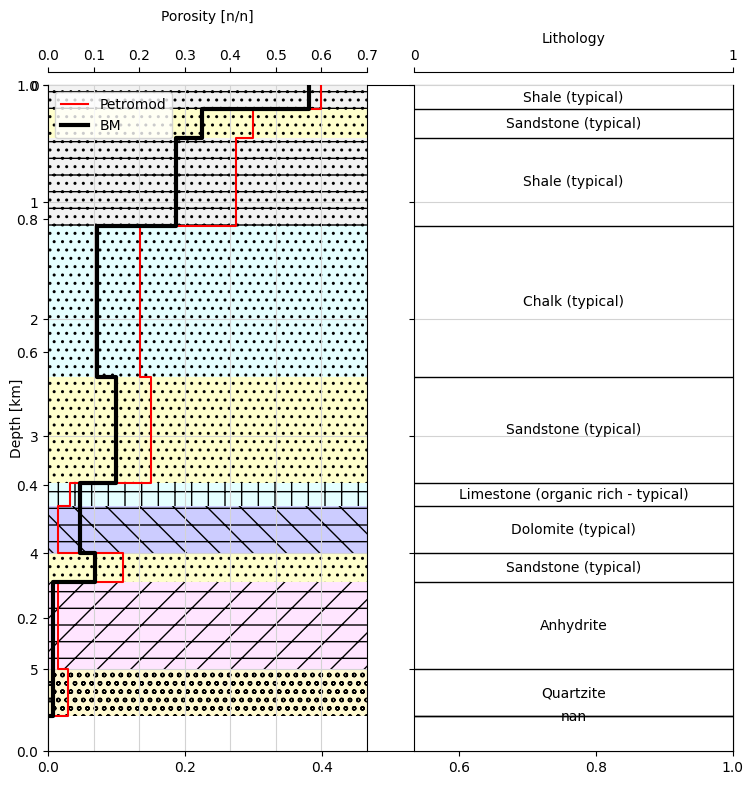

In [ ]:
makeplot_porosity_2pic(porosity_df, 0, max(decompaction_corrected_df['0.0']))

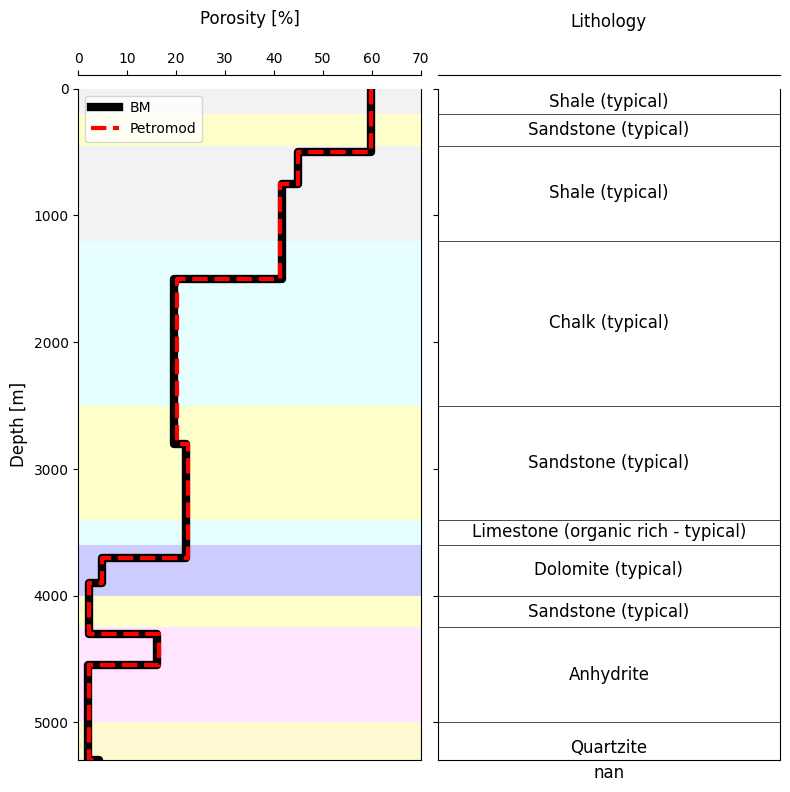

In [ ]:
def makeplot_porosity_2pic(property, top_depth=0, bottom_depth=5300):  # Default depths in meters
    fig = plt.figure(figsize=(8, 8))

    # Create subplots with shared y-axis
    ax1 = plt.subplot2grid((1,2), (0,0), rowspan=1, colspan=1)
    ax2 = plt.subplot2grid((1,2), (0,1), rowspan=1, colspan=1, sharey=ax1)

    # Convert all depth data to meters
    depth_m = new_df['depth_dc'] * 1000  # Convert km to m
    work_depths_m = work_layers_initial['Depth bottom, m'] * 1000  # Convert to meters

    # Old version data of porosity
    data_old_ver = pd.read_csv('/content/porosity_depth_data.csv')
    porosity_data = data_old_ver['porosity']
    depth_data = data_old_ver['depth_dc']
    ax1.plot(porosity_data*100, depth_data *1000,
         label='BM', color='black', lw=6)  # Your original data
    ax1.plot(new_df_ref['porosity']*100, depth_data *1000,
         '--', label='Petromod', color='red', lw=3)  # Petromod data from CSV


    # Plot 1 - Porosity (%)
    # ax1.plot(new_df['porosity']*100, depth_m, label='BM', color='black', lw=3) # BM
    # ax1.plot(new_df_ref['porosity']*100, depth_m, label='Petromod', color='red') # Petromod
    ax1.set_xlabel('Porosity [%]', labelpad=20, fontsize=12)
    ax1.set_ylabel('Depth [m]', fontsize=12)
    ax1.legend(loc='upper left')
    ax1.set_xlim(0, 70)
    ax1.set_ylim(bottom_depth, top_depth)  # Now in meters
    ax1.invert_yaxis()

    # Add lithology fills
    depth_start = 0
    for lit, depth in zip(work_layers_initial.index, work_depths_m):
        color = work_layers_initial.at[lit, 'Color']
        # hatch = work_layers_initial.at[lit, 'Index']
        ax1.fill_betweenx([depth_start, depth], 0, 70,
                          facecolor=color,
                          # hatch=hatch,
                          alpha=0.2)
        depth_start = depth

    # Plot 2 - Lithology with depth-aligned grid
    ax2.set_xlabel("Lithology", labelpad=35, fontsize=12)
    ax2.set_xlim(0, 1)
    ax2.set_xticks([])  # Remove x-axis ticks

    # Add lithology labels and horizontal grid lines at layer boundaries
    depth_start = 0
    for lit, depth in zip(work_layers_initial["Lithology_type"], work_depths_m):
        # Center text in each layer
        ax2.text(0.5, (depth_start + depth)/2, lit,
                ha='center', va='center', fontsize=12)

        # Add horizontal grid line at layer boundary
        ax2.axhline(y=depth, color='black', linewidth=0.5, linestyle='-')
        depth_start = depth

    # Common formatting
    for ax in [ax1, ax2]:
        ax.set_ylim(bottom_depth, top_depth)
        # ax.grid(True, which='major', axis='y', color='lightgrey', linestyle='-')
        ax.xaxis.set_ticks_position("top")
        ax.xaxis.set_label_position("top")
        ax.spines["top"].set_position(("axes", 1.02))

    # Hide redundant y-axis ticks on right plot
    plt.setp(ax2.get_yticklabels(), visible=False)

    plt.tight_layout()
    fig.subplots_adjust(wspace=0.05)
    plt.savefig("porosity-depth.png", dpi=300, bbox_inches='tight')
    plt.show()

makeplot_porosity_2pic(property, top_depth=0, bottom_depth=5300)

#### Tectonic driving subsidence [A58.7]

In [ ]:
decompaction_corrected_df

Lithology_type  Event_name  260.0  245.0  210.0  160.0  \
0                     Shale (typical)  Layer 10_1    0.0    0.0   0.00  0.000   
1                 Sandstone (typical)   Layer 9_1    0.0    0.0   0.00  0.000   
2                     Shale (typical)   Layer 8_1    0.0    0.0   0.00  0.000   
3                     Chalk (typical)   Layer 7_1    0.0    0.0   0.00  0.000   
4                 Sandstone (typical)   Layer 6_1    0.0    0.0   0.00  0.000   
5  Limestone (organic rich - typical)   Layer 5_1    0.0    0.0   0.00  0.000   
6                  Dolomite (typical)   Layer 4_1    0.0    0.0   0.00  0.000   
7                 Sandstone (typical)   Layer 3_1    0.0    0.0   0.00  0.629   
8                           Anhydrite   Layer 2_1    0.0    0.0   0.77  1.132   
9                           Quartzite   Layer 1_1    0.0    0.4   1.15  1.512   

   145.0  125.0  100.0   80.0   55.0   45.0   0.0  
0  0.000  0.000  0.000  0.000  0.000  0.000  0.50  
1  0.000  0.000  0.000  0.000  0.000  0.527  0.75  
2  0.000  0.000  0.000  0.000  1.237  1.375  1.50  
3  0.000  0.000  0.000  1.889  2.447  2.555  2.80  
4  0.000  0.000  1.415  2.948  3.470  3.572  3.70  
5  0.000  0.264  1.316  2.809  3.324  3.425  3.90  
6  0.615  0.931  1.926  3.378  3.884  3.984  4.30  
7  1.136  1.438  2.401  3.826  4.326  4.425  4.55  
8  1.638  1.940  2.903  4.328  4.829  4.927  5.30  
9  2.018  2.320  3.283  4.708  5.209  5.307  5.70

In [ ]:
density_column_df

0.0     45.0      55.0      80.0     100.0     125.0     145.0  \
0  2457.971  2454.99  2430.032  2408.947  2449.235  2492.979  2564.003   

      160.0     210.0   245.0  260.0  
0  2651.261  2840.109  2633.5      0

In [ ]:
### Tectonic driving subsidence [A58.7]
output_df = pd.DataFrame()
RoWater, RoMantle = 1000, 3300
# y = tectonic_subsidence(RoMantle, RoWater, density_column, thicknesses)

# decompaction_corrected_df.iloc[2:]
thicknesses = decompaction_corrected_df.iloc[:, 2:decompaction_corrected_df.shape[1]]
density_column_test = density_column_df.iloc[:, 2:density_column_df.shape[1]]


# Initialize an empty list to store the output values
output_values = []


col_name = list(density_column_test.columns)

for columns2, column_name in zip(thicknesses.columns, density_column_test.columns):
  if all(item == 0 for item in density_column_test[column_name].values):
    y = tectonic_subsidence(RoMantle, RoWater,
                            np.zeros(len(density_column_test[column_name].values)),
                            np.zeros(len(thicknesses[columns2].values)))

    output_values.append(y)

  else:
      y = tectonic_subsidence(RoMantle, RoWater,
                              density_column_test[column_name].values,
                              thicknesses[columns2].values)
      output_values.append(y)

output_df = pd.DataFrame(output_values).T[::-1].rename(columns=dict(enumerate(col_name)))

In [ ]:
output_df

55.0      80.0     100.0     125.0     145.0     160.0     210.0     245.0  \
9   0.0  0.154966  0.425382  0.530529  0.645757  0.654380  0.656444  1.364297   
8   0.0  0.000000  0.284821  0.397195  0.524158  0.547197  0.580462  1.254179   
7   0.0  0.000000  0.000000  0.220703  0.363519  0.405603  0.480086  1.108708   
6   0.0  0.000000  0.000000  0.000000  0.196799  0.262598  0.385109  0.978886   
5   0.0  0.000000  0.000000  0.000000  0.000000  0.074464  0.263138  0.813999   
4   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.282933  0.854279   
3   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.547399   
2   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
0   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

   260.0  
9    0.0  
8    0.0  
7    0.0  
6    0.0  
5    0.0  
4    0.0  
3    0.0  
2    0.0  
1    0.0  
0    0.0

#### Plot: "Tectonic subsidence Y after decompaction and backstripping" (Comparison with Petromod) [Fig. A58.2]


<ipython-input-96-42363abcfd51>:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


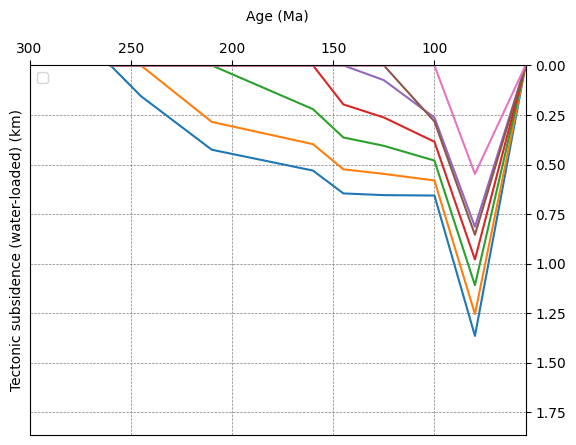

In [ ]:
age_values  = output_df.columns.astype(float).tolist()[::-1]

# work_layers_copy = work_layers.copy()

# # Plot the lines for each row in work_layers_copy
for row_index, row in output_df.iterrows():
    plt.plot(age_values, row.values)

# # Calculate sea level and sea level today
# sea_level = df_well[1:df_well.shape[0]]['Paleobathymetry, Ma'] / 1000
# sea_level_today = df_well[1:df_well.shape[0]]['Sea level, m'] / 1000

# # Plot sea level and present-day sea level
# plt.plot(age_values, (abs(sea_level - sea_level_today))[::-1], 'k--', label='Sea level')
# plt.plot(age_values, np.zeros(work_layers_copy.shape[1]), 'k--', label='present-day sea level')

# # Fill the space between the two sea level plots with blue color
# plt.fill_between(age_values, np.zeros(work_layers_copy.shape[1]),
#  (abs(sea_level - sea_level_today))[::-1], color='blue', alpha=0.2, label='Sea level' )

# Additional plotting settings
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.axis([np.round(max(age_values), -2), np.min(age_values), np.max(output_df)+0.5, 0])

plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
plt.tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)

# Move the x-axis label to the top
plt.xlabel(f'Age (Ma)', labelpad=20)
plt.ylabel(f'Tectonic subsidence (water-loaded) (km)')
plt.gca().xaxis.set_label_coords(0.5, 1.15)

plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# Display the plot
plt.show()

In [ ]:
# Data reference Petromod
data_ref = pd.read_excel('/content/BM/Charts_Petromod.xlsx', sheet_name='Petromod Depth', skiprows=0, header=0, engine='openpyxl')
# data_ref = data_ref.applymap(lambda x: x.split('\t') if isinstance(x, str) else x)
data_ref = data_ref.apply(lambda x: x.str.split('\t') if x.dtype == 'object' else x)

In [ ]:
decompaction_corrected_df

Lithology_type  Event_name  260.0  245.0  210.0  160.0  \
0                     Shale (typical)  Layer 10_1    0.0    0.0   0.00  0.000   
1                 Sandstone (typical)   Layer 9_1    0.0    0.0   0.00  0.000   
2                     Shale (typical)   Layer 8_1    0.0    0.0   0.00  0.000   
3                     Chalk (typical)   Layer 7_1    0.0    0.0   0.00  0.000   
4                 Sandstone (typical)   Layer 6_1    0.0    0.0   0.00  0.000   
5  Limestone (organic rich - typical)   Layer 5_1    0.0    0.0   0.00  0.000   
6                  Dolomite (typical)   Layer 4_1    0.0    0.0   0.00  0.000   
7                 Sandstone (typical)   Layer 3_1    0.0    0.0   0.00  0.629   
8                           Anhydrite   Layer 2_1    0.0    0.0   0.77  1.132   
9                           Quartzite   Layer 1_1    0.0    0.4   1.15  1.512   

   145.0  125.0  100.0   80.0   55.0   45.0   0.0  
0  0.000  0.000  0.000  0.000  0.000  0.000  0.50  
1  0.000  0.000  0.000  0.000  0.000  0.527  0.75  
2  0.000  0.000  0.000  0.000  1.237  1.375  1.50  
3  0.000  0.000  0.000  1.889  2.447  2.555  2.80  
4  0.000  0.000  1.415  2.948  3.470  3.572  3.70  
5  0.000  0.264  1.316  2.809  3.324  3.425  3.90  
6  0.615  0.931  1.926  3.378  3.884  3.984  4.30  
7  1.136  1.438  2.401  3.826  4.326  4.425  4.55  
8  1.638  1.940  2.903  4.328  4.829  4.927  5.30  
9  2.018  2.320  3.283  4.708  5.209  5.307  5.70

BMMMMMM 1 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.527 0.75 ]
BMMMMMM 2 [0.    0.    0.    0.    0.    0.    0.    0.    1.237 1.375 1.5  ]
BMMMMMM 3 [0.    0.    0.    0.    0.    0.    0.    1.889 2.447 2.555 2.8  ]
BMMMMMM 4 [0.    0.    0.    0.    0.    0.    1.415 2.948 3.47  3.572 3.7  ]
BMMMMMM 5 [0.    0.    0.    0.    0.    0.264 1.316 2.809 3.324 3.425 3.9  ]
BMMMMMM 6 [0.    0.    0.    0.    0.615 0.931 1.926 3.378 3.884 3.984 4.3  ]
BMMMMMM 7 [0.    0.    0.    0.629 1.136 1.438 2.401 3.826 4.326 4.425 4.55 ]
BMMMMMM 8 [0.    0.    0.77  1.132 1.638 1.94  2.903 4.328 4.829 4.927 5.3  ]
BMMMMMM 9 [0.    0.4   1.15  1.512 2.018 2.32  3.283 4.708 5.209 5.307 5.7  ]
Petromod 1 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.584 0.75 ]
Petromod 2 [0.    0.    0.    0.    0.    0.    0.    0.    1.226 1.373 1.5  ]
Petromod 3 [0.    0.    0.    0.    0.    0.    0.    2.011 2.597 2.698 2.8  ]
Petromod 4 [0.    0.    0.    0.    0.    0.    1.411 2.959 3

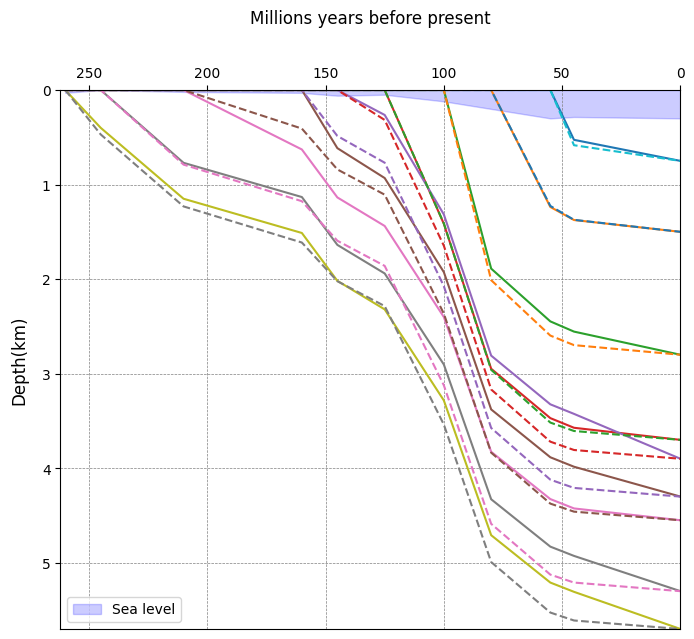

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(8, 7))

    # Our data
work_layers = decompaction_corrected_df.drop(['Lithology_type', 'Event_name'], axis=1, inplace=False)
# age_values = [int(age.split(' Ma')[0]) for age in work_layers.columns.tolist()]
age_values = [int(float(age.split(' Ma')[0])) for age in work_layers.columns.tolist()]
work_layers_copy = work_layers.copy()

# Plot the lines for each row in work_layers_copy
for row_index, row in work_layers_copy[1::].iterrows():
  print('BMMMMMM', row_index, row.values)
  plt.plot(age_values, row.values, linestyle='solid')

    # Petromode
work_layers = data_ref.drop(['Unnamed: 0', 'Lithology_type', 'Event_name'], axis=1, inplace=False)
work_layers_copy = work_layers.copy()

for row_index, row in work_layers_copy[1::].iterrows():
  print('Petromod', row_index, row.values)
  plt.plot(age_values, row.values, linestyle='dashed')

# Calculate sea level and sea level today
sea_level = df_well[1:df_well.shape[0]]['Paleobathymetry, Ma'] / 1000
sea_level_today = df_well[1:df_well.shape[0]]['Sea level, m'] / 1000

# # Plot sea level and present-day sea level
# plt.plot(age_values, (abs(sea_level - sea_level_today))[::-1], 'k--', label='Sea level')
# plt.plot(age_values, np.zeros(work_layers_copy.shape[1]), 'k--', label='present-day sea level')

# Fill the space between the two sea level plots with blue color
plt.fill_between(age_values, np.zeros(work_layers_copy.shape[1]),
 (abs(sea_level - sea_level_today))[::-1], color='blue', alpha=0.2, label='Sea level' )

# Additional plotting settings
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
# plt.axis([np.round(max(age_values), -2), np.min(age_values), np.max(work_layers_copy), -1])
plt.axis([262, 0, np.max(work_layers_copy), 0])

plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
# plt.tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)

# Move the x-axis label to the top
plt.xlabel(f'Millions years before present', labelpad=10, fontsize=12)
plt.ylabel(f'Depth(km)', labelpad=10, fontsize=12)
plt.gca().xaxis.set_label_coords(0.5, 1.15)

plt.legend(loc='lower left')
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# Display the plot
plt.show()
plt.savefig("age-depth.png")

### FOR SKOLKOVO APPLICATION

<ipython-input-11-77bd775055fb>:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('jet').reversed()


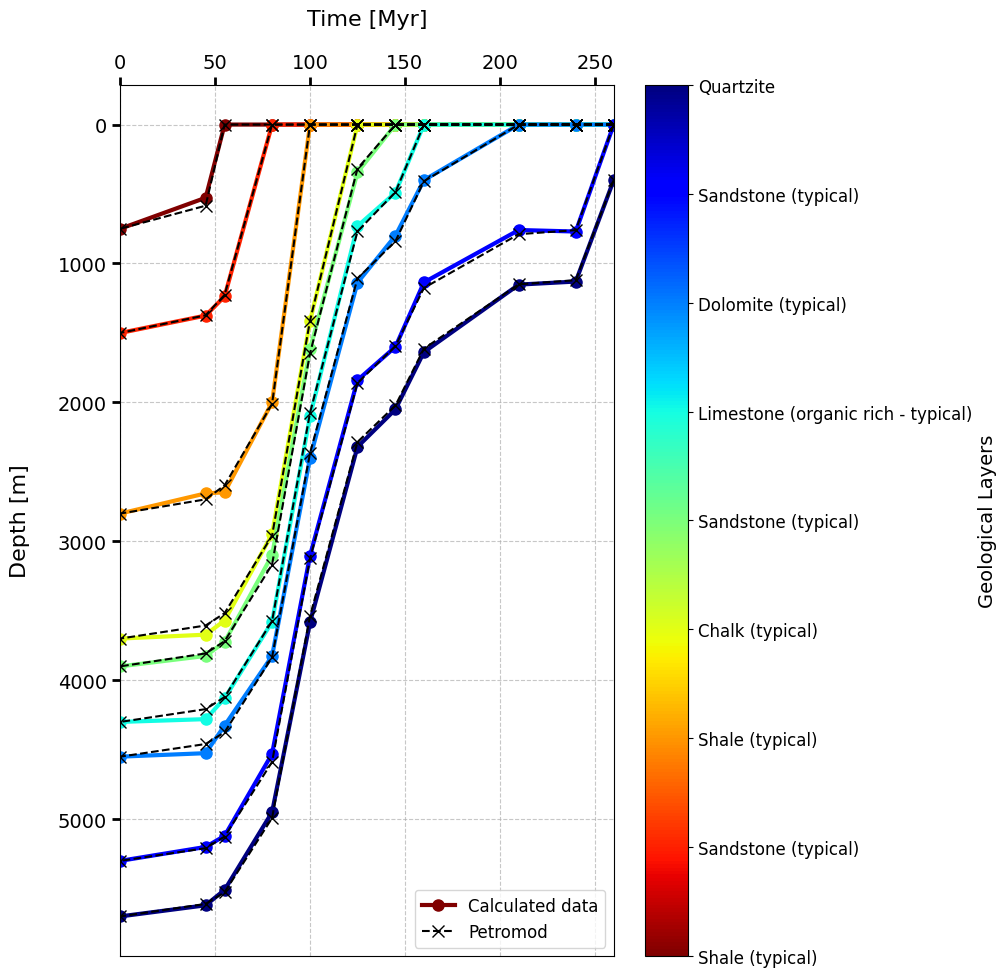

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
import numpy as np
import pandas as pd

def plot_pressure_profiles(lithostatic_pressure_df, data_petromod):
    ages = lithostatic_pressure_df.columns.astype(float).values

    geological_layer_names = [
        'Shale (typical)',
        'Sandstone (typical)',
        'Shale (typical)',
        'Chalk (typical)',
        'Sandstone (typical)',
        'Limestone (organic rich - typical)',
        'Dolomite (typical)',
        'Sandstone (typical)',
        'Quartzite',
        'Anhydrite',
    ]

    # Create figure with larger size
    fig, ax1 = plt.subplots(1, 1, figsize=(10, 10))

    # Set global font size
    plt.rcParams.update({'font.size': 14})

    # --- Plot 1: Porosity profiles ---
    colormap = cm.get_cmap('jet').reversed()
    norm_lith = Normalize(vmin=0, vmax=len(lithostatic_pressure_df)-1)

    # Plot calculated data
    for idx, (index, row) in enumerate(lithostatic_pressure_df.iterrows()):
        color = colormap(norm_lith(idx))
        label1 = 'Calculated data' if idx == 0 else None
        ax1.plot(ages, row*1000, color=color, lw=3, marker='o',
                markersize=8, label=label1)

    # Plot Petromod data
    for idx2, (index2, row2) in enumerate(data_petromod.iterrows()):
        label2 = 'Petromod' if idx2 == 0 else None
        ax1.plot(ages, row2*1000, color='black', lw=1.5, marker='x',
                markersize=8, linestyle='--', label=label2)

    # Enhanced axis formatting
    ax1.set_ylabel('Depth [m]', labelpad=20, fontsize=16)
    ax1.set_xlabel('Time [Myr]', labelpad=20, fontsize=16)
    ax1.invert_yaxis()
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.set_xlim(0, 260)

    # Make ticks larger
    ax1.tick_params(axis='both', which='major', labelsize=14, width=2, length=6)
    ax1.tick_params(axis='both', which='minor', labelsize=12, width=1, length=4)

    # Move x-axis to top
    ax1.xaxis.set_label_position("top")
    ax1.xaxis.set_ticks_position("top")

    # Add colorbar for geological layers
    sm_lith = cm.ScalarMappable(cmap=colormap, norm=norm_lith)
    sm_lith.set_array([])
    cbar_lith = plt.colorbar(
        sm_lith,
        ax=ax1,
        ticks=np.arange(len(geological_layer_names)),
    )
    cbar_lith.set_ticklabels(geological_layer_names)
    cbar_lith.set_label("Geological Layers", fontsize=14)
    cbar_lith.ax.tick_params(labelsize=12)

    # Add legend with larger font
    ax1.legend(prop={'size': 12}, loc='lower right')

    plt.tight_layout()
    plt.savefig('porosity_with_geology.png', dpi=300, bbox_inches='tight')
    plt.show()

# Usage:
# Load and prepare data
data = pd.read_excel('/content/Porosity-Petromod.xlsx', sheet_name='Our')
data = data.drop(0).reset_index(drop=True)
data_petromod = pd.read_excel('/content/Porosity-Petromod.xlsx', sheet_name='Petromod')
data_petromod = data_petromod.drop(0).reset_index(drop=True)

plot_pressure_profiles(data, data_petromod)

In [ ]:
pd.concat([
    decompaction_corrected_df.drop(['Lithology_type', 'Event_name'], axis=1).add_prefix('Our_'),
    data_ref.drop(['Unnamed: 0', 'Lithology_type', 'Event_name'], axis=1).add_prefix('Petromod_'),
    pd.DataFrame({
        'Age_Ma': age_values,
        'Sea_level_km': (abs(sea_level - sea_level_today))[::-1],
        'Depth_km': df_well.iloc[1:]['Paleobathymetry, Ma']/1000
    })
], axis=1).to_csv('age_depth_plot_data.csv', index=False)

In [ ]:
decompaction_corrected_df

Lithology_type Event_name  260     245     210     160  \
0                                 NaN        NaN  0.0   0.000   0.000   0.000   
1                     Shale (typical)   Layer 10  0.0   0.000   0.000   0.000   
2                 Sandstone (typical)    Layer 9  0.0   0.000   0.000   0.000   
3                     Shale (typical)    Layer 8  0.0   0.000   0.000   0.000   
4                     Chalk (typical)    Layer 7  0.0   0.000   0.000   0.000   
5                 Sandstone (typical)    Layer 6  0.0   0.000   0.000   0.000   
6  Limestone (organic rich - typical)    Layer 5  0.0   0.000   0.000   0.000   
7                  Dolomite (typical)    Layer 4  0.0   0.000   0.000  25.093   
8                 Sandstone (typical)    Layer 3  0.0   0.000  26.745  25.595   
9                           Anhydrite    Layer 2  0.0  27.525  27.125  25.975   

      145     125     100      80      55      45     0  
0   0.000   0.000   0.000   0.000   0.000   0.000  0.50  
1   0.000   0.000   0.000   0.000   0.000   6.136  0.75  
2   0.000   0.000   0.000   0.000  10.967   6.652  1.50  
3   0.000   0.000   0.000  15.744  11.941   7.628  2.80  
4   0.000   0.000  19.285  16.608  12.811   8.519  3.70  
5   0.000  21.044  19.120  16.444  12.647   8.355  3.90  
6  23.309  21.570  19.646  16.970  13.174   8.886  4.30  
7  23.721  21.981  20.058  17.382  13.587   9.303  4.55  
8  24.224  22.484  20.561  17.885  14.089   9.806  5.30  
9  24.604  22.864  20.941  18.265  14.469  10.186  5.70

### Step 4: Thermal conductivity of the basin-fill

In [ ]:
def bulk_thermal_conductivity(tc_matrix, tc_inclusion, porosity):
  return tc_matrix*(1-porosity) + tc_inclusion*porosity

In [ ]:
def bulk_thermal_conductivity_geomean(tc_matrix, tc_inclusion, porosity):
  return tc_inclusion**porosity * tc_matrix**(1-porosity)

In [ ]:
def geotherm_constant_heat(surface_T, basal_HF, depth, tc_bulk):
  return surface_T + (-basal_HF*depth * tc_bulk**-1)

In [ ]:
tc_bulk_df = pd.DataFrame()

age_list = list(work_layers_with_color['Age (Ma)'][0:])
# age_list  = work_layers.columns.astype(float)
# age_list = work_layers.columns.tolist()
print(age_list)

for i, age in enumerate(age_list, start=0):

    work_layers_copy = work_layers_with_color.copy()
    print(age)

    tc_bulk_list = []

    # thinkness_list = []
    # thinkness_corrected_list = []
    # porosity_average_list = []
    # porosity_test = []
    # density_list = []
    # density_column = []
    # density_column_total = []

    RoWater, RoMantle = 1000, 3300
    tc_water = 0.60

    sea_level = work_layers_copy.loc[work_layers_copy['Lithology_type'] == str(lithology), 'Paleobathymetry, Ma'].iloc[0]/1000
    sea_level_today = work_layers_copy.loc[work_layers_copy['Lithology_type'] == str(lithology), 'Sea level, m'].iloc[0]/1000

    print('Age', age)

    ### расчет corrected_decompaction for Fundament (not in work_layer)
    if int(age) == age_list[-1]:
          tc_bulk = 0
          tc_bulk_list.append(tc_bulk)


### расчет для слоев с заданной литологией (work_layers)
    for row_index, row in enumerate(work_layers_copy[i::].itertuples(), start=i):

      lithology = work_layers_copy.at[row.Index, 'Lithology_type']
      layers_name = work_layers_copy.at[row.Index, 'Event_name']
      phi0 = porosity_df.loc[(porosity_df['Lithology_type'] == str(lithology)) & (porosity_df['Event_name'] == layers_name), f'{age}'].iloc[0]
      tc_matrix = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'TC matrix'].iloc[0]

      # c = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'Exp_decay, km-1'].iloc[0]
      # RoGrain = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'Grain density'].iloc[0]
      # y1 = df_well.loc[df_well['Event_name'] == str(layers_name), 'Depth top, m'].iloc[0]
      # y2 = df_well.loc[df_well['Event_name'] == str(layers_name), 'Depth bottom, m'].iloc[0]

### Bulk thermal conductivity
      # tc_bulk = bulk_thermal_conductivity(tc_matrix, tc_water, phi0)
      tc_bulk = bulk_thermal_conductivity_geomean(tc_matrix, tc_water, phi0)
      tc_bulk_list.append(tc_bulk)

      print(row_index, lithology, layers_name, phi0, tc_bulk)


### Save results in table
    new_col_name = f'{age}'
    ### Save result for decompaction in table
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(tc_bulk_list):] = tc_bulk_list
    new_col_values = resized_list_new
    tc_bulk_df[new_col_name] = new_col_values

NameError: name 'work_layers_with_color' is not defined

In [ ]:
### добавление колонок Lithology_type,	Event_name
work_layers.reset_index(drop=True, inplace=True)
tc_bulk_df['Event_name'] = work_layers_with_color['Event_name']
tc_bulk_df['Lithology_type'] = work_layers_with_color['Lithology_type']
tc_bulk_df= tc_bulk_df[tc_bulk_df.columns[::-1]]

tc_bulk_df.to_csv('/content/TC_bulk.csv', index=True)

In [ ]:
tc_bulk_df

Lithology_type  Event_name     245.0     210.0     160.0     145.0  \
0         Shales  Layer 10_1  0.000000  0.000000  0.000000  0.000000   
1     Sandstones   Layer 9_1  0.000000  0.000000  0.000000  0.000000   
2         Shales   Layer 8_1  0.000000  0.000000  0.000000  0.000000   
3          Chalk   Layer 7_1  0.000000  0.000000  0.000000  0.000000   
4     Sandstones   Layer 6_1  0.000000  0.000000  0.000000  0.000000   
5     Limestones   Layer 5_1  0.000000  0.000000  0.000000  0.000000   
6       Dolomite   Layer 4_1  0.000000  0.000000  0.000000  3.627857   
7     Sandstones   Layer 3_1  0.000000  0.000000  1.963064  2.212554   
8      Anhydrite   Layer 2_1  0.000000  5.654131  5.694157  5.747966   
9      Quartzite   Layer 1_1  4.777836  5.277843  5.497812  5.726949   

      125.0     100.0      80.0      55.0      45.0       0.0  
0  0.000000  0.000000  0.000000  0.000000  0.000000  0.972357  
1  0.000000  0.000000  0.000000  0.000000  1.928576  2.033901  
2  0.000000  0.000000  0.000000  1.086252  1.159220  1.212027  
3  0.000000  0.000000  1.665822  2.199417  2.295180  2.366700  
4  0.000000  2.178504  3.030594  3.260474  3.318780  3.370652  
5  1.768240  2.423864  2.908889  2.999533  3.020057  3.035541  
6  3.856041  4.501078  4.953886  5.040980  5.051974  5.062992  
7  2.364613  2.925044  3.586377  3.765516  3.815907  3.849875  
8  5.775061  5.870903  5.968335  5.996469  6.010585  6.010585  
9  5.860011  6.294075  6.760291  6.864603  6.899731  6.917361

## Step 5. Calculation of the geotherm with variable thermal conductivity (a constant heat flow from the mantle)



## Step 6. The radiogenic heat contribution: Eqn. [A58.10]

In [ ]:
def linear_geotherm(G, y):
  return G*y

In [ ]:
def linear_geotherm_2(T0, qm, A, yc, depth, K):
  return T0 + ((-Qm + A*yc)/K)*depth - (A/(2*K)*depth**2)

In [ ]:
work_layers_copy_initial.columns

Index(['Well', 'Event_name', 'Event_type', 'Lithology_type', 'Age (Ma)',
       'Depth top, m', 'Depth bottom, m', 'Thickness, m',
       'D Thickness (erosion), m', 'Paleobathymetry, Ma', 'Sea level, m',
       'Sublayers', 'N sublayers', 'PSE', 'Kinetic', 'TOC initial, %',
       'HI initial, %'],
      dtype='object')

### Ap.13: Effects of variable radiogenic heating and thermal conductivity on the geotherm in the basin-fill - CHECK

In [ ]:
df_constast

Lithology_type  Porosity  Exp_decay, km-1  Grain density  TC matrix  \
0         Shales      0.63             0.51           2720        2.0   
1     Sandstones      0.49             0.27           2650        5.5   
2          Chalk      0.70             0.71           2710        3.3   
3     Limestones      0.40             0.60           2710        3.3   
4       Dolomite      0.20             0.60           2870        5.3   
5      Anhydrite      0.05             0.20           2960        6.3   
6      Quartzite      0.20             0.30           2650        7.7   
7      Fundament      0.00             0.00           2800        3.0   

   Radiogenic Heat Production  Ki_framework  
0                1.700000e-06           2.0  
1                1.200000e-06           5.5  
2                4.000000e-07           3.3  
3                5.000000e-07           3.3  
4                4.000000e-07           5.3  
5                1.000000e-07           6.3  
6                5.000000e-07           7.7  
7                2.800000e-06           3.0

In [ ]:
T_with_rad_heat = pd.DataFrame()
T_without_rad_heat = pd.DataFrame()
T_linear_geotherm =  pd.DataFrame()

# age_list = list(work_layers_with_color['Age (Ma)'][1:2])
# age_list = list(work_layers['Age (Ma)'][1:2])
age_list = list(work_layers_initial['Age (Ma)'][1:2])
print(age_list)


for i, age in enumerate(age_list, start=0):

    work_layers_copy = work_layers_initial.copy()
    # work_layers_copy = work_layers_with_color.copy()

    T_list = []
    T_list_constant = []
    T_linear_geotherm_values = []


    Qm = 0
    T0 = 15
    G = 20

    print('Age', age)


    sum_variables_1, sum_variables_2 = [], []
    sum_variables_3, sum_variables_4 = [], []
    sum_variables_5 = []
    layers_sum = []
    layers_sum_1 = []



### расчет для слоев с заданной литологией (work_layers)
    for row_index, row in enumerate(work_layers_copy[i::].itertuples(), start=i):

      lithology = work_layers_copy.at[row.Index, 'Lithology_type']
      layers_name = work_layers_copy.at[row.Index, 'Event_name']

      print(lithology)

      A = df_constast.loc[work_layers['Lithology_type'] == str(lithology), 'Layer radiogenic\nheat production'].iloc[0] * 10**-6
      K = work_layers.loc[work_layers['Lithology_type'] == str(lithology), 'Layer bulk\nconductivity'].iloc[0]

      thickness_layer = work_layers.loc[work_layers['Lithology_type'] == str(lithology), 'Thickness, m'].iloc[0]

      crust_depth = 5

      depth = work_layers.loc[work_layers['Lithology_type'] == str(lithology), 'Depth bottom, m'].iloc[0]

### With radio heat
      Qm = 30*10**-3 # Qm = 30 - ни где не указано в книги, сама подобрала
      if K == 0:
        sum_variables_1.append(0)
        sum_variables_2.append(0)
      else:
        layers_sum.append(thickness_layer)
        crust_depth = sum(layers_sum)

        sum_variables_1.append(((Qm+A*crust_depth)/K)*thickness_layer)
        sum_variables_2.append((A/(2*K))*(thickness_layer)**2)


      T = T0 + (sum(sum_variables_1) - sum(sum_variables_2))
      T_list.append(T)

      print(row_index, lithology, crust_depth, thickness_layer, K, A, T_list)

### without radio heat

      Qm = 25*10**-3
      A = 2.5 * 10**-6
      K= 3

###!!!!!!!!!!!!!!!!!!!!!! crust depth = 5km and change for each layer
      layers_sum_1.append(thickness_layer)
      crust_depth = sum(layers_sum_1)
###!!!!!!!!!!!!!!!!!!!!!!
      if K == 0:
        sum_variables_3.append(0)
      else:
        sum_variables_3.append(((Qm+A*crust_depth)/K)*thickness_layer)
        sum_variables_4.append((A/(2*K))*(thickness_layer)**2)

      T_no_heat = T0 + (sum(sum_variables_3) - sum(sum_variables_4))
      T_list_constant.append(T_no_heat)


# ### Linear teady-stage geotherm Appendix 12
      Qm = -60 * 10**-3
      A = 0
      yc = 30 *1000
      K= 3
      depth *=1000

      # T_linear_geotherm_values.append(T0 + ((-Qm + A*yc)/K)*depth - (A/(2*K)*depth**2))

      T_linear_geotherm_values.append(linear_geotherm_2(T0, qm, A, yc, depth, K))

      print(T_list_constant)
      print(T_linear_geotherm_values)

### Save results in table

### with radio heat
    new_col_name = f'{age}'
    ### Save result for decompaction in table
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(T_list):] = T_list
    new_col_values = resized_list_new
    T_with_rad_heat[new_col_name] = new_col_values

### without radio heat
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(T_list_constant):] = T_list_constant
    new_col_values = resized_list_new
    T_without_rad_heat[new_col_name] = new_col_values


### Linear teady-stage geotherm Appendix 12
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(T_list_constant):] = T_linear_geotherm_values
    new_col_values = resized_list_new
    T_linear_geotherm[new_col_name] = new_col_values

[45]
Age 45
Shales


KeyError: 'Layer radiogenic\nheat production'

In [ ]:
T0 = 15
Linear = T_linear_geotherm["0.0"].tolist()
Linear.insert(0, T0)


A_line = T_without_rad_heat["0.0"].tolist()
A_line.insert(0, T0)

C_line = T_with_rad_heat["0.0"].tolist()
C_line.insert(0, T0)

KeyError: '0'

In [ ]:
y = work_layers["Depth bottom, m"].tolist()
y_add = y.insert(0, 0)

print(Linear, y)

plt.figure(figsize=(4, 8))
plt.plot(A_line, y , label='A (A added and constant)', marker='o', color='green')
# plt.plot(T_true['0'], y , label='McKenzie')
plt.plot(Linear, y , label='B Linear Geotherm', marker='o', color='red')
plt.plot(C_line, y , label='C (A & K variable)', marker='o', color='blue')


# plt.axis([np.round(max(age_values), -2), np.min(age_values), np.max(output_df)+0.5, 0])

plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
# plt.tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)

# Move the x-axis label to the top
plt.xlabel(f'Tempreture', labelpad=20)
plt.ylabel(f'Depth (km)')
# plt.gca().xaxis.set_label_coords(0.5, 1.15)

plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)

plt.xlim(0, 140)
plt.ylim(0, 5)
plt.gca().invert_yaxis()
plt.show()

NameError: name 'Linear' is not defined

## Step 7. Calculation of the stretch factor

In [ ]:
import warnings
from scipy import stats

warnings.filterwarnings("ignore")
warnings.filterwarnings("default")

In [ ]:
from scipy.stats import linregress
from scipy.optimize import fsolve

In [ ]:
output_df

260     245.0     210.0     160.0     145.0     125.0     100.0      80.0  \
9  0.0  0.196275  0.319325  0.550230  0.658339  0.778836  1.312422  1.938154   
8  0.0  0.000000  0.206856  0.405402  0.524170  0.639692  1.156298  1.780901   
7  0.0  0.000000  0.005231  0.226620  0.356263  0.464282  0.954996  1.574239   
6  0.0  0.000000  0.000000  0.091932  0.179004  0.284301  0.764234  1.389831   
5  0.0  0.000000  0.000000  0.000000  0.025108  0.074658  0.534992  1.159597   
4  0.0  0.000000  0.000000  0.000000  0.000000 -0.027347  0.580644  1.218002   
3  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.105552  0.779754   
2  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.064106   
1  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
0  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

       55.0      45.0       0.0  
9  2.066518  2.083039  2.121120  
8  1.914610  1.933549  1.971856  
7  1.714126  1.736065  1.774517  
6  1.537517  1.562611  1.601599  
5  1.314736  1.343265  1.382485  
4  1.373147  1.401171  1.440637  
3  0.963520  1.001053  1.043482  
2  0.473306  0.534899  0.589200  
1  0.119558  0.207851  0.281877  
0  0.000000  0.105131  0.196400

In [ ]:
# Define beta=stretch factor
def stretch_factor(beta):
  return E0 * (beta/np.pi) * np.sin(np.pi/beta) - slope


stretch_factor_df = pd.DataFrame()

tau = 50

for age in output_df.columns:

    col_list = list(output_df[age])
    thermal_subsidenence = col_list[::-1]

    if all(item == 0 for item in thermal_subsidenence):
        pass
    else:
        non_zero_values = [value for value in thermal_subsidenence if value != 0]
        time = np.array(work_layers_with_color['Age (Ma)'][0:len(non_zero_values)])

        x = 1-np.exp(-time/tau)
        y = list(map(lambda x: x * 1000, non_zero_values))

        # Perform linear regression
        slope, intercept, r_value, p_vzalue, std_err = linregress(x, y)

        # Calculate E0

        # Constant value - pp.497 (pdf), Table A19.1
        Tm = 1330
        yl = 125
        alpha_v =3.28*10**-5 #CLTE
        RoWater, RoMantle = 1030, 3300

        # # Example from book
        # slope, E0 = 1368, 3212

        E0 = (4*yl*RoMantle*alpha_v*Tm)/(np.pi**2*(RoMantle - RoWater))*1000 # [m]

        beta = fsolve(stretch_factor, 1.0)[0]

        # print(age, f"The value of beta is: {beta:.2f}")

        # Save results in table
        new_col_name = f'{age}'
        stretch_factor_df[new_col_name] = [beta]

/usr/local/lib/python3.11/dist-packages/scipy/stats/_stats_py.py:10919: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/usr/local/lib/python3.11/dist-packages/scipy/stats/_stats_py.py:10933: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/usr/local/lib/python3.11/dist-packages/scipy/stats/_stats_py.py:10936: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
<ipython-input-60-518c6f570b81>:40: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  beta = fsolve(stretch_factor, 1.0)[0]


In [ ]:
stretch_factor_df.to_csv('/content/Stretch_factor.csv', index=True)

In [ ]:
stretch_factor_df

245.0     210.0     160.0     145.0     125.0    100.0      80.0      55.0  \
0    1.0  1.133921  1.161519  1.216934  1.270136  1.41296  1.786182  1.874711   

       45.0       0.0  
0  1.938919  1.887522

In [ ]:
for age in output_df.columns:

  col_list = list(output_df[age])
  thermal_subsidence = col_list[::-1]


  if all(item == 0 for item in thermal_subsidence):
      pass
  else:

    tau = 50
    non_zero_values = [value for value in thermal_subsidence if value != 0]

    time_array = output_df.columns.astype(float).tolist()
    time = np.array(time_array[0:len(non_zero_values)+1])

In [ ]:
beta = stretch_factor_df["0.0"].iloc[0] # Значение, используемое для следующих расчетов
beta

np.float64(1.8875223217896107)

## Step 8. Calculation of paleotemperatures using the reference uniform stretching model



#### Heat Flow: subsiding only

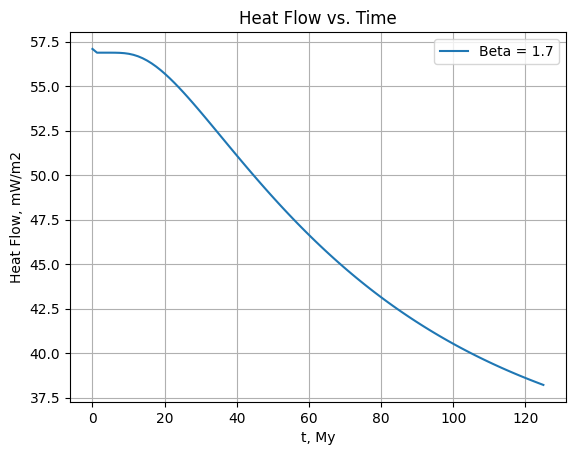

In [ ]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

def heat_flux(beta, t):

    # Define the variables and parameters
    a = 125
    tau = 62.8
    lam = 3.5
    T1 = 1333
    N = 100  # Number of terms in the sum

    # Define the equation for T/Tm with z as a variable
    T_sum = 0
    for n in range(1, N+1):
        Cn = beta / (n * np.pi) * np.sin(n * np.pi / beta) * np.exp(-n**2 * t / tau)
        T_sum += Cn
    T_over_Tm = 0.8 * (1 + 2 * T_sum) # 0.8 = 34.5 mW/m2

    return T_over_Tm * 10**-3 * 60 * 697


# beta_list = [1, 1.25, 1.5, 2, 4]
beta_list = [1.7]
t = np.linspace(0, 125, 100)

plt.figure()
for beta in beta_list:
    plt.plot(t, heat_flux(beta, t), label=f'Beta = {beta}')

plt.xlabel('t, My')
plt.ylabel('Heat Flow, mW/m2')
plt.title('Heat Flow vs. Time')
plt.grid(True)
plt.legend()
# plt.ylim(0, 140)
plt.show()

#### Temperature calculation (variable Heat Flow (F) for diffrent age)

In [ ]:
# import numpy as np
# import sympy as sp
# import matplotlib.pyplot as plt


def heat_flow_fundament_calculation(beta, t, Q_const, constant=False):

  ###
  # concstant = True: постоянный тепловой поток Q_const
  # Q_const: значение постоянного теплового потока, mW/m2

  ###

  if constant == True:
    return Q_const

  else:

    def tau_heat_flux(a, k):
      tau = a**2/(k * np.pi**2) # [second]
      # convert second to yaers, than to Million years
      seconds = tau
      years = seconds / 60 / 60 / 24 / 365.25  # Considering leap years
      return years * 10**-6 # [Myr]


    def heat_flux(beta, t):

        # Define the variables and parameters of lithosphere
        a = 125 * 1000 #m an initial lithosphere thickness
        k = 10**-6 #m2 s-1 thermal diffusivity of lithospheric rocks

        tau = tau_heat_flux(a, k)  # Myr Lithospheric time constant
        # tau = 62.8
        lam = 3.5 # Lithospheric thermal conductivity [W/mK]

        T1 = 1333
        N = 100 # Number of terms in the sum

        # Define the equation for F with z as a variable
        F_sum = 0
        for n in range(1, N+1):
            Cn = beta / (n * np.pi) * np.sin(n * np.pi / beta) * np.exp(-n**2 * t / tau)
            F_sum += Cn
        F_over_Tm = (lam*T1/a) * (1 + 2 * F_sum) # [mW/m2]
        return F_over_Tm

    return heat_flux(beta, t)

In [ ]:
tc_bulk_df

Lithology_type  Event_name     245.0     210.0     160.0     145.0  \
0         Shales  Layer 10_1  0.000000  0.000000  0.000000  0.000000   
1     Sandstones   Layer 9_1  0.000000  0.000000  0.000000  0.000000   
2         Shales   Layer 8_1  0.000000  0.000000  0.000000  0.000000   
3          Chalk   Layer 7_1  0.000000  0.000000  0.000000  0.000000   
4     Sandstones   Layer 6_1  0.000000  0.000000  0.000000  0.000000   
5     Limestones   Layer 5_1  0.000000  0.000000  0.000000  0.000000   
6       Dolomite   Layer 4_1  0.000000  0.000000  0.000000  3.627857   
7     Sandstones   Layer 3_1  0.000000  0.000000  1.963064  2.212554   
8      Anhydrite   Layer 2_1  0.000000  5.654131  5.694157  5.747966   
9      Quartzite   Layer 1_1  4.777836  5.277843  5.497812  5.726949   

      125.0     100.0      80.0      55.0      45.0       0.0  
0  0.000000  0.000000  0.000000  0.000000  0.000000  0.972357  
1  0.000000  0.000000  0.000000  0.000000  1.928576  2.033901  
2  0.000000  0.000000  0.000000  1.086252  1.159220  1.212027  
3  0.000000  0.000000  1.665822  2.199417  2.295180  2.366700  
4  0.000000  2.178504  3.030594  3.260474  3.318780  3.370652  
5  1.768240  2.423864  2.908889  2.999533  3.020057  3.035541  
6  3.856041  4.501078  4.953886  5.040980  5.051974  5.062992  
7  2.364613  2.925044  3.586377  3.765516  3.815907  3.849875  
8  5.775061  5.870903  5.968335  5.996469  6.010585  6.010585  
9  5.860011  6.294075  6.760291  6.864603  6.899731  6.917361

[0.0, 45.0, 55.0, 80.0, 100.0, 125.0, 145.0, 160.0, 210.0, 245.0]
0.0 63.685954533544326
45.0 52.870550930991655
55.0 50.17116620969431
80.0 45.191873652900995
100.0 42.61346524273573
125.0 40.53928690306466


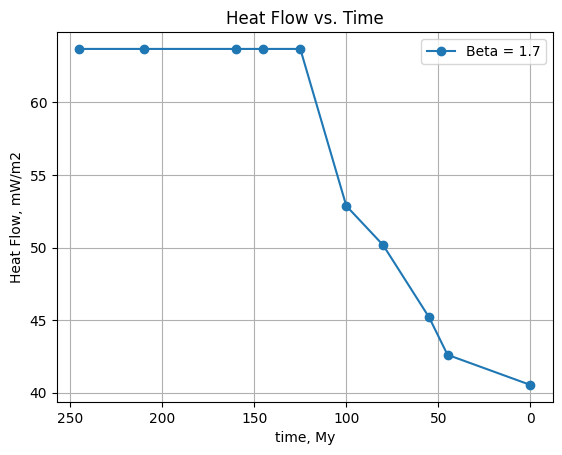

Age 0.0
0 Shales 200.0 200.0 0.04053928690306466
1 Sandstones 450.0 250.0 0.04053928690306466
2 Shales 1200.0 750.0 0.04053928690306466
3 Chalk 2500.0 1300.0 0.04053928690306466
4 Sandstones 3400.0 900.0 0.04053928690306466
5 Limestones 3600.0 200.0 0.04053928690306466
6 Dolomite 4000.0 400.0 0.04053928690306466
7 Sandstones 4250.0 250.0 0.04053928690306466
8 Anhydrite 5000.0 750.0 0.04053928690306466
9 Quartzite 5400.0 400.0 0.04053928690306466
Age 45.0
1 Sandstones 261.0 261.0 0.04261346524273573
2 Shales 1061.0 800.0 0.04261346524273573
3 Chalk 2391.0 1330.0 0.04261346524273573
4 Sandstones 3298.0 907.0 0.04261346524273573
5 Limestones 3499.0 201.0 0.04261346524273573
6 Dolomite 3900.0 401.0 0.04261346524273573
7 Sandstones 4151.0 251.0 0.04261346524273573
8 Anhydrite 4901.0 750.0 0.04261346524273573
9 Quartzite 5302.0 401.0 0.04261346524273573
Age 55.0
2 Shales 888.0 888.0 0.045191873652901
3 Chalk 2262.0 1374.0 0.045191873652901
4 Sandstones 3179.0 917.0 0.045191873652901
5 Limest

In [ ]:
T_with_rad_heat = pd.DataFrame()
T_without_rad_heat = pd.DataFrame()
T_linear_geotherm =  pd.DataFrame()
age_list = list(work_layers_with_color['Age (Ma)'][0:])

# Heat flow
heat_flow = []

# print(age_list)

beta = 1.7
# beta  = 2
Qm_array = []
print(age_list)
for t in age_list:
  if t <= 125:
    Qm_array.append(heat_flow_fundament_calculation(beta, t, Q_const=53.7*10**-3,
                                                    constant=False))
    print(t, heat_flow_fundament_calculation(beta, t, Q_const=53.7*10**-3, constant=False)*10**3)
  else:
    Qm_array.insert(0, heat_flow_fundament_calculation(beta, 0, Q_const=53.7*10**-3,
                                                       constant=False))
# print(Qm_array)
Qm_array = Qm_array[::-1]
plt.plot(age_list, [x * 10**3 for x in Qm_array], label=f'Beta = {beta}', marker='o')

plt.xlabel('time, My')
plt.ylabel('Heat Flow, mW/m2')
plt.title('Heat Flow vs. Time')
plt.grid(True)
plt.legend()
plt.gca().invert_xaxis()
# plt.ylim(0, 140)
plt.show()
#  beta = stretch_factor_df[str(age)].iloc[0]

# Calculation for each age
for i, age in enumerate(age_list, start=0):

    work_layers_copy = work_layers_with_color.copy()

    T_list = []
    T_list_constant = []
    T_linear_geotherm_values = []

    T0 = 0
    G = 20

    print('Age', age)

    sum_variables_1, sum_variables_2 = [], []
    sum_variables_3, sum_variables_4 = [], []
    sum_variables_5 = []
    layers_sum = []
    heat_flow_list = []


### расчет для слоев с заданной литологией (work_layers)
    for row_index, row in enumerate(work_layers_copy[i::].itertuples(), start=i):

      lithology = work_layers_copy.at[row.Index, 'Lithology_type']
      layers_name = work_layers_with_color.at[row.Index, 'Event_name']

      A = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'Radiogenic Heat Production'].iloc[0]
      K = tc_bulk_df.loc[row_index:].loc[tc_bulk_df['Lithology_type'] == str(lithology), f'{age}'].iloc[0]
      thickness_layer = decompaction_df.loc[row_index:].loc[decompaction_df['Lithology_type'] == str(lithology), f'{age}'].iloc[0]*1000

      # K = tc.loc[row_index:].loc[tc['Lithology_type'] == str(lithology), f'{age}'].iloc[0] ### reference Table  A58.8

# ### Depth values
      depth = decompaction_corrected_df.loc[row_index:].loc[decompaction_corrected_df['Lithology_type'] == str(lithology), f'{age}'].iloc[0]*1000
# ### Initial depth values
      y1 = work_layers_with_color.loc[work_layers_with_color['Event_name'] == str(layers_name), 'Depth top, m'].iloc[0]
      y2 = work_layers_with_color.loc[work_layers_with_color['Event_name'] == str(layers_name), 'Depth bottom, m'].iloc[0]

      layers_sum.append(thickness_layer)
      crust_depth = sum(layers_sum)
      Qm = Qm_array[i]


### With radio heat
      if K == 0:
        sum_variables_1.append(0)
        sum_variables_2.append(0)
      else:
        sum_variables_1.append(((Qm+A*crust_depth)/K)*thickness_layer)
        sum_variables_2.append((A/(2*K))*(thickness_layer)**2)


      T = T0 + (sum(sum_variables_1) - sum(sum_variables_2))
      T_list.append(T)
      heat_flow_list.append(Qm)

      print(row_index, lithology, crust_depth, thickness_layer, Qm )

### without radio heat
      # Qm = 63*10**-3
      A = 0

      if K == 0:
        sum_variables_3.append(0)
      else:
        sum_variables_3.append(((Qm+A*crust_depth)/K)*thickness_layer)
        sum_variables_4.append((A/(2*K))*(thickness_layer)**2)

      T_no_heat = T0 + (sum(sum_variables_3) - sum(sum_variables_4))
      T_list_constant.append(T_no_heat)

      # print(row_index, lithology, crust_depth, thickness_layer, Qm )

# ### Linear teady-stage geotherm Appendix 12
      T_linear_geotherm_values.append(linear_geotherm(G, depth/1000))

### Save results in table

### with radio heat
    new_col_name = f'{age}'
    ### Save result for decompaction in table
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(T_list):] = T_list
    new_col_values = resized_list_new
    T_with_rad_heat[new_col_name] = new_col_values

### without radio heat
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(T_list_constant):] = T_list_constant
    new_col_values = resized_list_new
    T_without_rad_heat[new_col_name] = new_col_values


### Linear teady-stage geotherm Appendix 12
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(T_list_constant):] = T_linear_geotherm_values
    new_col_values = resized_list_new
    T_linear_geotherm[new_col_name] = new_col_values


In [ ]:
work_layers = work_layers_with_color
save_to_csv(T_with_rad_heat, work_layers, "Geotherm_with_A.csv")
save_to_csv(T_without_rad_heat, work_layers, "Geotherm_without_A.csv")
save_to_csv(T_linear_geotherm, work_layers, "Linear_Geotherm.csv")

In [ ]:
# ### добавление колонок Lithology_type,	Event_name
# work_layers.reset_index(drop=True, inplace=True)
# T_with_rad_heat['Event_name'] = work_layers['Event_name']
# T_with_rad_heat['Lithology_type'] = work_layers['Lithology_type']
# T_with_rad_heat = T_with_rad_heat[T_with_rad_heat.columns[::-1]]

# T_with_rad_heat.to_csv('/content/T_with_rad_heat.csv', index=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# ### добавление колонок Lithology_type,	Event_name
# work_layers.reset_index(drop=True, inplace=True)
# T_without_rad_heat['Event_name'] = work_layers['Event_name']
# T_without_rad_heat['Lithology_type'] = work_layers['Lithology_type']
# T_without_rad_heat = T_without_rad_heat[T_without_rad_heat.columns[::-1]]

# T_without_rad_heat.to_csv('/content/T_without_rad_heat.csv', index=True)

In [ ]:
T_with_rad_heat

0.0       45.0       55.0       80.0      100.0      125.0  \
0   8.373323   0.000000   0.000000   0.000000   0.000000   0.000000   
1  13.404209   5.788203   0.000000   0.000000   0.000000   0.000000   
2  39.357698  35.972057  37.560950   0.000000   0.000000   0.000000   
3  62.031916  61.065579  66.186376  52.982520   0.000000   0.000000   
4  73.801555  73.644407  79.814634  69.704126  29.644305   0.000000   
5  76.587831  76.593642  82.952842  73.338834  34.768026  10.817698   
6  79.910711  80.093541  86.661694  77.531949  39.798636  18.423703   
7  82.864656  83.214283  90.013123  81.468887  45.335837  27.713701   
8  87.980854  88.588060  95.728195  87.840150  52.194715  36.158485   
9  90.475405  91.212924  98.513722  90.973744  55.792210  40.896819   

       145.0      160.0      210.0     245.0  Event_name Lithology_type  
0   0.000000   0.000000   0.000000  0.000000  Layer 10_1         Shales  
1   0.000000   0.000000   0.000000  0.000000   Layer 9_1     Sandstones  
2   0.000000   0.000000   0.000000  0.000000   Layer 8_1         Shales  
3   0.000000   0.000000   0.000000  0.000000   Layer 7_1          Chalk  
4   0.000000   0.000000   0.000000  0.000000   Layer 6_1     Sandstones  
5   0.000000   0.000000   0.000000  0.000000   Layer 5_1     Limestones  
6   8.333315   0.000000   0.000000  0.000000   Layer 4_1       Dolomite  
7  18.706277  12.764280   0.000000  0.000000   Layer 3_1     Sandstones  
8  27.198414  21.364396   8.689504  0.000000   Layer 2_1      Anhydrite  
9  32.093325  26.539981  14.161963  6.289782   Layer 1_1      Quartzite

In [ ]:
# T_with_rad_heat_test

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'T_with_rad_heat_test' is not defined

###Sekiguchi–Waples Model

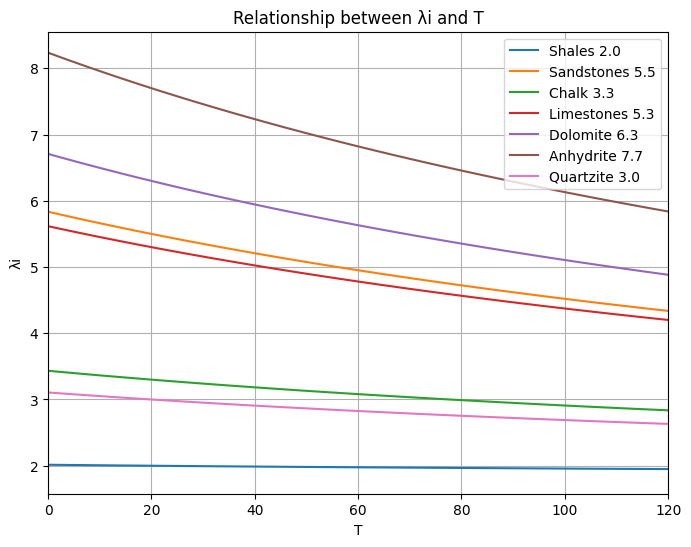

In [ ]:
def Sekiguchi_Waples(T, lambda_m, correction=True):
  ###
  # return thermal conductivity depending from tempreture
  ###
  if correction == True:
    return 358 * (1.0227 * lambda_m - 1.882) * (T**(-1) - 0.00068) + 1.84
  else:
    pass

# Get the unique values from the "TC matrix" column
lam_20_range = df_constast["TC matrix"].unique()
label_range = df_constast["Lithology_type"]

fig, ax = plt.subplots(figsize=(8, 6))

for lam_20, lit in zip(lam_20_range,label_range):

  T_range = np.linspace(0, 350, 100)

  lambda_m = lam_20
  lambda_i_values = [Sekiguchi_Waples(T+273.15, lambda_m, correction=True) for T in T_range]

  ax.plot(T_range, lambda_i_values, label=f'{lit} {lam_20}')

ax.set_xlabel('T')
ax.set_ylabel('λi')
ax.set_title('Relationship between λi and T')
ax.grid(True)
ax.legend()
plt.xlim(0, 120)
plt.show()

0.0 63.685954533544326
45.0 52.870550930991655
55.0 50.17116620969431
80.0 45.191873652900995
100.0 42.61346524273573
125.0 40.53928690306466
145.0 39.482373097884626


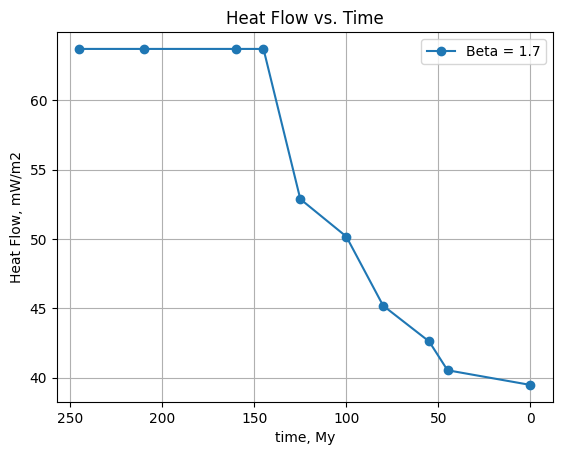

Age 0.0
0 Shales 0.599 8.133534332878806 0.975154151826328
1 Sandstones 0.449 12.942481500902288 2.0728223717558802
2 Shales 0.416 38.20736121898734 1.2136869506433425
3 Chalk 0.195 60.89442342449092 2.3047975341014135
4 Sandstones 0.221 73.3839220148863 3.1002153935845405
5 Limestones 0.049 76.34061640195415 2.7890858979696356
6 Dolomite 0.021 80.0594091052339 4.410288646820577
7 Sandstones 0.161 83.33832561958522 3.387732876348846
8 Anhydrite 0.02 89.231715462965 5.083433409223192
9 Quartzite 0.042 92.18030472215294 5.708814541293484
Age 45.0
1 Sandstones 0.473 5.339845941456124 1.9894985916755858
2 Shales 0.453 34.01180200532599 1.1624735141266502
3 Chalk 0.213 58.38977021731939 2.2493869507179927
4 Sandstones 0.228 71.378287679062 3.069256144013466
5 Limestones 0.052 74.42846768092602 2.7834245560352553
6 Dolomite 0.022 78.24064399059276 4.419956602060192
7 Sandstones 0.165 81.61827074237647 3.3715512250296324
8 Anhydrite 0.02 87.64144994423533 5.104267056807853
9 Quartzite 0.043 9

In [ ]:
T_with_rad_heat_test = pd.DataFrame()
T_without_rad_heat_test = pd.DataFrame()
T_linear_geotherm_test =  pd.DataFrame()
# age_list = list(df_well['Age (Ma)'][1:])

K_list = []

# Heat flow
heat_flow = []

# print(age_list)

beta = 1.7
Qm_array = []
for t in age_list:
  if t <= 145:
    Qm_array.append(heat_flow_fundament_calculation(beta, t, Q_const=63*10**-3,
                                                    constant=False))
    print(t, heat_flow_fundament_calculation(beta, t, Q_const=63*10**-3, constant=False)*10**3)
  else:
    Qm_array.insert(0, heat_flow_fundament_calculation(beta, 0, Q_const=63*10**-3,
                                                       constant=False))
# print(Qm_array)
Qm_array = Qm_array[::-1]
plt.plot(age_list, [x * 10**3 for x in Qm_array], label=f'Beta = {beta}', marker='o')

plt.xlabel('time, My')
plt.ylabel('Heat Flow, mW/m2')
plt.title('Heat Flow vs. Time')
plt.grid(True)
plt.legend()
plt.gca().invert_xaxis()
# plt.ylim(0, 140)
plt.show()
#  beta = stretch_factor_df[str(age)].iloc[0]

# Calculation for each age
for i, age in enumerate(age_list, start=0):

    work_layers_copy = work_layers.copy()

    T_list = []
    T_list_constant = []
    T_linear_geotherm_values = []

    T0 = 0
    G = 20

    print('Age', age)

    sum_variables_1, sum_variables_2 = [], []
    sum_variables_3, sum_variables_4 = [], []
    sum_variables_5 = []
    layers_sum = []
    heat_flow_list = []


### расчет для слоев с заданной литологией (work_layers)
    for row_index, row in enumerate(work_layers_copy[i::].itertuples(), start=i):

      lithology = work_layers_copy.at[row.Index, 'Lithology_type']
      layers_name = work_layers_copy.at[row.Index, 'Event_name']

      A = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'Radiogenic Heat Production'].iloc[0]
      K_20= tc_bulk_df.loc[row_index:].loc[tc_bulk_df['Lithology_type'] == str(lithology), f'{age}'].iloc[0]
      thickness_layer = decompaction_df.loc[row_index:].loc[decompaction_df['Lithology_type'] == str(lithology), f'{age}'].iloc[0]*1000

### Sekiguchi_Waples
      tc_matrix = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'TC matrix'].iloc[0]
      phi0 = porosity_df.loc[(porosity_df['Lithology_type'] == str(lithology)) & (porosity_df['Event_name'] == layers_name), f'{age}'].iloc[0]
      tc_water = 0.60

      if row_index == i:
        T_sg = T0
        if T0 == 0:
          T0 = 10**-3

        K_mtrx_corrected_SG = Sekiguchi_Waples(T_sg+273.15, tc_matrix, correction=True)
        # K = bulk_thermal_conductivity(K_mtrx_corrected_SG, tc_water, phi0)
        K = bulk_thermal_conductivity_geomean(K_mtrx_corrected_SG, tc_water, phi0)
      else:
        T_sg = T_list[-1]
        K_mtrx_corrected_SG = Sekiguchi_Waples(T_sg+273.15, tc_matrix, correction=True)
        # print(T_sg, lithology, tc_matrix, K_mtrx_corrected_SG)
        # K = bulk_thermal_conductivity(K_mtrx_corrected_SG, tc_water, phi0) # Arithmetic mean
        K = bulk_thermal_conductivity_geomean(K_mtrx_corrected_SG, tc_water, phi0) # Geometric mean
        K_list.append(K)


# ### Depth values
      depth = decompaction_corrected_df.loc[row_index:].loc[decompaction_corrected_df['Lithology_type'] == str(lithology), f'{age}'].iloc[0]*1000
# ### Initial depth values
      y1 = work_layers.loc[work_layers['Event_name'] == str(layers_name), 'Depth top, m'].iloc[0]
      y2 = work_layers.loc[work_layers['Event_name'] == str(layers_name), 'Depth bottom, m'].iloc[0]

      layers_sum.append(thickness_layer)
      crust_depth = sum(layers_sum)
      Qm = Qm_array[i]


### With radio heat
      if K == 0:
        sum_variables_1.append(0)
        sum_variables_2.append(0)
      else:
        sum_variables_1.append(((Qm+A*crust_depth)/K)*thickness_layer)
        sum_variables_2.append((A/(2*K))*(thickness_layer)**2)


      T = T0 + (sum(sum_variables_1) - sum(sum_variables_2))
      T_list.append(T)
      # heat_flow_list.append(Qm)

      # print(row_index, lithology, crust_depth, thickness_layer, K, Qm, T, phi0)
      # print(row_index, lithology, phi0, T, K, K_20, tc_matrix)
      print(row_index, lithology, phi0, T, K)

### without radio heat
      # Qm = 63*10**-3
      A = 0

      if K == 0:
        sum_variables_3.append(0)
      else:
        sum_variables_3.append(((Qm+A*crust_depth)/K)*thickness_layer)
        sum_variables_4.append((A/(2*K))*(thickness_layer)**2)

      T_no_heat = T0 + (sum(sum_variables_3) - sum(sum_variables_4))
      T_list_constant.append(T_no_heat)

      # print(row_index, lithology, crust_depth, thickness_layer, Qm )

# ### Linear teady-stage geotherm Appendix 12
      T_linear_geotherm_values.append(linear_geotherm(G, depth/1000))

# ### Save results in table

### with radio heat
    new_col_name = f'{age}'
    ### Save result for decompaction in table
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(T_list):] = T_list
    new_col_values = resized_list_new
    T_with_rad_heat_test[new_col_name] = new_col_values

### without radio heat
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(T_list_constant):] = T_list_constant
    new_col_values = resized_list_new
    T_without_rad_heat_test[new_col_name] = new_col_values


### Linear teady-stage geotherm Appendix 12
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(T_list_constant):] = T_linear_geotherm_values
    new_col_values = resized_list_new
    T_linear_geotherm_test[new_col_name] = new_col_values


In [ ]:
pd.DataFrame(K_list)

0
0   2.072822
1   1.213687
2   2.304798
3   3.100215
4   2.789086
5   4.410289
6   3.387733
7   5.083433
8   5.708815
9   1.162474
10  2.249387
11  3.069256
12  2.783425
13  4.419957
14  3.371551
15  5.104267
16  5.717975
17  2.153118
18  2.992447
19  2.744044
20  4.355206
21  3.292435
22  5.018056
23  5.597703
24  2.875603
25  2.719330
26  4.420650
27  3.229210
28  5.160563
29  5.705375
30  2.397375
31  4.365883
32  2.828775
33  5.511471
34  5.789397
35  3.962627
36  2.385963
37  5.731853
38  5.701031
39  2.258590
40  5.779409
41  5.621368
42  5.822567
43  5.485552
44  5.456569

In [ ]:
save_to_csv(T_with_rad_heat_test, work_layers, "Geotherm_SG.csv")

In [ ]:
save_to_csv(T_without_rad_heat_test, work_layers, "Geotherm_SG_without A.csv")

In [ ]:
T_without_rad_heat_test

0.0       45.0       55.0       80.0      100.0      125.0  \
0   8.098668   0.000000   0.000000   0.000000   0.000000   0.000000   
1  12.860578   5.319302   0.000000   0.000000   0.000000   0.000000   
2  37.258780  33.217941  34.714264   0.000000   0.000000   0.000000   
3  59.528452  57.187695  61.907808  46.284782   0.000000   0.000000   
4  70.990280  69.167514  74.966199  61.356059  26.815292   0.000000   
5  73.821486  72.094986  78.087617  64.762903  31.670482   8.748750   
6  77.402419  75.772908  82.011197  68.892955  36.531446  14.872865   
7  80.316047  78.790913  85.285736  72.531581  41.728095  22.384767   
8  86.141200  84.747589  91.663247  79.116965  48.628203  29.431895   
9  88.907615  87.590598  94.715928  82.317021  52.233277  33.410380   

       145.0      160.0      210.0     245.0  Event_name Lithology_type  
0   0.000000   0.000000   0.000000  0.000000  Layer 10_1         Shales  
1   0.000000   0.000000   0.000000  0.000000   Layer 9_1     Sandstones  
2   0.000000   0.000000   0.000000  0.000000   Layer 8_1         Shales  
3   0.000000   0.000000   0.000000  0.000000   Layer 7_1          Chalk  
4   0.000000   0.000000   0.000000  0.000000   Layer 6_1     Sandstones  
5   0.000000   0.000000   0.000000  0.000000   Layer 5_1     Limestones  
6   7.933181   0.000000   0.000000  0.000000   Layer 4_1       Dolomite  
7  17.971390  12.323061   0.000000  0.000000   Layer 3_1     Sandstones  
8  26.401276  20.723277   8.181219  0.000000   Layer 2_1      Anhydrite  
9  31.318176  25.854792  13.433362  5.945226   Layer 1_1      Quartzite

In [ ]:
T_with_rad_heat_test

0.0       45.0       55.0       80.0      100.0      125.0  \
0   8.133534   0.000000   0.000000   0.000000   0.000000   0.000000   
1  12.942482   5.339846   0.000000   0.000000   0.000000   0.000000   
2  38.207361  34.011802  35.329130   0.000000   0.000000   0.000000   
3  60.894423  58.389770  62.924705  46.642624   0.000000   0.000000   
4  73.383922  71.378288  76.983494  62.604933  27.201704   0.000000   
5  76.340616  74.428468  80.225023  66.117638  32.120812   8.761160   
6  80.059409  78.240644  84.280470  70.361489  37.045664  14.909808   
7  83.338326  81.618271  87.915326  74.332964  42.491709  22.580016   
8  89.231715  87.641450  94.358829  80.975922  49.426640  29.646871   
9  92.180305  90.663342  97.590082  84.336328  53.143772  33.703484   

       145.0      160.0      210.0     245.0  Event_name Lithology_type  
0   0.000000   0.000000   0.000000  0.000000  Layer 10_1         Shales  
1   0.000000   0.000000   0.000000  0.000000   Layer 9_1     Sandstones  
2   0.000000   0.000000   0.000000  0.000000   Layer 8_1         Shales  
3   0.000000   0.000000   0.000000  0.000000   Layer 7_1          Chalk  
4   0.000000   0.000000   0.000000  0.000000   Layer 6_1     Sandstones  
5   0.000000   0.000000   0.000000  0.000000   Layer 5_1     Limestones  
6   7.944988   0.000000   0.000000  0.000000   Layer 4_1       Dolomite  
7  18.106520  12.368568   0.000000  0.000000   Layer 3_1     Sandstones  
8  26.552455  20.779019   8.186171  0.000000   Layer 2_1      Anhydrite  
9  31.539303  25.966171  13.479383  5.956217   Layer 1_1      Quartzite

In [ ]:
T0 = 0
Linear = T_linear_geotherm_test["0.0"].tolist()
Linear.insert(0, T0)

A_line = T_without_rad_heat_test["0.0"].tolist()
A_line.insert(0, T0)

C_line = T_with_rad_heat_test["0.0"].tolist()
C_line.insert(0, T0)

[0, 9.999999999999986, 14.352173913043478, 29.999999999999996, 53.130434782608695, 73.35217391304349, 70.3913043478261, 81.54782608695652, 90.35217391304346, 100.39999999999998, 107.99999999999999] [0, 0.2, 0.45, 1.2, 2.5, 3.4, 3.6, 4.0, 4.25, 5.0, 5.4]


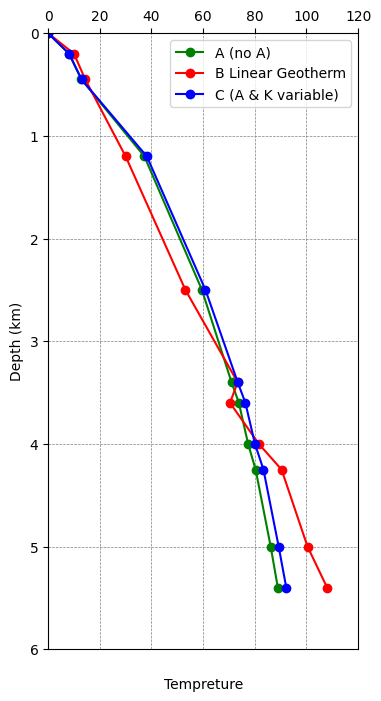

In [ ]:
y = work_layers["Depth bottom, m"].tolist()
y_add = y.insert(0, 0)

print(Linear, y)

plt.figure(figsize=(4, 8))
plt.plot(A_line, y , label='A (no A)', marker='o', color='green')
# plt.plot(T_true['0'], y , label='McKenzie')
plt.plot(Linear, y , label='B Linear Geotherm', marker='o', color='red')
plt.plot(C_line, y , label='C (A & K variable)', marker='o', color='blue')


# plt.axis([np.round(max(age_values), -2), np.min(age_values), np.max(output_df)+0.5, 0])

plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
# plt.tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)

# Move the x-axis label to the top
plt.xlabel(f'Tempreture', labelpad=20)
plt.ylabel(f'Depth (km)')
# plt.gca().xaxis.set_label_coords(0.5, 1.15)

plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)

plt.xlim(0, 120)
plt.ylim(0, 6)
plt.gca().invert_yaxis()
plt.show()

#### Plot: Geotherm

In [ ]:
T0 = 0
Linear = T_linear_geotherm["0.0"].tolist()
Linear.insert(0, T0)

A_line = T_without_rad_heat["0.0"].tolist()
A_line.insert(0, T0)

C_line = T_with_rad_heat["0.0"].tolist()
C_line.insert(0, T0)

[0, 9.999999999999986, 14.352173913043478, 29.999999999999996, 53.130434782608695, 73.35217391304349, 70.3913043478261, 81.54782608695652, 90.35217391304346, 100.39999999999998, 107.99999999999999] [0, 0.2, 0.45, 1.2, 2.5, 3.4, 3.6, 4.0, 4.25, 5.0, 5.4]


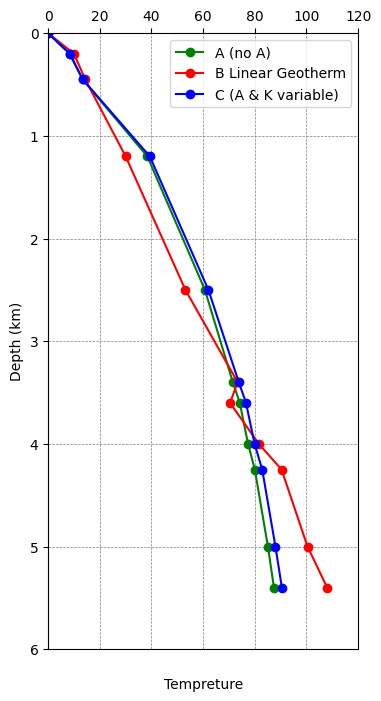

In [ ]:
y = work_layers["Depth bottom, m"].tolist()
y_add = y.insert(0, 0)

print(Linear, y)

plt.figure(figsize=(4, 8))
plt.plot(A_line, y , label='A (no A)', marker='o', color='green')
# plt.plot(T_true['0'], y , label='McKenzie')
plt.plot(Linear, y , label='B Linear Geotherm', marker='o', color='red')
plt.plot(C_line, y , label='C (A & K variable)', marker='o', color='blue')


# plt.axis([np.round(max(age_values), -2), np.min(age_values), np.max(output_df)+0.5, 0])

plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
# plt.tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)

# Move the x-axis label to the top
plt.xlabel(f'Tempreture', labelpad=20)
plt.ylabel(f'Depth (km)')
# plt.gca().xaxis.set_label_coords(0.5, 1.15)

plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)

plt.xlim(0, 120)
plt.ylim(0, 6)
plt.gca().invert_yaxis()
plt.show()

In [ ]:
def makeplot(data1, data2, top_depth, bottom_depth):
    # fig = plt.figure(constrained_layout=True, figsize=(10, 6))
    # ax = fig.subplots(1, 2,  sharex=False)

    fig, ax = plt.subplots(figsize=(14,7))

    ax1 = plt.subplot2grid((1,3), (0,0), rowspan=1, colspan = 1)
    ax2 = plt.subplot2grid((1,3), (0,1), rowspan=1, colspan = 1, sharey = ax1)
    ax3 = plt.subplot2grid((1,3), (0,2), rowspan=1, colspan = 1, sharey = ax1)

    # As our curve scales will be detached from the top of the track,
    # this code adds the top border back in without dealing with splines
    # ax10 = ax1.twiny()
    # ax10.xaxis.set_visible(False)

    # ax13 = ax4.twiny()
    # ax13.xaxis.set_visible(False)

### Plot 1
    # Geotherma
    T0 = 0

    x_values = data1['0.0'].tolist()
    x_values.insert(0, T0)
    y_values = decompaction_corrected_df['0.0'].tolist()
    y_values.insert(0, 0)
    ax1.plot(x_values, y_values, label='With radiation', marker='o', color='red')

    x_values = data2['0.0'].tolist()
    x_values.insert(0, T0)
    y_values = decompaction_corrected_df['0.0'].tolist()
    y_values.insert(0, 0)
    ax1.plot(x_values, y_values, label='Linear', marker='o', color='black')
    # ax1.plot(T_true['0'], decompaction_corrected_df['0'], label='McKenzie')

    ax1.set_xlabel(f'Tempreture', labelpad=20)
    ax1.set_ylabel(f'Depth (km)')
    ax1.legend()
    ax1.set_xlim([0, 120])

### Plot 2
    # Lithology track
    # ax2.plot(T_with_rad_heat["Lithology"], T_with_rad_heat['depth 0'], color = "black", linewidth = 0.5)
    ax2.set_xlabel("Lithology")
    ax2.set_xlim(0, 1)
    ax2.xaxis.label.set_color("black")
    ax2.tick_params(axis='x', colors="black")
    ax2.spines["top"].set_edgecolor("black")
    ax2.set_xticks([0, 1])

    depth_start = 0

    for lit, depth in zip(work_layers_with_color.index, decompaction_corrected_df['0.0']):
        key = int(lit)
        color = work_layers_with_color.at[lit, 'Color']
        hatch = work_layers_with_color.at[lit, 'Index']

        depth_values = [depth_start, depth]
        depth_start = depth

        ax2.fill_betweenx(depth_values, 0, 1, facecolor=color, hatch=hatch)

    ax2.set_xticks([0, 1])

### Plot3
    ax3.set_xlabel("Lithology")
    ax3.set_xlim(0, 1)
    ax3.xaxis.label.set_color("black")
    ax3.tick_params(axis='x', colors="black")
    ax3.spines["top"].set_edgecolor("black")
    ax3.set_xticks([0, 1])

    depth_start = 0

    for lit, depth in zip(work_layers_with_color['Lithology_type'], decompaction_corrected_df['0.0']):
        key = lit
        depth_values = [depth_start, depth]
        depth_start = depth

        label_position = (0.5, sum(depth_values) / 2)  # Assuming x position is at 0.5
        ax3.text(label_position[0], label_position[1], key, ha='center', va='center')
        ax3.plot([0, 1], [depth, depth], color='black', linewidth=1)  # Assuming black color and linewidth of 1



    for ax in [ax1, ax2, ax3]:
        ax.set_ylim(bottom_depth, top_depth)
        ax.grid(which='major', color='lightgrey', linestyle='-')
        ax.xaxis.set_ticks_position("top")
        ax.xaxis.set_label_position("top")
        ax.spines["top"].set_position(("axes", 1.02))

    for ax in [ax2]:
        plt.setp(ax.get_yticklabels(), visible = False)

    plt.tight_layout()
    fig.subplots_adjust(wspace = 0.15)

<ipython-input-614-57f9e49145b8>:61: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error in 3.11.
  ax2.fill_betweenx(depth_values, 0, 1, facecolor=color, hatch=hatch)


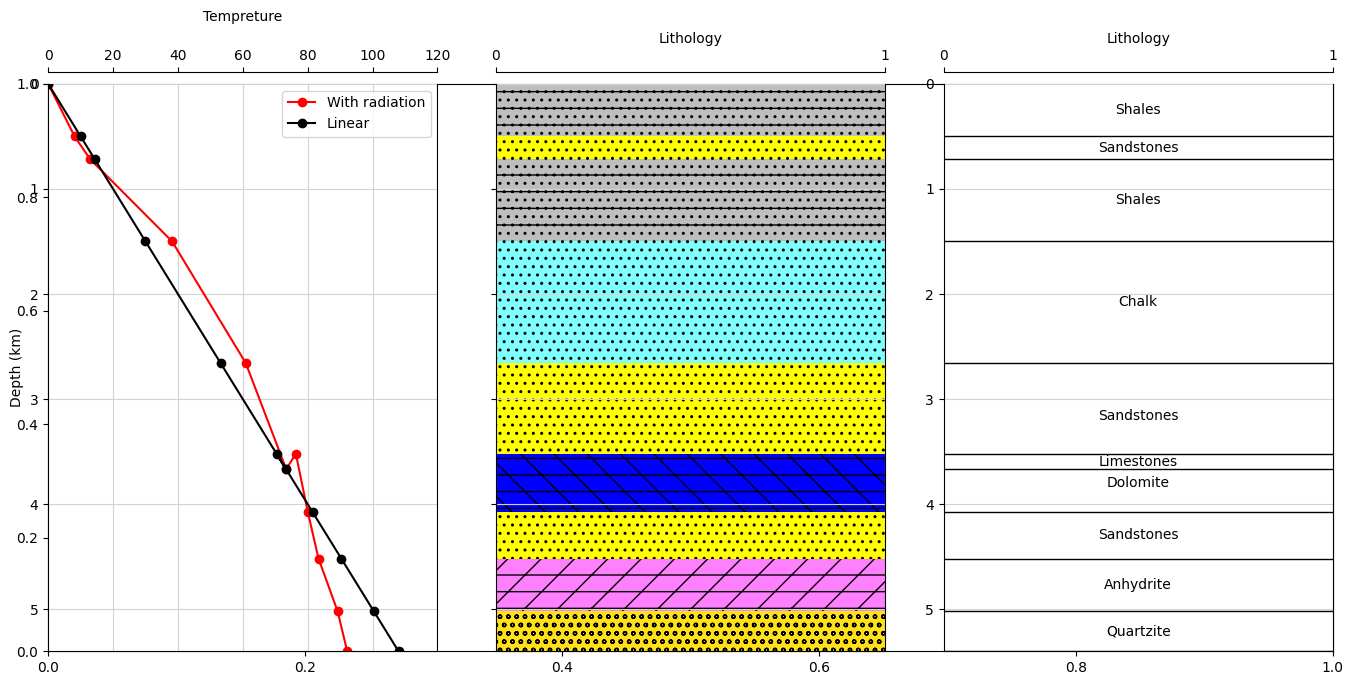

In [ ]:
temperature = pd.read_csv('/content/Geotherm_SG.csv', skiprows=0, header=0)
linear_temperature = pd.read_csv('/content/Linear_Geotherm.csv', skiprows=0, header=0)

makeplot(temperature, # данные 1: геотерма с изменяюшимся ТС и Радиацией
         linear_temperature,  # данные 2: линейная геотерма
         0, max(decompaction_corrected_df['0.0']))

### Plot: Paleotemperature

[0.0, 45.0, 55.0, 80.0, 100.0, 125.0, 145.0, 160.0, 210.0, 245.0]


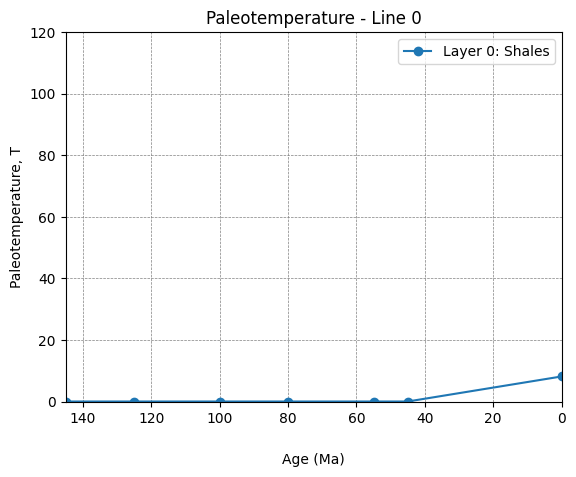

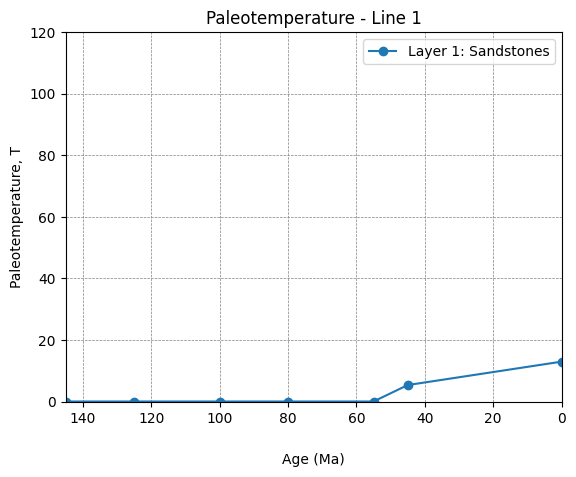

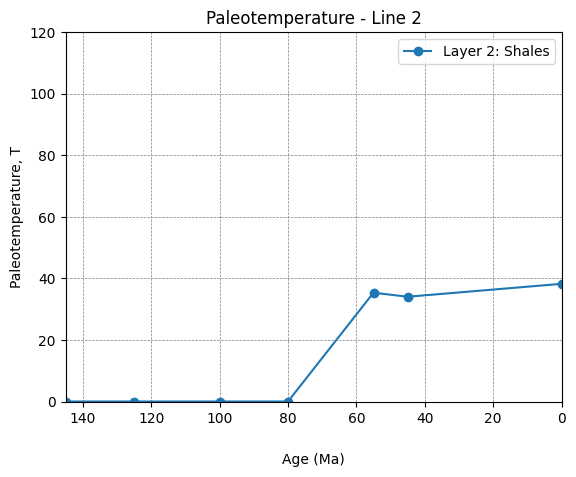

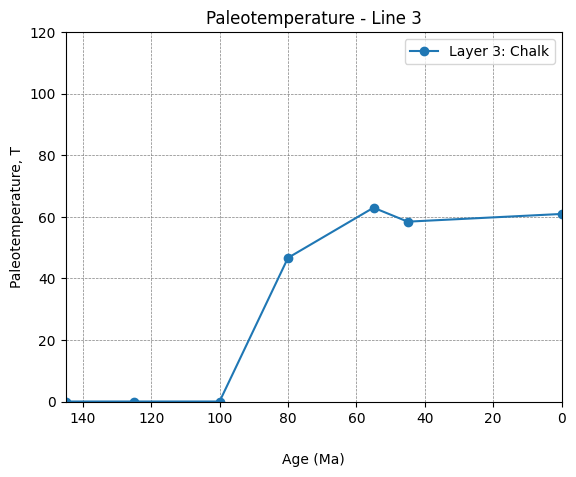

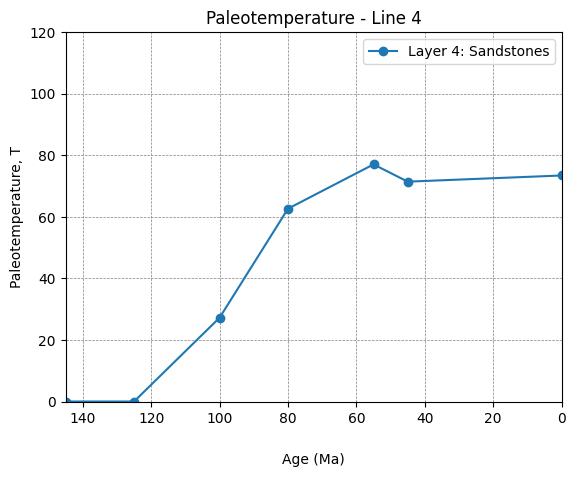

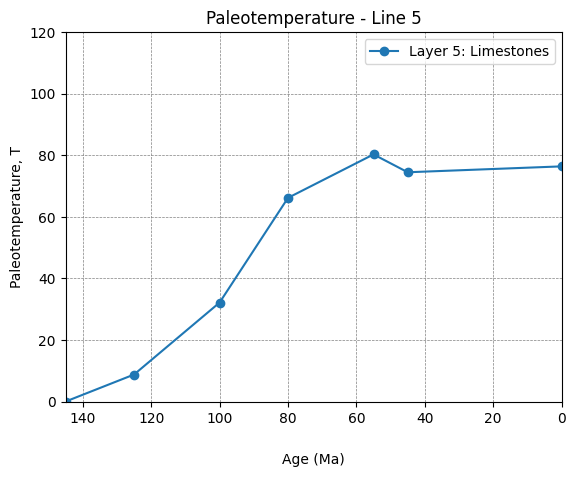

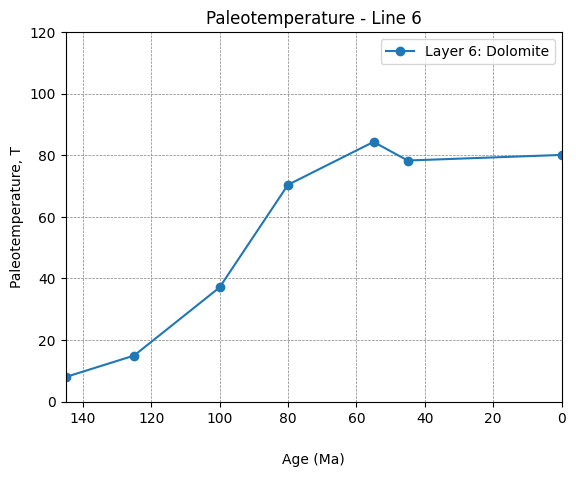

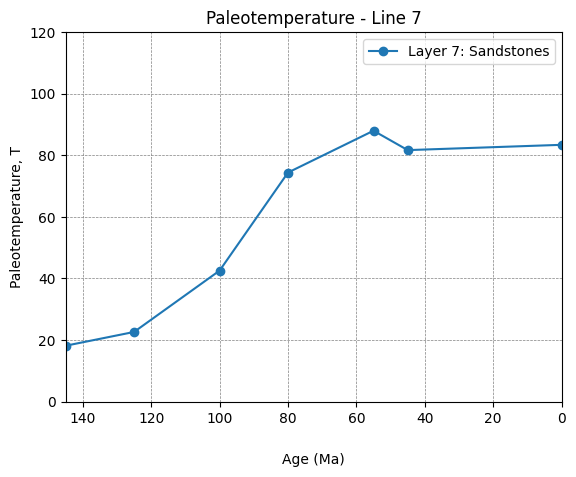

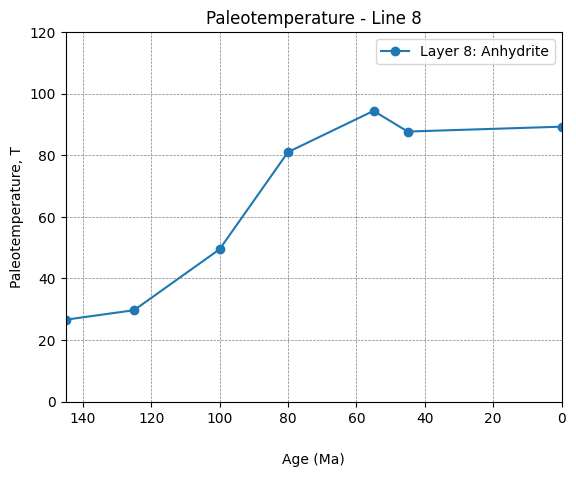

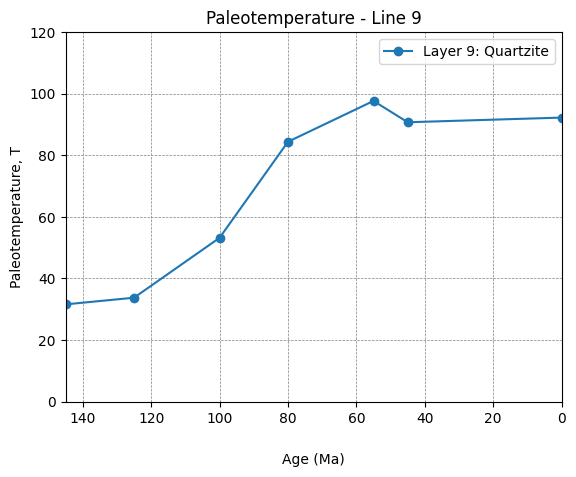

In [ ]:
# age_values = [float(age) for age in work_layers['Age (Ma)'][0:]]

# values_for_plot = pd.read_csv('/content/Geotherm_with_A', skiprows=0, header=0)
values_for_plot = pd.read_csv('/content/Geotherm_SG.csv', skiprows=0, header=0)

age_values = values_for_plot.iloc[0:, 3:values_for_plot.shape[1]].columns.astype(float).tolist()[::-1]
print(age_values)

for row_index, row in values_for_plot.iloc[0:, 3:values_for_plot.shape[1]].iterrows():
    plt.figure()  # Create a new figure for each row
    lithology = values_for_plot["Lithology_type"][row_index]
    plt.plot(age_values, row[::-1], label= "Layer "+ str(row_index) + ": "+ str(lithology), marker='o')
    plt.xlabel('Age (Ma)', labelpad=20)
    plt.ylabel('Paleotemperature, T')
    plt.legend()
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    plt.xlim(0, 145)
    plt.ylim(0, 120)
    plt.gca().invert_xaxis()
    plt.title(f"Paleotemperature - Line {row_index}")
    plt.show()

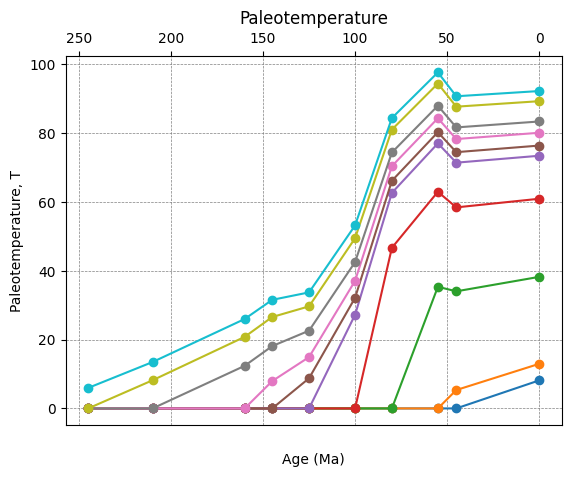

In [ ]:
# age_values  = [int(age) for age in work_layers['Age (Ma)'][0:]]
# print(age_values )
# print(age_values[::-1])

values_for_plot = pd.read_csv('/content/Geotherm_SG.csv',
                              skiprows=0, header=0)

age_values = values_for_plot.iloc[0:, 3:values_for_plot.shape[1]].columns.astype(float).tolist()[::-1]
for row_index, row in values_for_plot.iloc[0:, 3:values_for_plot.shape[1]].iterrows():
  plt.plot(age_values, row[::-1], label=str(row_index), marker='o')

# Move the x-axis label to the top
plt.xlabel('Age (Ma)', labelpad=20)
plt.ylabel('Paleotemperature, T')

# Adjust tick parameters
plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
plt.tick_params(axis='y', which='both', left=True, right=False, labelleft=True, labelright=False)

# plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# plt.xlim(0, 145)
plt.gca().invert_xaxis()
plt.title("Paleotemperature")


# Display the plot
plt.show()

#Pressure

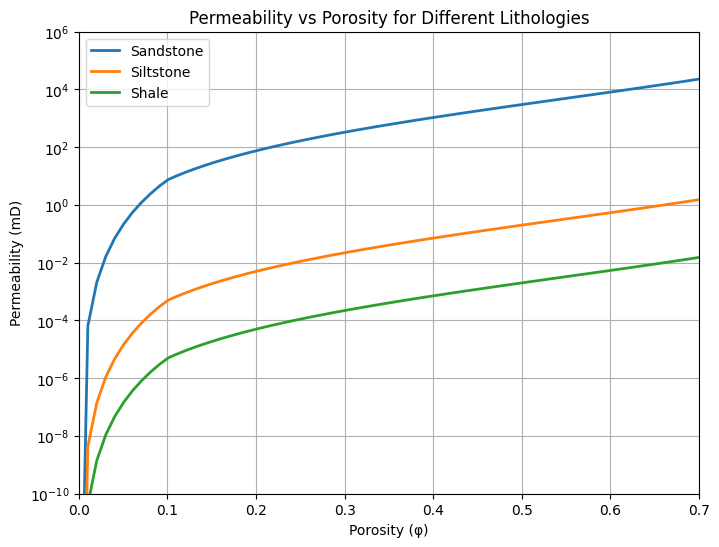

In [ ]:
def Kozeny_Carman(r, phi, tau):
    return r**2 * phi / (8 * tau**2)

def Kozeny_Carman_lithology(phi, k, S):
    phi_corrected = phi - 3.1 * 10e-10
    if phi_corrected < 0.1:
        return 2 * 10**16 * k * (phi_corrected**5 / (S**2 * (1 - phi_corrected)**2))
    else:
        return 2 * 10**14 * k * (phi_corrected**3 / (S**2 * (1 - phi_corrected)**2))

# Define lithology properties
shale = {
    'spec. surf. area': 10**8,
    'k': 0.2
}

siltstone = {
    'spec. surf. area': 10**7,
    'k': 0.2
}

sandstone = {
    'spec. surf. area': 10**6,
    'k': 30.0
}

lithology_types = ['sandstone', 'siltstone', 'shale']

# Create an array of porosities
phi_array = np.linspace(0.00001, 1, 100)  # Start from a small positive value

plt.figure(figsize=(8, 6))

# Loop through each lithology and calculate effective stress
for lithology in lithology_types:
    if lithology == 'sandstone':
        k = sandstone['k']
        SSA = sandstone['spec. surf. area']
    elif lithology == 'siltstone':
        k = siltstone['k']
        SSA = siltstone['spec. surf. area']
    elif lithology == 'shale':
        k = shale['k']
        SSA = shale['spec. surf. area']

    # Calculate permeability for the current lithology
    permeability = [Kozeny_Carman_lithology(phi, k=k, S=SSA) for phi in phi_array]
    conversion_factor = 0.98692*10**-15 # Convert m² to D
    permeability_md = (list(map(lambda x: x * conversion_factor, permeability)))
    # permeability_KZ = [Kozeny_Carman(phi, k=k, S=SSA) for phi in phi_array]

    # Plot the permeability for the current lithology
    # plt.plot(phi_array, permeability_md, label=f'{lithology.capitalize()}', linewidth=2)
    plt.plot(phi_array, permeability, label=f'{lithology.capitalize()}', linewidth=2)

# Customize the plot
plt.title('Permeability vs Porosity for Different Lithologies')
plt.xlabel('Porosity (φ)')
plt.ylabel('Permeability (mD)')
plt.grid(True)
plt.xlim(0, 0.7)
plt.ylim(10e-11, 10**6)

# Set y-axis to logarithmic scale
plt.yscale('log')

plt.legend()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ================== PERMEABILITY FUNCTIONS ==================
def Kozeny_Carman(r, phi, tau):
    return r**2 * phi / (8 * tau**2)

def Kozeny_Carman_lithology(phi, k, S):
    phi_corrected = phi - 3.1 * 10e-10
    if phi_corrected < 0.1:
        return 2 * 10**16 * k * (phi_corrected**5 / (S**2 * (1 - phi_corrected)**2))
    else:
        return 2 * 10**14 * k * (phi_corrected**3 / (S**2 * (1 - phi_corrected)**2))

# Define lithology properties (move this to your constants section)
lithology_properties = {
    'shale': {'spec. surf. area': 10**8, 'k': 0.2},
    'siltstone': {'spec. surf. area': 10**7, 'k': 0.2},
    'sandstone': {'spec. surf. area': 10**6, 'k': 30.0}
}

# ================== MAIN SCRIPT ==================
# Initialize result DataFrames (add permeability_df)
decompaction_df = pd.DataFrame()
decompaction_corrected_df = pd.DataFrame()
porosity_df = pd.DataFrame()
density_df = pd.DataFrame()
density_column_df = pd.DataFrame()
permeability_df = pd.DataFrame()  # New DataFrame for permeability

# Prepare age list
age_list = list(work_layers['Age (Ma)'].unique())
print(age_list)

# Constants
RoWater, RoMantle = 1000, 3300

for i, age in enumerate(age_list):
    print(f'\nProcessing age {i}: {age} Ma')

    # Make a copy of work layers for this iteration
    work_layers_copy = work_layers[:10]

    # Initialize lists for this age (add permeability_list)
    thickness_list = []
    thickness_corrected_list = []
    porosity_list = []
    density_list = []
    density_column_values = []
    permeability_list = []  # New list for permeability values

    # Process each layer
    for row_index, row in work_layers_copy.iloc[i:].iterrows():
        try:
            lithology = row['Lithology_type']
            layers_name = row['Event_name']

            # Safely get lithology parameters with defaults
            lith_mask = (work_layers_copy['Lithology_type'] == str(lithology))
            PWD = work_layers_copy.loc[lith_mask, 'Paleobathymetry, Ma'].iloc[0]/1000 if lith_mask.any() else 0
            eustatic = work_layers_copy.loc[lith_mask, 'Sea level, m'].iloc[0]/1000 if lith_mask.any() else 0

            const_mask = (df_constast['Lithology_type'] == str(lithology))
            if const_mask.any():
                phi0 = df_constast.loc[const_mask, 'Porosity'].values[0]
                c = df_constast.loc[const_mask, 'Exp_decay, km-1'].values[0]
                RoGrain = df_constast.loc[const_mask, 'Grain density'].values[0]

            y1 = row['Depth top, m']
            y2 = row['Depth bottom, m']

            # [Previous decompaction calculations remain the same...]

            # ===== NEW: PERMEABILITY CALCULATION =====
            if lithology.lower() in lithology_properties:
                lith_data = lithology_properties[lithology.lower()]
                permeability = Kozeny_Carman_lithology(
                    # phi=porosity,  # Using the calculated porosity
                    phi=phi0,
                    k=lith_data['k'],
                    S=lith_data['spec. surf. area']
                )

                print(phi, k, S)
                # Convert to millidarcies if needed
                conversion_factor = 0.98692 * 10**-15
                permeability_md = permeability * conversion_factor
                permeability_list.append(permeability_md)
            else:
                permeability_list.append(np.nan)  # For unknown lithologies

            # [Rest of your existing calculations...]

        except Exception as ex:
            print(f"Error processing row {row_index} (Lithology: {lithology}): {str(ex)}")
            permeability_list.append(np.nan)  # Add NaN if error occurs
            continue

    # [Your existing DataFrame storage code...]

    # Store permeability results
    resized_list = np.zeros(work_layers_copy.shape[0])
    resized_list[len(resized_list) - len(permeability_list):] = permeability_list
    permeability_df[new_col_name] = resized_list

# ===== OPTIONAL: PLOTTING =====
# You can add your plotting code here to visualize permeability vs age
# for different lithologies

[np.float64(0.0), np.float64(45.0), np.float64(55.0), np.float64(80.0), np.float64(100.0), np.float64(125.0), np.float64(145.0), np.float64(160.0), np.float64(210.0), np.float64(245.0), np.float64(260.0)]

Processing age 0: 0.0 Ma

Processing age 1: 45.0 Ma

Processing age 2: 55.0 Ma

Processing age 3: 80.0 Ma

Processing age 4: 100.0 Ma

Processing age 5: 125.0 Ma

Processing age 6: 145.0 Ma

Processing age 7: 160.0 Ma

Processing age 8: 210.0 Ma

Processing age 9: 245.0 Ma

Processing age 10: 260.0 Ma


In [ ]:
permeability_df

260.0
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
6    0.0
7    0.0
8    0.0
9    0.0

In [ ]:
work_layers_copy['Lithology_type']

0        Shales
1    Sandstones
2        Shales
3         Chalk
4    Sandstones
5    Limestones
6      Dolomite
7    Sandstones
8     Anhydrite
9     Quartzite
Name: Lithology_type, dtype: object

In [ ]:
sandstone_row = Database_Lithotypes[Database_Lithotypes['Lithology type'] == 'Sandstone (quartzite, very quartz rich)']
sandstone_row

Lithology type Density Initial porosity  \
4  Sandstone (quartzite, very quartz rich)    2640               42   

  Minimum porosity Compaction model Key Compressibility MAX  \
4                1   Athy's law (depth)               25.26   

  Compressibility MIN Athy factor k (stress) Schneider Factor ka  \
4                1.18                  24.61               16.15   

  Schneider factor kb  ...   Ea     A Clay Content Porosity Opal A- opal CT  \
4               39.77  ...  23.2  0.0            0                        0   

  Permeability Opal A- Opal CT Capillary Pressure Opal A-opal CT  \
4                            0                                 0   

  Porosity Opal CT-Quartz Permeability Opal CT - Quartz  \
4                       0                             0   

  Capillary pressure Opal CT - Quartz Special options  
4                                   0             NaN  

[1 rows x 157 columns]

In [ ]:
Database_Lithotypes['Lithology type'].tolist()

['Sandstone (typical)',
 'Sandstone (clay rich)',
 'Sandstone (clay poor)',
 'Sandstone (quartzite, typical)',
 'Sandstone (quartzite, very quartz rich)',
 'Sandstone (subarkose, typical)',
 'Sandstone (subarkose, quartz rich)',
 'Sandstone (subarkose, clay rich)',
 'Sandstone (subarkose, clay poor)',
 'Sandstone (subarkose, dolomite rich)',
 'Sandstone (arkose, typical)',
 'Sandstone (arkose, quartz rich)',
 'Sandstone (arkose, quartz poor)',
 'Sandstone (arkose, clay rich)',
 'Sandstone (arkose, clay poor)',
 'Sandstone (arkose, dolomite rich)',
 'Sandstone (wacke)',
 'Shale (typical)',
 'Shale (organic lean, typical)',
 'Shale (organic lean, sandy)',
 'Shale (organic lean, silty)',
 'Shale (organic lean, siliceous, typical)',
 'Shale (organic lean, siliceous, 95% opal-CT)',
 'Shale (black)',
 'Shale (organic rich, typical)',
 'Shale (organic rich, 3% TOC)',
 'Shale (organic rich, 8% TOC)',
 'Shale (organic rich, 20% TOC)',
 'Siltstone (organic lean)',
 'Siltstone (organic rich, typi

In [ ]:
if 'Sandstone (typical)' in Database_Lithotypes['Lithology type'].values:
    print("✅ found (case-sensitive match)")
else:
    print("❌ NOT found (case-sensitive match)")

# exists = Database_Lithotypes['Lithology type'].str.lower().eq('sandstone').any()
# if exists:
#     print("✅ 'Sandstone' found (case-insensitive match)")
# else:
#     print("❌ 'Sandstone' NOT found (case-insensitive match)")

✅ found (case-sensitive match)


In [ ]:
for index, lith in enumerate(work_layers_copy['Lithology_type'].tolist()):
    var_name = f'{lith}_{index}'
    globals()[var_name] = Database_Lithotypes[Database_Lithotypes['Lithology type'] == lith]
    print(globals()[var_name]["Compressibility MIN"])

# sandstone_row = Database_Lithotypes[Database_Lithotypes['Lithology type'] == 'Sandstone (quartzite, very quartz rich)']
# sandstone_row

Series([], Name: Compressibility MIN, dtype: object)
Series([], Name: Compressibility MIN, dtype: object)
Series([], Name: Compressibility MIN, dtype: object)
Series([], Name: Compressibility MIN, dtype: object)
Series([], Name: Compressibility MIN, dtype: object)
Series([], Name: Compressibility MIN, dtype: object)
134    0
Name: Compressibility MIN, dtype: object
Series([], Name: Compressibility MIN, dtype: object)
52    0
Name: Compressibility MIN, dtype: object
112    0
Name: Compressibility MIN, dtype: object


In [ ]:
sandstone_row["Compressibility MIN"]

4    1.18
Name: Compressibility MIN, dtype: object